In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('/home/bdolan/python/'))

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from csuram import RadarConfig
configdat = RadarConfig.RadarConfig(dz='DBZ')
import pickle
import warnings
warnings.filterwarnings('ignore')
import glob
import os
from pathlib import Path
import matplotlib.colors as colors
import pyart
from datetime import datetime
from scipy.ndimage import label, generate_binary_structure, center_of_mass

import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)
matplotlib.rcParams.update({'font.size': 22})

import pandas as pd


import xarray as xr
from copy import deepcopy
import incus_helper as IH



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/usr/local/anaconda3/lib/python3.8/site-packages/pandas/compat/numpy/__init__.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _nlv = LooseVersion(_np_version)
/usr/local/anaconda3/lib/python3.8/site-packages/pandas/compat/numpy/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  np_version_under1p17 = _nlv < LooseVersion("1.17")
/usr/local/anaconda3/lib/python3.8/site-packages/pandas/compat/numpy/__init__.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  np_version_under1p18 = _nlv < LooseVersion("1.18")
/usr/local/anaconda3/lib/python3.8/site-packages/pandas/compat/numpy/__init__.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p19 = _nlv < LooseVersion("1.19")
/usr/local/anaconda3/lib/python3.8/site-packages/pandas/compat/numpy/__init__.py:14: Deprecat

In [3]:
def get_sdat(dat,az=0.0,radar='chivo'):
    x = dat['x0'].values
    y = dat['y0'].values
    z = dat['z0'].values
    dz = np.squeeze(dat['filtered_refectivity'].values)
    whgd =  np.where(dz>-10)
    if 'differential_reflectivity' in dat.keys():
        dumzr = np.squeeze(dat['differential_reflectivity'].values)
        zr = np.zeros_like(dumzr)*np.nan
        zr[whgd] = dumzr[whgd]
#        dumrho = np.squeeze(dat['cross_correlation_ratio'].values)
        
        dumkdp = np.squeeze(dat['specific_differential_phase'].values)
        if radar == 'chivo':
           dumsw = np.squeeze(dat['spectrum_width'].values)
           dumrho = np.squeeze(dat['cross_correlation_ratio'].values)
        else:
            dumrho = np.squeeze(dat['copol_correlation_coeff'].values)
            dumsw = np.squeeze(dat['spectral_width'].values)
        rho = np.zeros_like(dumrho)*np.nan
        rho[whgd]=dumrho[whgd]
        kdp = np.zeros_like(dumkdp)*np.nan
        kdp[whgd]=dumkdp[whgd]
        sw= np.zeros_like(dumsw)*np.nan
        sw[whgd]=dumsw[whgd]
    
    ve = np.squeeze(dat['CV'].values)
    lat0 = dat['lat0'].values
    lon0 = dat['lon0'].values
    tm = dat['time'].values[0]
    dattim= pd.to_datetime(str(tm)).replace(tzinfo=None)
    #dattim = pd.to_datetime(str(tm))
    

    if 'differential_reflectivity' in dat.keys():
    
        data = {'x':x,'y':y,'z':z,'dz':dz,'ve':ve,'lat':lat0,'lon':lon0,'time':dattim,'az':az,
        'rho':rho,'kdp':kdp,'sw':sw,'zdr':zr}#
    else:
        data = {'x':x,'y':y,'z':z,'dz':dz,'ve':ve,'lat':lat0,'lon':lon0,'time':dattim,'az':az}

    return data


In [4]:
from CSU_RadarTools import csu_radartools
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc, fundamentals)


In [5]:
date = '20220622'
radar = 'csapr'
figdir = f'/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/PAPER1_FIGS/V6/'
scansets = pickle.load(open(f'/rasmussen-scratch2/bdolan/INCUS/SCANSETS/{radar}_{date}_scansets_grid.p','rb'))
mkeys = [189]



In [6]:
# date = '20220916'
# radar = 'chivo'
# figdir = f'/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/{date}/{radar}_DZ/'
# scansets = pickle.load(open(f'/rasmussen-scratch2/bdolan/INCUS/SCANSETS/{radar}_{date}_scansets_grid.p','rb'))
#mkeys = [189]

In [7]:
slen = len(scansets)
ssets = scansets.keys()
az = []
tm = []
rhival = []
ssetval = []
for i,s in enumerate(ssets):
    if s == '620':
        print('gotcha')
    try:
        nrhi = scansets[s]['nrhi']
        print(nrhi,i)
        for j,n in enumerate(range(nrhi)):
            
            if radar == 'csapr':
                rhv = f'rhi{j+1}'
                rhvz = f'rhi{j+1}_az'
                rhvt = f'rhi{j+1}_time'
            else:
                rhv = f'rhi{j}'
                rhvz = f'rhi{j}_az'
                rhvt = f'rhi{j}_time'                
            #print(rhvt)
            az.append(scansets[s][rhvz])
            tm.append(scansets[s][rhvt])

            rhival.append(rhv)
            tdum = scansets[s][rhvt]
            
            print(scansets[s][rhvt],rhv)
            ssetval.append(s)
    except KeyError as ke:
        pass

4 1
2022-06-22 20:02:17 rhi1
2022-06-22 20:02:38 rhi2
2022-06-22 20:02:58 rhi3
2022-06-22 20:03:17 rhi4
4 2
2022-06-22 20:04:16 rhi1
2022-06-22 20:04:38 rhi2
2022-06-22 20:04:57 rhi3
2022-06-22 20:05:18 rhi4
4 3
2022-06-22 20:06:17 rhi1
2022-06-22 20:06:38 rhi2
2022-06-22 20:06:58 rhi3
2022-06-22 20:07:17 rhi4
4 4
2022-06-22 20:08:10 rhi1
2022-06-22 20:08:28 rhi2
2022-06-22 20:08:46 rhi3
2022-06-22 20:09:07 rhi4
4 5
2022-06-22 20:09:59 rhi1
2022-06-22 20:10:17 rhi2
2022-06-22 20:10:38 rhi3
2022-06-22 20:10:58 rhi4
4 6
2022-06-22 20:11:49 rhi1
2022-06-22 20:12:06 rhi2
2022-06-22 20:12:28 rhi3
2022-06-22 20:12:46 rhi4
4 7
2022-06-22 20:13:42 rhi1
2022-06-22 20:14:01 rhi2
2022-06-22 20:14:22 rhi3
2022-06-22 20:14:42 rhi4
4 8
2022-06-22 20:15:37 rhi1
2022-06-22 20:15:57 rhi2
2022-06-22 20:16:16 rhi3
2022-06-22 20:16:35 rhi4
4 9
2022-06-22 20:17:24 rhi1
2022-06-22 20:17:43 rhi2
2022-06-22 20:18:04 rhi3
2022-06-22 20:18:23 rhi4
4 10
2022-06-22 20:19:15 rhi1
2022-06-22 20:19:32 rhi2
2022-06-2

In [8]:
def get_data(scansets_rhi,scannum,nam):
    gnam = f'{nam}_gfile1'
    gnam2 = f'{nam}_gfile2'
    gnam3 = f'{nam}_gfile3'
    az = f'{nam}_az'
    tm= f'{nam}_time'
    #print(scansets_rhi[scannum].keys())
    cf = scansets_rhi[scannum][nam]
    rhi={'cf':cf,
         'gfile1':scansets_rhi[scannum][gnam],
         'gfile2':scansets_rhi[scannum][gnam2],
         'gfile3':scansets_rhi[scannum][gnam3],
         'time':scansets_rhi[scannum][tm],
         'az':scansets_rhi[scannum][az]
        }
    return rhi



In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [10]:

# for t in tm:
#     print(t)

In [11]:
deltmax = 150 #seconds
f=0
matchsets = {}
for i,t in enumerate(np.array(tm)[:-1]):
    tnew = tm[i+1:]
    v=0
    #if t == matchtime:
        #print('gotcha',t,f)
    #print(f)
    for j, n in enumerate(tnew):
        az1 = az[i]
        az2 = az[i+j+1]
        delaz = az2-az1
        tm1 = tm[i]
        tm2 = n

        delt = (tm2-tm1).seconds
        #
        #print(delaz)
        if delt<deltmax:
            
            
            if np.abs(delaz) < 0.3:
                #print(delt,delaz)
                if v == 0:
                    f=f+1
                    file1 = {'time':tm1,'az':az1,'ss':ssetval[i],'rhi':rhival[i]}
                    matchsets[f] ={}
                    matchsets[f]['file0']=file1
                
                v=v+1
                file2 = {'time':tm2,'az':az2,'ss':ssetval[i+j+1],'rhi':rhival[i+j+1]}
                #matchsets[f] = {f'file{v}':file2}
                matchsets[f][f'file{v}']=file2
                #('STOP',delt, delaz)
                matchsets[f]['nfiles'] =v+1





# for i, z in enumerate(np.array(az)):
#     chivo_scanset = ssetval[i]
#     chivo_0_rhi =rhival[i]

#     chivo_0 = get_data(scansets,chivo_scanset,chivo_0_rhi)
#     chivorhi0grid = xr.open_dataset(chivo_0['gfile1'])
#     crhi0slant2=get_sdat(chivorhi0grid,az = chivo_0['az'] )






In [64]:
def plot_dz(rhi0,ax,cb_on = False):

    # axins = inset_axes(ax,
    #                width="2%",  # width = 5% of parent_bbox width
    #                height="75%",  # height : 50%
    #                bbox_transform=ax.transAxes,
    #                borderpad=1,#loc='upper right'
    #                )
    c = ax.pcolormesh(rhi0['y'],rhi0['z'],rhi0['dz'],cmap=configdat.temp_cmap,vmin=0,vmax=80)
    if cb_on == True:
        cb = plt.colorbar(c,ax=ax,location='bottom',pad=0.2,shrink=0.8)
        cb.set_label('dBZ',fontsize=20)
    #axf[f].contour(rng,zrhi1g,diff_dz,levels=[5],colors=['k'],linestyles=['-'])
    az = rhi0['az']
    time = rhi0['time']
    ax.set_title(f'Az: {az:.2f} Time: {time:%H:%M:%S} UTC',fontsize=18)
    #axf[f].set_xlim(30,50)
    return c



def plot_dr(rhi0,ax):
    c = ax.pcolormesh(rhi0['y'],rhi0['z'],rhi0['zdr'],cmap=configdat.zdr_cmap,vmin=-1,vmax=5)
    cb = plt.colorbar(c,ax=ax)
    cb.set_label('dB',fontsize=12)

    #axf[f].contour(rng,zrhi1g,diff_dz,levels=[5],colors=['k'],linestyles=['-'])
    az = rhi0['az']
    time = rhi0['time']
    ax.set_title(f'Az: {az:.2f} \nTime: {time:%H%M%S}',fontsize=20)
    #axf[f].set_xlim(30,50)

def plot_ve(rhi0,ax):
    
    axins = inset_axes(ax,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   #bbox_to_anchor=(1.0, 0, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   loc='lower right',
                   )
    c = ax.pcolormesh(rhi0['y'],rhi0['z'],rhi0['ve'],cmap='pyart_NWSVel',vmin=-20,vmax=20)
    pos = axins.get_position()  # get the original position
    axins.set_position([pos.x0-0.4, pos.y0, pos.x1-0.4, pos.y1])  # set a new position

    cb = plt.colorbar(c,cax=axins)
    cb.set_label('m s$^{-1}$',fontsize=14)
    cb.ax.tick_params(labelsize=14)
    print(pos)

    #axf[f].contour(rng,zrhi1g,diff_dz,levels=[5],colors=['k'],linestyles=['-'])
    az = rhi0['az']
    time = rhi0['time']
    ax.set_title(f'Az: {az:.2f} Time: {time:%H:%M:%S} UTC',fontsize=18)
    #axf[f].set_xlim(30,50)

def plot_diffdelT(diffdat,ax):
    delT = diffdat['delT']  
 #   matplotlib.colors.ListedColormap(colors[:-1], "")
    cmap = plt.cm.get_cmap('bwr')

    dum1 = np.where(np.isnan(diffdat['rhi1dz']))
    dum2 = np.where(np.isnan(diffdat['rhi2dz']))

    diffdat['dzdiff'][dum1]=np.nan
    diffdat['dzdiff'][dum2]=np.nan

    cmap.set_over("gray")
    c = ax.pcolormesh(diffdat['rhi1y'],diffdat['rhi1hgt'],diffdat['dzdiff']/delT,cmap=cmap,vmin=-1,vmax=1, extend='max')
    #axf[f].contour(rng,zrhi1g,diff_dz,levels=[5],colors=['k'],linestyles=['-'])
    cb = plt.colorbar(c,ax=ax)
    cb.set_label('$\Delta$dBZ/$Delta$T',fontsize=20)
    #axf[f].contour(rng,zrhi1g,diff_dz,levels=[5],colors=['k'],linestyles=['-'])
    delaz = diffdat['delaz']
    
    ax.set_title(f'$\Delta$t] = {delT}',fontsize=20)

def create_mask(dat):
    mask = np.zeros_like(dat[0]['dz'])
    for i,d in enumerate(dat):
        dum = dat[i]['dz']
        dummask = dum*0+1
        whgd =np.where(np.isnan(dum))
        dummask[whgd]=0
        mask = mask+dummask
    return mask

def plot_diff(diffdat,ax, mask_on=False,mask='',cb_on = False):

    
    cmap = plt.cm.get_cmap('bwr')
    if mask_on == True:
        dum1 = np.isnan(diffdat['rhi1dz'])
        dum2 = np.isnan(diffdat['rhi2dz'])
        #print(np.shape(mask),np.shape(dum1))
        whma =np.equal(mask,1)
        whall1 = np.logical_and(dum1,whma)
        whall2 = np.logical_and(dum2,whma)
        whall =np.where(np.logical_or(whall1,whall2))
        #whall = np.where(whall1)
        diffdat['dzdiff'][whall]=np.nan
        diffdat['dzdiff'][whall]=np.nan

    c = ax.pcolormesh(diffdat['rhi1y'],diffdat['rhi1hgt'],diffdat['dzdiff'],cmap=cmap,vmin=-20,vmax=20)#,extend='max')
    #axf[f].contour(rng,zrhi1g,diff_dz,levels=[5],colors=['k'],linestyles=['-'])
    if cb_on == True:
        cb = plt.colorbar(c,ax=ax,location='bottom',pad=0.2,shrink=0.8)
        cb.set_label('$\Delta$Z',fontsize=18)
    
    #axf[f].contour(rng,zrhi1g,diff_dz,levels=[5],colors=['k'],linestyles=['-'])
    delaz = diffdat['delaz']
    delT = diffdat['delT']
    ax.set_title(f'$\Delta$t = {delT} s',fontsize=18)
    return c

    #axf[f].set_xlim(30,50)

In [13]:
# def plot_dz(rhi0,ax):
#     c = ax.pcolormesh(rhi0['y'],rhi0['z'],rhi0['dz'],cmap=configdat.temp_cmap,vmin=0,vmax=80)
#     cb = plt.colorbar(c,ax=ax)
#     cb.set_label('dBZ',fontsize=16)
#     #axf[f].contour(rng,zrhi1g,diff_dz,levels=[5],colors=['k'],linestyles=['-'])
#     az = rhi0['az']
#     time = rhi0['time']
#     ax.set_title(f'Az: {az:.2f} \nTime: {time:%H%M%S}',fontsize=18)
#     #axf[f].set_xlim(30,50)



# def plot_dr(rhi0,ax):
#     c = ax.pcolormesh(rhi0['y'],rhi0['z'],rhi0['zdr'],cmap=configdat.zdr_cmap,vmin=-1,vmax=5)
#     cb = plt.colorbar(c,ax=ax)
#     cb.set_label('dB',fontsize=16)
#     #axf[f].contour(rng,zrhi1g,diff_dz,levels=[5],colors=['k'],linestyles=['-'])
#     az = rhi0['az']
#     time = rhi0['time']
#     ax.set_title(f'Az: {az:.2f} \nTime: {time:%H%M%S}',fontsize=18)
#     #axf[f].set_xlim(30,50)

# def plot_ve(rhi0,ax):
#     c = ax.pcolormesh(rhi0['y'],rhi0['z'],rhi0['ve'],cmap='pyart_NWSVel',vmin=-20,vmax=20)
#     cb = plt.colorbar(c,ax=ax)
#     cb.set_label('dB',fontsize=16)
#     #axf[f].contour(rng,zrhi1g,diff_dz,levels=[5],colors=['k'],linestyles=['-'])
#     az = rhi0['az']
#     time = rhi0['time']
#     ax.set_title(f'Az: {az:.2f} \nTime: {time:%H%M%S}',fontsize=18)
#     #axf[f].set_xlim(30,50)



# def plot_diff(diffdat,ax):
#     dum1 = np.where(np.isnan(diffdat['rhi1dz']))
#     dum2 = np.where(np.isnan(diffdat['rhi2dz']))

#     diffdat['dzdiff'][dum1]=np.nan
#     diffdat['dzdiff'][dum2]=np.nan

#     c = ax.pcolormesh(diffdat['rhi1y'],diffdat['rhi1hgt'],diffdat['dzdiff'],cmap='bwr',vmin=-20,vmax=20)
#     #axf[f].contour(rng,zrhi1g,diff_dz,levels=[5],colors=['k'],linestyles=['-'])


#     cb = plt.colorbar(c,ax=ax)
#     cb.set_label('$\Delta$Z',fontsize=16)
#     #axf[f].contour(rng,zrhi1g,diff_dz,levels=[5],colors=['k'],linestyles=['-'])
#     delaz = diffdat['delaz']
#     delT = diffdat['delT']
#     ax.set_title(f'$\Delta$t = {delT} s',fontsize=18)
#     #axf[f].set_xlim(30,50)

In [14]:
matchsets[362]

{'file0': {'time': datetime.datetime(2022, 6, 22, 23, 53, 28),
  'az': 330.88074,
  'ss': '147',
  'rhi': 'rhi1'},
 'file1': {'time': datetime.datetime(2022, 6, 22, 23, 53, 47),
  'az': 330.85876,
  'ss': '147',
  'rhi': 'rhi2'},
 'nfiles': 4,
 'file2': {'time': datetime.datetime(2022, 6, 22, 23, 55, 2),
  'az': 330.85876,
  'ss': '148',
  'rhi': 'rhi1'},
 'file3': {'time': datetime.datetime(2022, 6, 22, 23, 55, 21),
  'az': 330.9027,
  'ss': '148',
  'rhi': 'rhi2'}}

In [15]:
matchsets[mkeys[0]]
# #mkeys = [189]

#mkeys = [822]

{'file0': {'time': datetime.datetime(2022, 6, 22, 22, 18, 20),
  'az': 320.28992,
  'ss': '084',
  'rhi': 'rhi3'},
 'file1': {'time': datetime.datetime(2022, 6, 22, 22, 19, 36),
  'az': 320.57556,
  'ss': '085',
  'rhi': 'rhi2'},
 'nfiles': 2}

In [16]:
%matplotlib inline

In [17]:
#matchsets.keys()

In [18]:
# for m in matchsets.keys():
#     #print(matchsets[m].keys())
#     if matchsets[m]['nfiles']>=6 and m > 800:
#         try:
#             print(m, matchsets[m]['nfiles'])
#         except:
#             pass

In [19]:


#scansets[f1['ss']]['rhi3_gfile1']

In [20]:
#mkeys=[293]
#xlim = [30,50]
mkeys=[362]
xlim = [35,60]


In [21]:
# scansets[f1['ss']]['rhi3_gfile3']='/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220916/chivo/GRID_3KM/20220916/grid.620_chivo_3.0km_rhi3_132.6_20220916_114512_rot.nc'
# scansets[f1['ss']]['rhi3_gfile2']='/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220916/chivo/GRID_1.5KM/20220916/grid.620_chivo_over1.5km_rhi3_132.6_20220916_114512_rot.nc'
# scansets[f1['ss']]['rhi3_gfile1']='/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220916/chivo/GRID_100M/20220916/grid.620_chivo_0.1km_rhi3_132.6_20220916_114512_rot.nc'

In [67]:
def label_subplots_skip(fig, xoff = 0.0, yoff = 0.005, nlabels = None):
    letters = ['a','', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 
		'i', 'j', 'k', 'l', 'm']
    figaxes = fig.get_axes()
    if nlabels is None: nlabels = len(figaxes)

    for fa in range(nlabels):
        xbox = figaxes[fa].get_position()
        xmin, ymax = xbox.xmin, xbox.ymax
        # this is the position I want
        if fa is not 1:
          fig.text(xmin+xoff, ymax+yoff, '({})'.format(letters[fa]))

def label_subplots(fig, xoff = 0.0, yoff = 0.005, nlabels = None):
    letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 
		'i', 'j', 'k', 'l', 'm']
    figaxes = fig.get_axes()
    if nlabels is None: nlabels = len(figaxes)

    for fa in range(nlabels):
        xbox = figaxes[fa].get_position()
        xmin, ymax = xbox.xmin, xbox.ymax
        # this is the position I want
      
        fig.text(xmin+xoff, ymax+yoff, '({})'.format(letters[fa]),fontsize=17)

{'time': datetime.datetime(2022, 6, 22, 23, 53, 28), 'az': 330.88074, 'ss': '147', 'rhi': 'rhi1'}
4 for 362


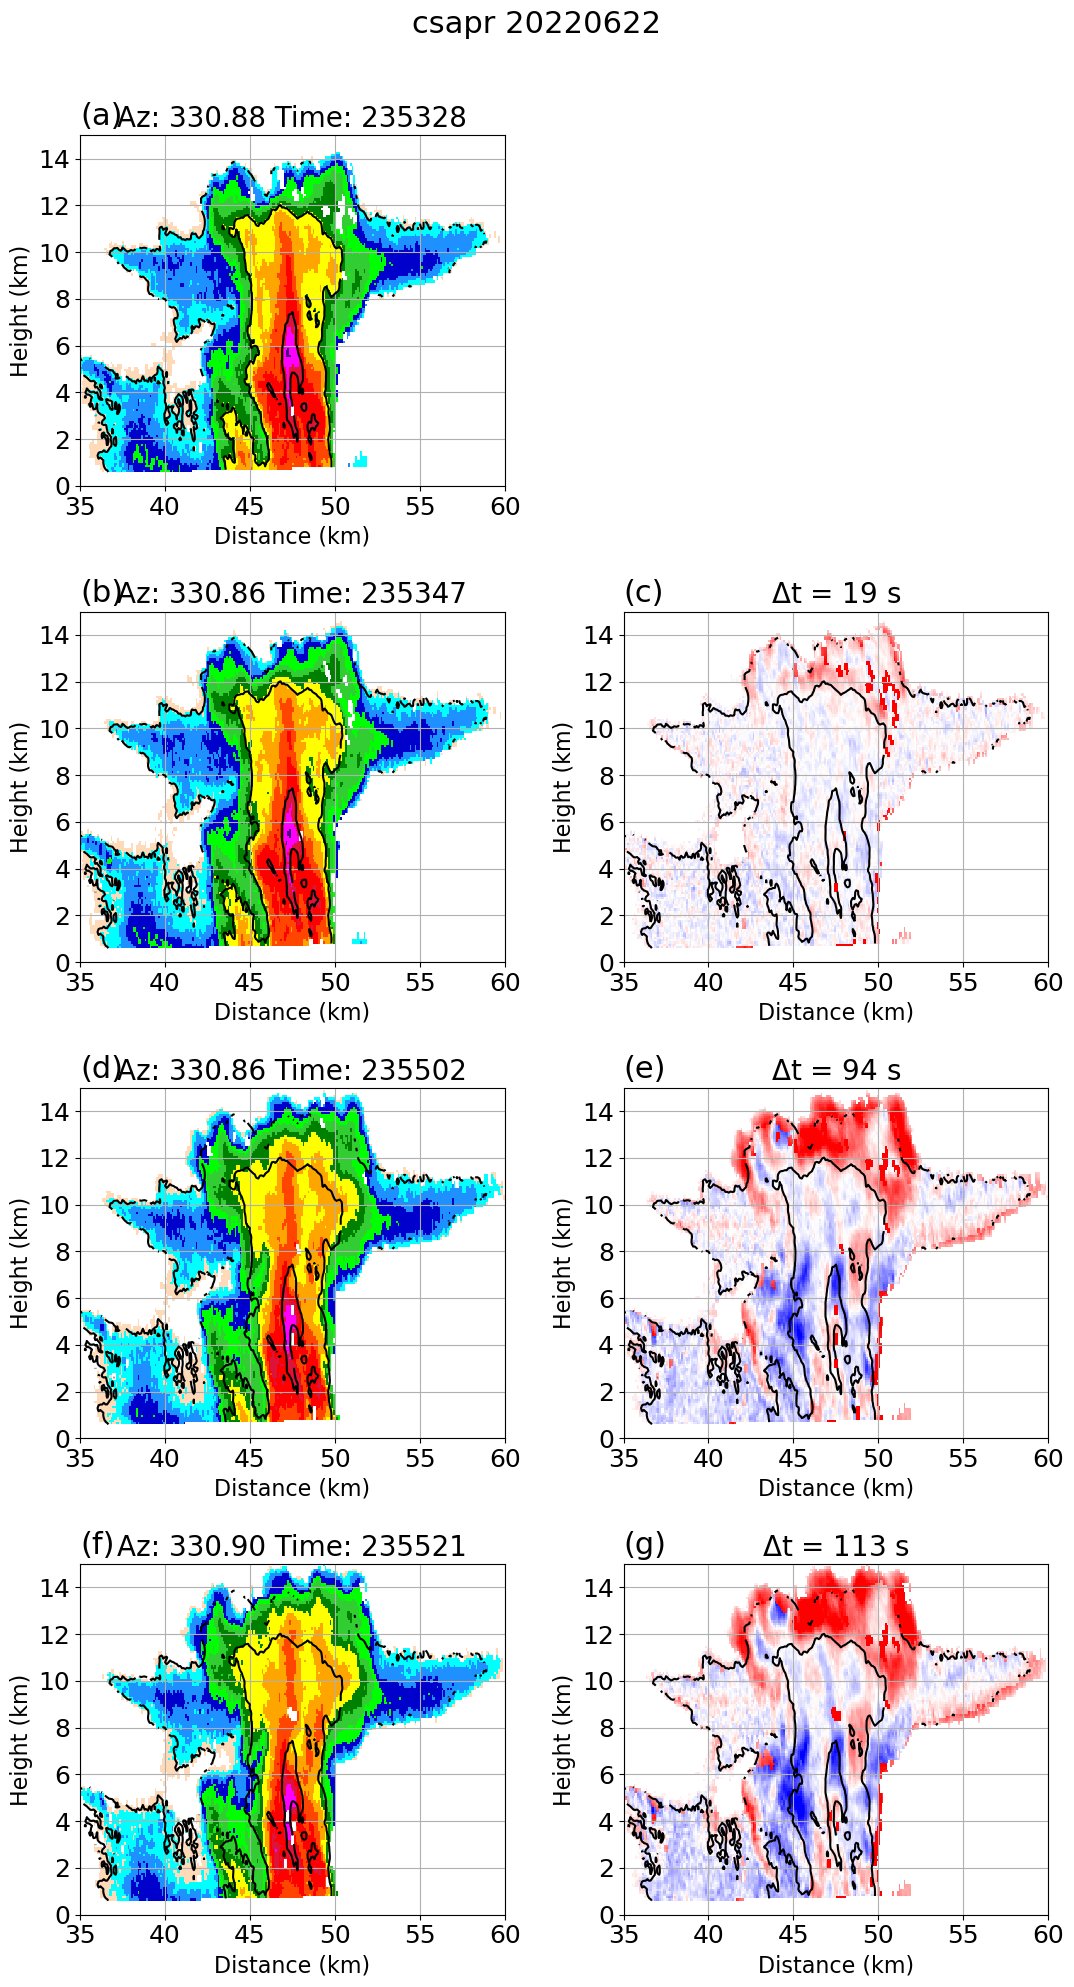

In [23]:
import matplotlib.ticker as ticker
datlist = []
for k in mkeys:
    nfiles = matchsets[k]['nfiles']
    f1 = matchsets[k]['file0']
    print(f1)
    gn1 = f1['rhi']
    smatss = f1['ss']
    gfile1 = scansets[f1['ss']][f'{gn1}_gfile1']
    gaz1 = scansets[f1['ss']][f'{gn1}_az']
    gtm1 = scansets[f1['ss']][f'{gn1}_time']

    #chivo_0 = get_data(scansets,chivo_scanset,chivo_0_rhi)
    chivorhi0grid = xr.open_dataset(gfile1)
    crhi0slant1=get_sdat(chivorhi0grid,az = gaz1 ,radar=radar)
    crhi0slant1=IH.get_echo_data(crhi0slant1)
    datlist.append(crhi0slant1)

    f2 = matchsets[k]['file1']
    gn2 = f2['rhi']
    gfile2 = scansets[f2['ss']][f'{gn2}_gfile1']
    gaz2 = scansets[f2['ss']][f'{gn2}_az']
    gtm2 = scansets[f2['ss']][f'{gn2}_time']
    chivorhi1grid = xr.open_dataset(gfile2)
    crhi1slant1=get_sdat(chivorhi1grid,az = gaz2 ,radar=radar )
    crhi1slant1=IH.get_echo_data(crhi1slant1)
    rhi0_1_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi1slant1)
    datlist.append(crhi1slant1)

    if nfiles >=3:
        f3 = matchsets[k]['file2']
        gn3 = f3['rhi']
        gfile3 = scansets[f3['ss']][f'{gn3}_gfile1']
        gaz3 = scansets[f3['ss']][f'{gn3}_az']
        gtm3 = scansets[f3['ss']][f'{gn3}_time']
        chivorhi2grid = xr.open_dataset(gfile3)
        crhi2slant1=get_sdat(chivorhi2grid,az = gaz3 ,radar=radar )
        crhi2slant1=IH.get_echo_data(crhi2slant1)
        rhi0_2_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi2slant1)
        datlist.append(crhi2slant1)

    if nfiles >=4:
        f4 = matchsets[k]['file3']
        gn4 = f4['rhi']
        gfile4 = scansets[f4['ss']][f'{gn4}_gfile1']
        gaz4 = scansets[f4['ss']][f'{gn4}_az']
        gtm4 = scansets[f4['ss']][f'{gn4}_time']
        chivorhi3grid = xr.open_dataset(gfile4)
        crhi3slant1=get_sdat(chivorhi3grid,az = gaz4 ,radar=radar )
        crhi3slant1=IH.get_echo_data(crhi3slant1)
        rhi0_3_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi3slant1)
        datlist.append(crhi3slant1)


    if nfiles >=5:
        f5 = matchsets[k]['file4']
        gn5 = f5['rhi']
        gfile5 = scansets[f5['ss']][f'{gn5}_gfile1']
        gaz5 = scansets[f5['ss']][f'{gn5}_az']
        gtm5 = scansets[f5['ss']][f'{gn5}_time']
        chivorhi4grid = xr.open_dataset(gfile5)
        crhi4slant1=get_sdat(chivorhi4grid,az = gaz5 ,radar=radar )
        crhi4slant1=IH.get_echo_data(crhi4slant1)
        rhi0_4_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi4slant1)
        datlist.append(crhi4slant1)

    if nfiles >=6:
        f6 = matchsets[k]['file5']
        gn6 = f6['rhi']
        gfile6 = scansets[f6['ss']][f'{gn6}_gfile1']
        gaz6 = scansets[f6['ss']][f'{gn6}_az']
        gtm6 = scansets[f6['ss']][f'{gn6}_time']
        chivorhi5grid = xr.open_dataset(gfile6)
        crhi5slant1=get_sdat(chivorhi5grid,az = gaz5 ,radar=radar )
        crhi5slant1=IH.get_echo_data(crhi4slant1)
        rhi0_5_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi5slant1)
        datlist.append(crhi5slant1)


    if nfiles >=7:
        f7 = matchsets[k]['file6']
        gn7 = f7['rhi']
        gfile7 = scansets[f7['ss']][f'{gn7}_gfile1']
        gaz7 = scansets[f7['ss']][f'{gn7}_az']
        gtm7 = scansets[f7['ss']][f'{gn7}_time']
        chivorhi6grid = xr.open_dataset(gfile5)
        crhi6slant1=get_sdat(chivorhi6grid,az = gaz7 ,radar=radar )
        crhi6slant1=IH.get_echo_data(crhi6slant1)
        rhi0_6_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi6slant1)
        datlist.append(crhi6slant1)






    aspectx = nfiles*2.8
    aspecty = nfiles*5
    axes_used = []
    fig, ax = plt.subplots(nfiles,2, figsize=(aspectx,aspecty))
    axf = ax.flatten()
   
    ylim = [0,15]
    f = 0
    axes_used.append(f)
    plot_dz(crhi0slant1,axf[f])
    
    f=f+1
    axf[f].axis('off')


    f= f+1
    axes_used.append(f)
    plot_dz(crhi1slant1,axf[f])
    f = f+2
    if nfiles >=3:
        plot_dz(crhi2slant1,axf[f])
        axes_used.append(f)
        f = f+2
    if nfiles >=4:
        plot_dz(crhi3slant1,axf[f])
        axes_used.append(f)
        f = f+2
        
    if nfiles >=5:
        plot_dz(crhi4slant1,axf[f])
        axes_used.append(f)
        f = f+2

    if nfiles >=6:
        plot_dz(crhi5slant1,axf[f])
        axes_used.append(f)
        f = f+2
    if nfiles >=7:
        plot_dz(crhi6slant1,axf[f])
        axes_used.append(f)
        f = f+2

    #plot_diff(rhi0_3_diff1,axf[0])

    
    #f=f+1
    f=3
    plot_diff(rhi0_1_diff1,axf[f])
    axes_used.append(f)
    f=f+2
    if nfiles >=3:
        plot_diff(rhi0_2_diff1,axf[f])
        axes_used.append(f)
        f=f+2
    if nfiles >=4:
        plot_diff(rhi0_3_diff1,axf[f])
        axes_used.append(f)
        f=f+2
    if nfiles >=5:
        plot_diff(rhi0_4_diff1,axf[f])
        axes_used.append(f)
        f=f+2
    if nfiles >=6:
        plot_diff(rhi0_5_diff1,axf[f])
        axes_used.append(f)
        f=f+2

    if nfiles >=7:
        plot_diff(rhi0_6_diff1,axf[f])
        axes_used.append(f)
        f=f+2


    print(f'{nfiles} for {k}')

    for a in axes_used:
        axf[a].set_xlim(xlim)
        axf[a].set_ylim(ylim)
        axf[a].xaxis.set_major_locator(ticker.MultipleLocator(5))
        axf[a].set_ylabel('Height (km)',fontsize=16)
        axf[a].yaxis.set_major_locator(ticker.MultipleLocator(2))
        axf[a].set_xlabel('Distance (km)',fontsize=16)
        axf[a].grid()
        axf[a].contour(crhi0slant1['y'],crhi0slant1['z'],crhi0slant1['dz'],levels=[-20,-10,5,35,55],colors=['k'],linestyles=['-'])
    plt.suptitle(f'{radar} {date}',y=1.0,fontsize=22)
    plt.tight_layout()
    label_subplots_skip(fig, nlabels=len(axes_used)+1,yoff=0.005)
    plt.savefig(f'{figdir}{radar}_{date}_{smatss}_{k}_{nfiles}.png',bbox_inches='tight',dpi=500,facecolor='white')
#plt.clf()
    


In [24]:
mask = create_mask(datlist)

In [25]:
dumdat = np.zeros_like(mask)
dumdat[mask>2] = 1

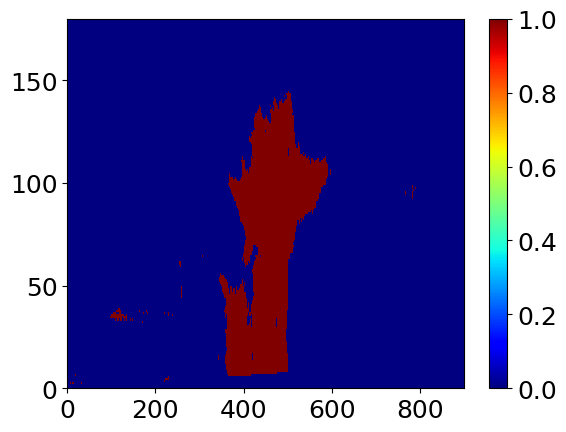

In [26]:
c =plt.pcolormesh(dumdat,vmin=0,vmax=1,cmap='jet')
plt.colorbar(c)


In [27]:
mask=dumdat

{'time': datetime.datetime(2022, 6, 22, 23, 53, 28), 'az': 330.88074, 'ss': '147', 'rhi': 'rhi1'}
Bbox(x0=0.5477272727272726, y0=0.7126086956521739, x1=0.8999999999999999, y1=0.88)
4 for 362


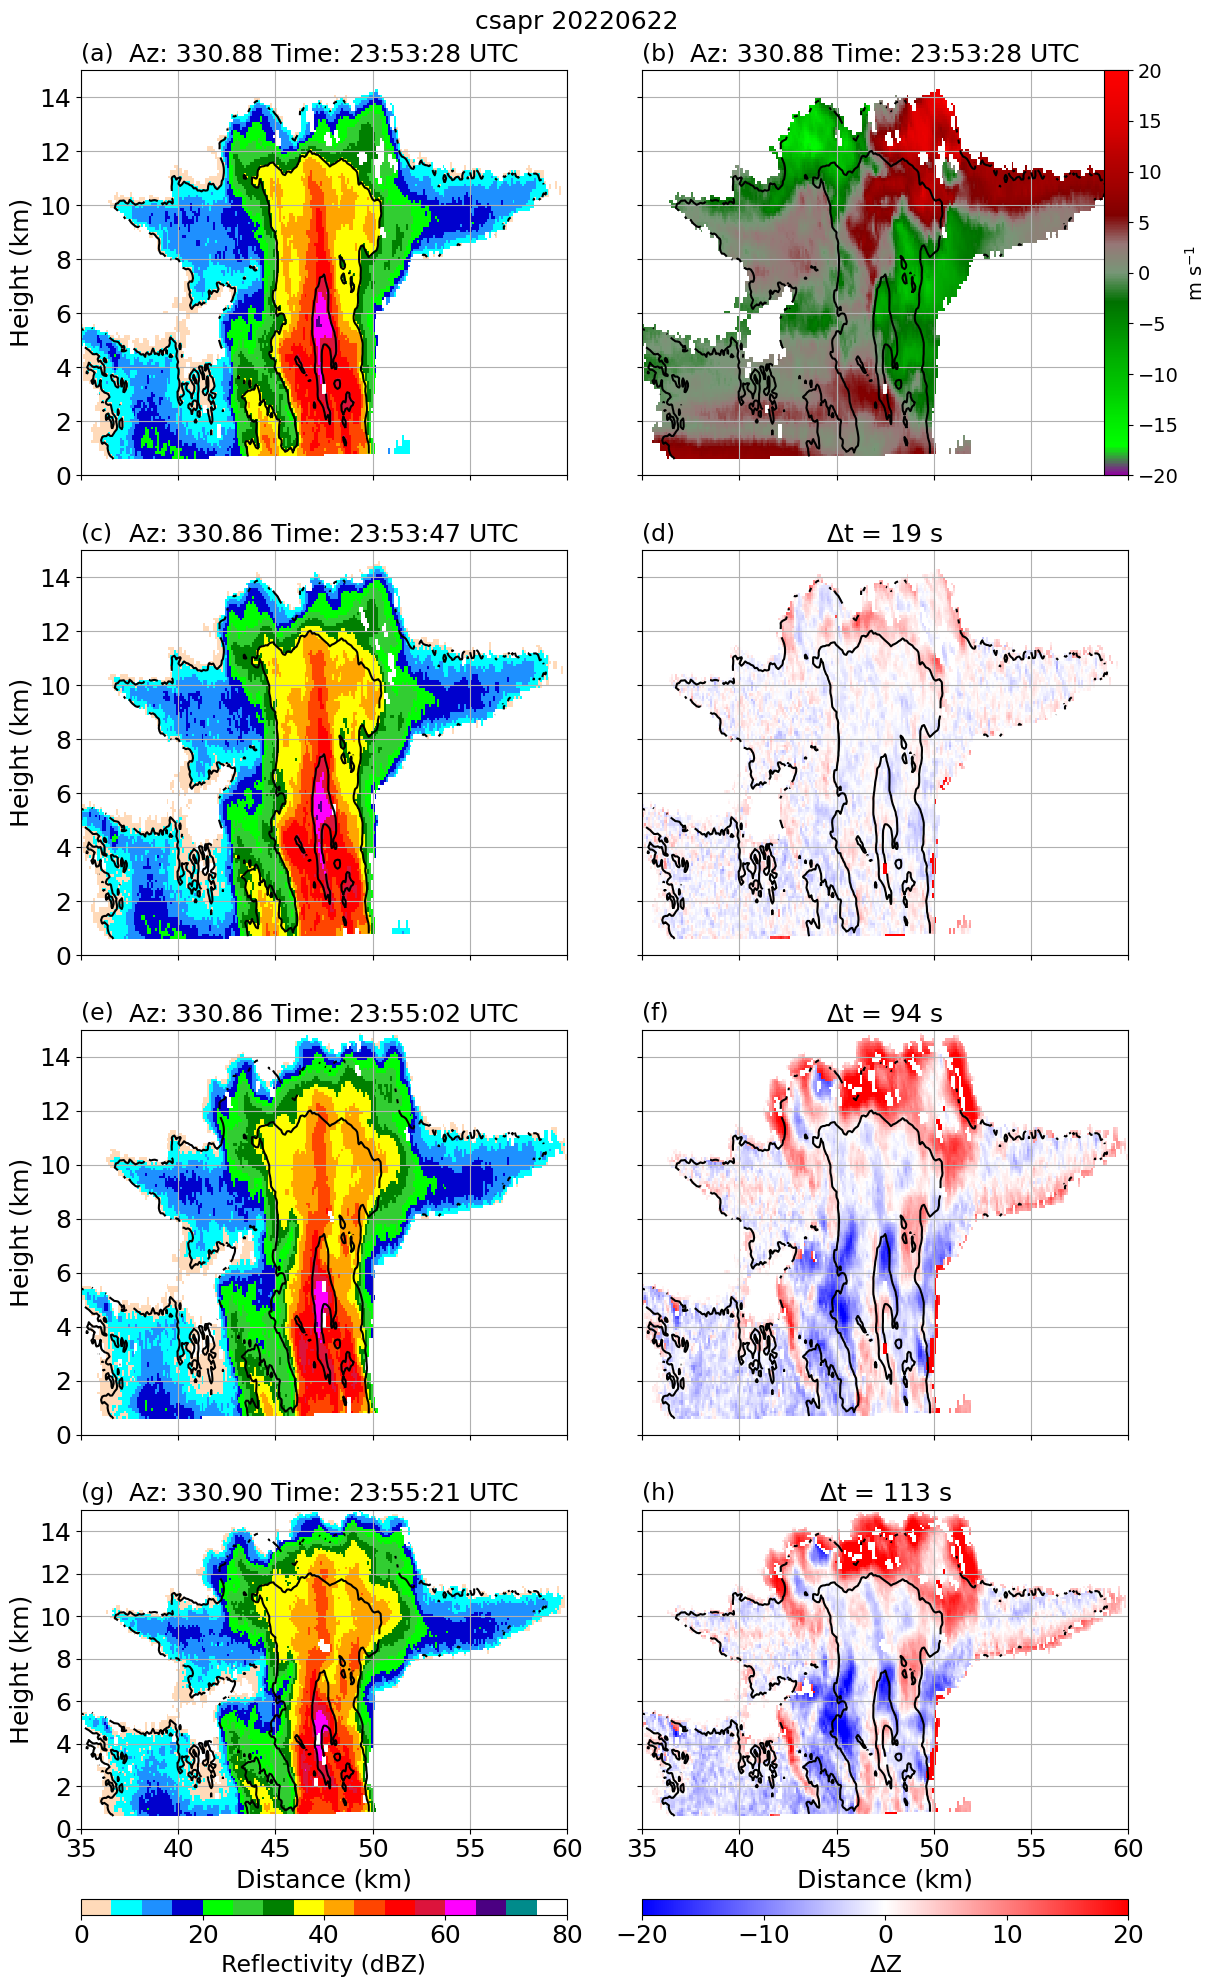

In [68]:
import matplotlib.ticker as ticker
for k in mkeys:
    nfiles = matchsets[k]['nfiles']
    f1 = matchsets[k]['file0']
    print(f1)
    gn1 = f1['rhi']
    smatss = f1['ss']
    gfile1 = scansets[f1['ss']][f'{gn1}_gfile1']
    gaz1 = scansets[f1['ss']][f'{gn1}_az']
    gtm1 = scansets[f1['ss']][f'{gn1}_time']

    #chivo_0 = get_data(scansets,chivo_scanset,chivo_0_rhi)
    chivorhi0grid = xr.open_dataset(gfile1)
    crhi0slant1=get_sdat(chivorhi0grid,az = gaz1 ,radar=radar)
    crhi0slant1=IH.get_echo_data(crhi0slant1)

    f2 = matchsets[k]['file1']
    gn2 = f2['rhi']
    gfile2 = scansets[f2['ss']][f'{gn2}_gfile1']
    gaz2 = scansets[f2['ss']][f'{gn2}_az']
    gtm2 = scansets[f2['ss']][f'{gn2}_time']
    chivorhi1grid = xr.open_dataset(gfile2)
    crhi1slant1=get_sdat(chivorhi1grid,az = gaz2 ,radar=radar )
    crhi1slant1=IH.get_echo_data(crhi1slant1)
    rhi0_1_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi1slant1)

    if nfiles >=3:
        f3 = matchsets[k]['file2']
        gn3 = f3['rhi']
        gfile3 = scansets[f3['ss']][f'{gn3}_gfile1']
        gaz3 = scansets[f3['ss']][f'{gn3}_az']
        gtm3 = scansets[f3['ss']][f'{gn3}_time']
        chivorhi2grid = xr.open_dataset(gfile3)
        crhi2slant1=get_sdat(chivorhi2grid,az = gaz3 ,radar=radar )
        crhi2slant1=IH.get_echo_data(crhi2slant1)
        rhi0_2_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi2slant1)

    if nfiles >=4:
        f4 = matchsets[k]['file3']
        gn4 = f4['rhi']
        gfile4 = scansets[f4['ss']][f'{gn4}_gfile1']
        gaz4 = scansets[f4['ss']][f'{gn4}_az']
        gtm4 = scansets[f4['ss']][f'{gn4}_time']
        chivorhi3grid = xr.open_dataset(gfile4)
        crhi3slant1=get_sdat(chivorhi3grid,az = gaz4 ,radar=radar )
        crhi3slant1=IH.get_echo_data(crhi3slant1)
        rhi0_3_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi3slant1)


    if nfiles >=5:
        f5 = matchsets[k]['file4']
        gn5 = f5['rhi']
        gfile5 = scansets[f5['ss']][f'{gn5}_gfile1']
        gaz5 = scansets[f5['ss']][f'{gn5}_az']
        gtm5 = scansets[f5['ss']][f'{gn5}_time']
        chivorhi4grid = xr.open_dataset(gfile5)
        crhi4slant1=get_sdat(chivorhi4grid,az = gaz5 ,radar=radar )
        crhi4slant1=IH.get_echo_data(crhi4slant1)
        rhi0_4_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi4slant1)

    if nfiles >=6:
        f6 = matchsets[k]['file5']
        gn6 = f6['rhi']
        gfile6 = scansets[f6['ss']][f'{gn6}_gfile1']
        gaz6 = scansets[f6['ss']][f'{gn6}_az']
        gtm6 = scansets[f6['ss']][f'{gn6}_time']
        chivorhi5grid = xr.open_dataset(gfile6)
        crhi5slant1=get_sdat(chivorhi5grid,az = gaz5 ,radar=radar )
        crhi5slant1=IH.get_echo_data(crhi4slant1)
        rhi0_5_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi5slant1)


    if nfiles >=7:
        f7 = matchsets[k]['file6']
        gn7 = f7['rhi']
        gfile7 = scansets[f7['ss']][f'{gn7}_gfile1']
        gaz7 = scansets[f7['ss']][f'{gn7}_az']
        gtm7 = scansets[f7['ss']][f'{gn7}_time']
        chivorhi6grid = xr.open_dataset(gfile5)
        crhi6slant1=get_sdat(chivorhi6grid,az = gaz7 ,radar=radar )
        crhi6slant1=IH.get_echo_data(crhi6slant1)
        rhi0_6_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi6slant1)






    aspectx = nfiles*3
    aspecty = nfiles*5
    axes_used = []
    fig, ax = plt.subplots(nfiles,2, figsize=(aspectx,aspecty))
    axf = ax.flatten()
   
    ylim = [0,15]
    f = 0
    axes_used.append(f)
    cbdz = plot_dz(crhi0slant1,axf[f])
    
    f=f+1
#    axf[f].axis('off')
    axes_used.append(f)
    plot_ve(crhi0slant1,axf[f])


    f= f+1
    axes_used.append(f)
    cbdz = plot_dz(crhi1slant1,axf[f])
    f = f+2
    if nfiles >=3:
        if nfiles == 3:
            cbdz = plot_dz(crhi2slant1,axf[f],cb_on=False)
        else:
            cbdz = plot_dz(crhi2slant1,axf[f])
        axes_used.append(f)
        f = f+2
    if nfiles >=4:
        if nfiles == 4:
            cbdz = plot_dz(crhi3slant1,axf[f],cb_on=False)
        else:
            cbdz = plot_dz(crhi3slant1,axf[f])
        axes_used.append(f)
        f = f+2
        
    if nfiles >=5:
        if nfiles == 5:
            cbdz = plot_dz(crhi4slant1,axf[f],cb_on=False)
        else:
            cbdz = plot_dz(crhi4slant1,axf[f])
        axes_used.append(f)
        f = f+2

    if nfiles >=6:
        if nfiles == 6:
            cbdz = plot_dz(crhi5slant1,axf[f],cb_on=False)
        else:
            cbdz = plot_dz(crhi5slant1,axf[f])
        axes_used.append(f)
        f = f+2
    if nfiles >=7:
        if nfiles == 7:
            cbdz = plot_dz(crhi6slant1,axf[f],cb_on=False)
        else:
            cbdz = plot_dz(crhi6slant1,axf[f])
        axes_used.append(f)
        f = f+2

    #plot_diff(rhi0_3_diff1,axf[0])

    
    #f=f+1
    f=3
    cdiff = plot_diff(rhi0_1_diff1,axf[f],mask_on = True, mask=mask,cb_on=False)
    axes_used.append(f)
    f=f+2
    if nfiles >=3:
        if nfiles == 3:
            cdiff = plot_diff(rhi0_2_diff1,axf[f],mask_on = True, mask=mask,cb_on=False)
        else:
            cdiff = plot_diff(rhi0_2_diff1,axf[f],mask_on = True, mask=mask)
        axes_used.append(f)
        f=f+2
    if nfiles >=4:
        if nfiles == 4:
            cdiff = plot_diff(rhi0_3_diff1,axf[f],mask_on = True, mask=mask,cb_on=False)
        else:
            cdiff = plot_diff(rhi0_3_diff1,axf[f],mask_on = True, mask=mask)
        axes_used.append(f)
        f=f+2
    if nfiles >=5:
        if nfiles == 5:
            cdiff = plot_diff(rhi0_4_diff1,axf[f],mask_on = True, mask=mask,cb_on=False)
        else:
            cdiff = plot_diff(rhi0_4_diff1,axf[f],mask_on = True, mask=mask)
        axes_used.append(f)
        f=f+2
    if nfiles >=6:
        if nfiles == 6:
            cdiff = plot_diff(rhi0_5_diff1,axf[f],mask_on = True, mask=mask,cb_on=False)
        else:
            cdiff = plot_diff(rhi0_5_diff1,axf[f],mask_on = True, mask=mask)
        axes_used.append(f)
        f=f+2

    if nfiles >=7:
        if nfiles == 7:
            cdiff = plot_diff(rhi0_6_diff1,axf[f],mask_on = True, mask=mask,cb_on=False)
        else:
            cdiff = plot_diff(rhi0_6_diff1,axf[f],mask_on = True, mask=mask)
        axes_used.append(f)
        f=f+2


    print(f'{nfiles} for {k}')

    for a in axes_used:
        axf[a].set_xlim(xlim)
        axf[a].set_ylim(ylim)
        axf[a].xaxis.set_major_locator(ticker.MultipleLocator(5))
        #axf[a].set_ylabel('Height (km)',fontsize=16)
        axf[a].yaxis.set_major_locator(ticker.MultipleLocator(2))
        #axf[a].set_xlabel('Distance (km)',fontsize=16)
        axf[a].grid()


        if a in np.arange(0,len(axes_used),2):
            axf[a].set_ylabel('Height (km)',fontsize=18)
        if a in np.arange(1,len(axes_used),2):
            axf[a].yaxis.set_tick_params(labelleft=False)

        if a in np.arange(len(axes_used)-2,len(axes_used)+1,1):
            axf[a].set_xlabel('Distance (km)',fontsize=18)
        if a in np.arange(0,len(axes_used)-2,1):
            axf[a].xaxis.set_tick_params(labelbottom=False)

        axf[a].contour(crhi0slant1['y'],crhi0slant1['z'],crhi0slant1['dz'],levels=[-20,-10,5,35,55],colors=['k'],linestyles=['-'])
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(axf[-2])
    cax = divider.new_vertical(size='5%', pad=0.7, pack_start = True)
    fig.add_axes(cax)
    cbz = fig.colorbar(cbdz,cax=cax, orientation = 'horizontal')
    cbz.set_label('Reflectivity (dBZ)',fontsize = 17)

    divider2 = make_axes_locatable(axf[-1])
    cdax = divider2.new_vertical(size='5%', pad=0.7, pack_start = True)
    fig.add_axes(cdax)
    cbd = fig.colorbar(cdiff,cax=cdax, orientation = 'horizontal')
    cbd.set_label('$\Delta$Z',fontsize=17)
    
    plt.tight_layout()
    plt.suptitle(f'{radar} {date}',y=1.0,fontsize=18)
    label_subplots(fig, nlabels=len(axes_used),yoff=0.005)
    plt.savefig(f'{figdir}{radar}_{date}_{smatss}_{k}_{nfiles}_withVR.png',bbox_inches='tight',dpi=500,facecolor='white')
#plt.clf()
    


4 for 362


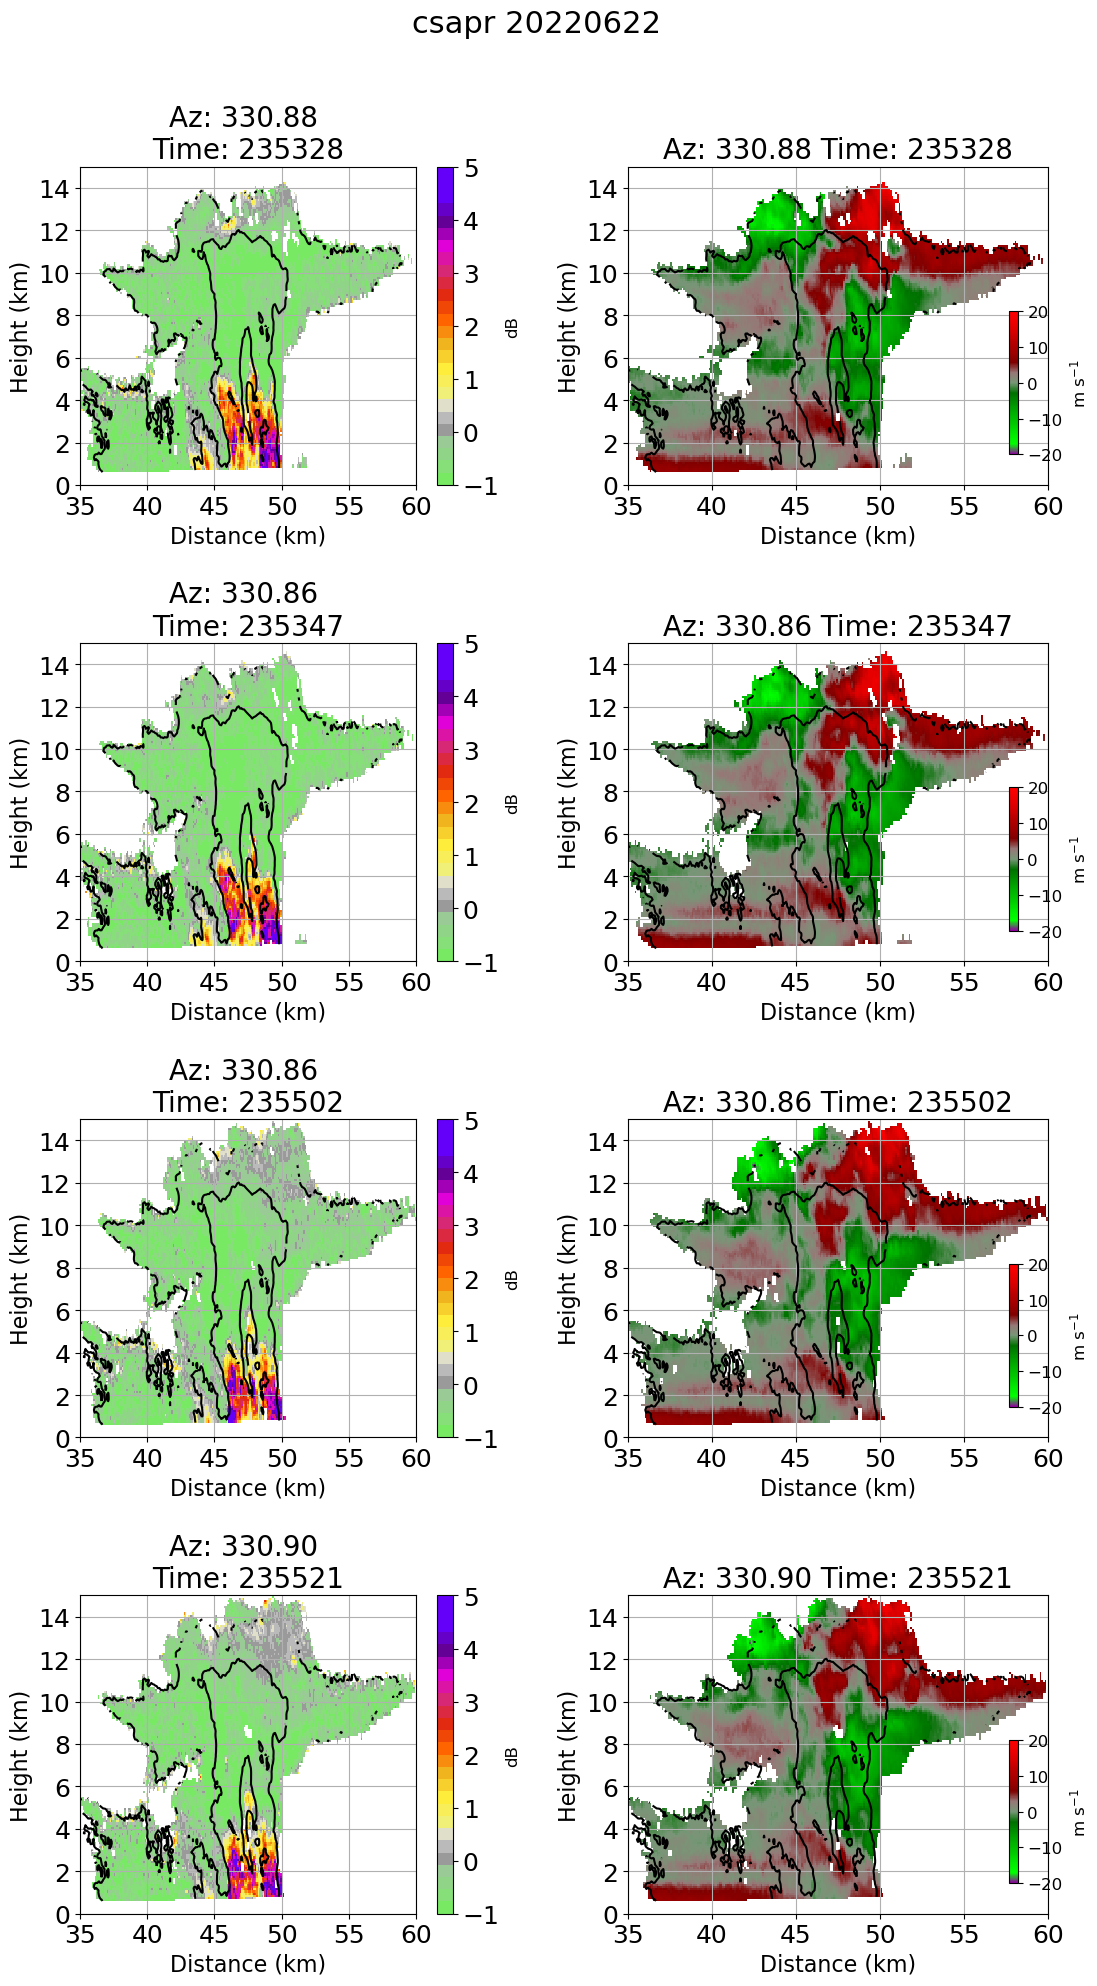

In [29]:
import matplotlib.ticker as ticker


aspectx = nfiles*2.8
aspecty = nfiles*5
axes_used = []
fig, ax = plt.subplots(nfiles,2, figsize=(aspectx,aspecty))
axf = ax.flatten()

ylim = [0,15]
f = 0
axes_used.append(f)
plot_dr(crhi0slant1,axf[f])

f=f+1
# axf[f].axis('off')


f= f+1
axes_used.append(f)
plot_dr(crhi1slant1,axf[f])
f = f+2
if nfiles >=3:
    plot_dr(crhi2slant1,axf[f])
    axes_used.append(f)
    f = f+2
if nfiles >=4:
    plot_dr(crhi3slant1,axf[f])
    axes_used.append(f)
    f = f+2
    
if nfiles >=5:
    plot_dr(crhi4slant1,axf[f])
    axes_used.append(f)
    f = f+2

if nfiles >=6:
    plot_dr(crhi5slant1,axf[f])
    axes_used.append(f)
    f = f+2
if nfiles >=7:
    plot_dr(crhi6slant1,axf[f])
    axes_used.append(f)
    f = f+2

#plot_diff(rhi0_3_diff1,axf[0])

f=1
#f=f+1
axes_used.append(f)
plot_ve(crhi0slant1,axf[f])

# f=f+1
# axf[f].axis('off')


f= f+2
axes_used.append(f)
plot_ve(crhi1slant1,axf[f])
f = f+2
if nfiles >=3:
    plot_ve(crhi2slant1,axf[f])
    axes_used.append(f)
    f = f+2
if nfiles >=4:
    plot_ve(crhi3slant1,axf[f])
    axes_used.append(f)
    f = f+2
    
if nfiles >=5:
    plot_ve(crhi4slant1,axf[f])
    axes_used.append(f)
    f = f+2

if nfiles >=6:
    plot_ve(crhi5slant1,axf[f])
    axes_used.append(f)
    f = f+2
if nfiles >=7:
    plot_ve(crhi6slant1,axf[f])
    axes_used.append(f)
    f = f+2

#plot_diff(rhi0_3_diff1,axf[0])




print(f'{nfiles} for {k}')

for a in axes_used:
    axf[a].set_xlim(xlim)
    axf[a].set_ylim(ylim)
    axf[a].xaxis.set_major_locator(ticker.MultipleLocator(5))
    axf[a].set_ylabel('Height (km)',fontsize=16)
    axf[a].yaxis.set_major_locator(ticker.MultipleLocator(2))
    axf[a].set_xlabel('Distance (km)',fontsize=16)
    axf[a].grid()
    axf[a].contour(crhi0slant1['y'],crhi0slant1['z'],crhi0slant1['dz'],levels=[-20,-10,5,35,55],colors=['k'],linestyles=['-'])
plt.suptitle(f'{radar} {date}',y=1.0,fontsize=22)
plt.tight_layout()

plt.savefig(f'{figdir}{radar}_{date}_{smatss}_{k}_{nfiles}_dr.png',bbox_inches='tight',dpi=500,facecolor='white')
#plt.clf()
    


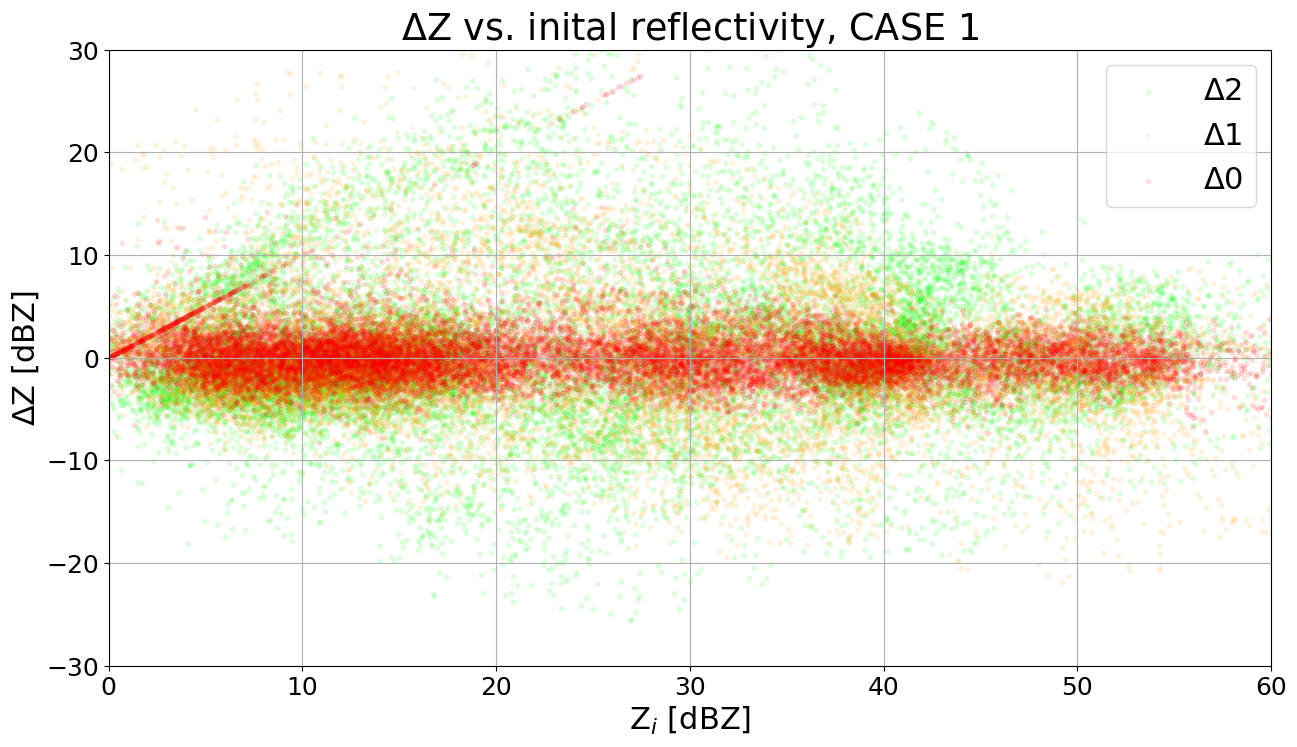

In [30]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
plt.scatter(crhi2slant1['dz'],rhi0_3_diff1['dzdiff'],marker='.',alpha=0.1,color='lime',label=f'$\Delta$2')
plt.scatter(crhi1slant1['dz'],rhi0_2_diff1['dzdiff'],marker='.',alpha=0.1,color='orange',label=f'$\Delta$1')
plt.scatter(crhi0slant1['dz'],rhi0_1_diff1['dzdiff'],marker='.',alpha=0.1,color='red',label=f'$\Delta$0')
plt.xlim(0,60)
plt.ylim(-30,30)
plt.legend()
plt.grid()
plt.xlabel('Z$_i$ [dBZ]')
plt.ylabel('$\Delta$Z [dBZ]')
plt.title(f'$\Delta$Z vs. inital reflectivity, CASE 1')

plt.savefig(f"{figdir}{radar}_{date}_delZ_case1Scatter.png",bbox_inches='tight',dpi=500,facecolor='white')


0.36823556


(-30.0, 30.0)

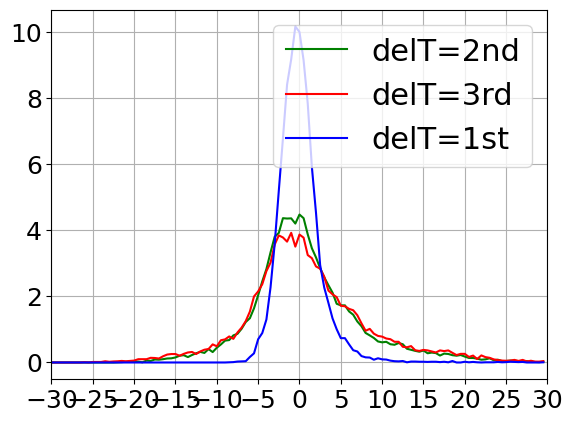

In [31]:
hist, eg = np.histogram(rhi0_1_diff1['dzdiff'],bins=np.arange(-30,30.1,0.5))
hist2, eg = np.histogram(rhi0_2_diff1['dzdiff'],bins=np.arange(-30,30.1,0.5))
hist3, eg = np.histogram(rhi0_3_diff1['dzdiff'],bins=np.arange(-30,30.1,0.5))
plt.grid()
print(np.nanmean(rhi0_1_diff1['dzdiff']))

plt.plot(eg[:-1],hist2/np.sum(hist2)*100.,color='green',label='delT=2nd')
plt.plot(eg[:-1],hist3/np.sum(hist3)*100.,color='red',label='delT=3rd')
plt.plot(eg[:-1],hist/np.sum(hist)*100.,color='blue',label='delT=1st')
plt.legend()
plt.xticks(np.arange(-30,30.5,5))
plt.xlim(-30,30)

(35.0, 60.0)

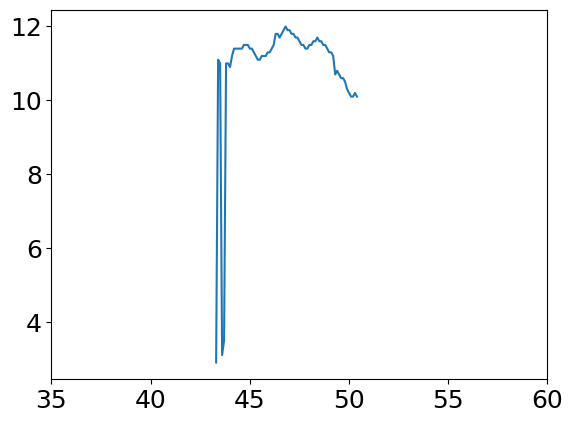

In [32]:
plt.plot(crhi0slant1['y'], crhi0slant1['eth_35'])
plt.xlim(35,60)

In [33]:
print("RHI0")

print(np.nanmax(crhi0slant1['eth_35']))
print(np.nanmax(crhi0slant1['eth_55']))
print(np.nanmax(crhi0slant1['eth_0']))

print('RHI1')

print(np.nanmax(crhi1slant1['eth_35']))
print(np.nanmax(crhi1slant1['eth_55']))
print(np.nanmax(crhi1slant1['eth_0']))

print('RHI2')

print(np.nanmax(crhi2slant1['eth_35']))
print(np.nanmax(crhi2slant1['eth_55']))
print(np.nanmax(crhi2slant1['eth_0']))

RHI0
12.0
7.4
14.2
RHI1
12.1
7.4
14.5
RHI2
13.0
6.7
14.8


In [34]:
def make_cfad(diffdz, z):
    cfad = []
    for i,lev in enumerate(z):
        dum = np.squeeze(diffdz[i])
        dum2 = dum[~np.isnan(dum)] 
        lev_hist, edg = np.histogram(dum2,bins=np.arange(-30,30.1,0.5))
        norm_hist= lev_hist/(np.sum(lev_hist))*100
        cfad.append(norm_hist)
    
    return np.array(cfad),edg



In [35]:
cfad1, edg = make_cfad(rhi0_1_diff1['dzdiff'],rhi0_1_diff1['rhi1hgt'])
cfad2, edg = make_cfad(rhi0_2_diff1['dzdiff'],rhi0_2_diff1['rhi1hgt'])
cfad3, edg = make_cfad(rhi0_3_diff1['dzdiff'],rhi0_3_diff1['rhi1hgt'])


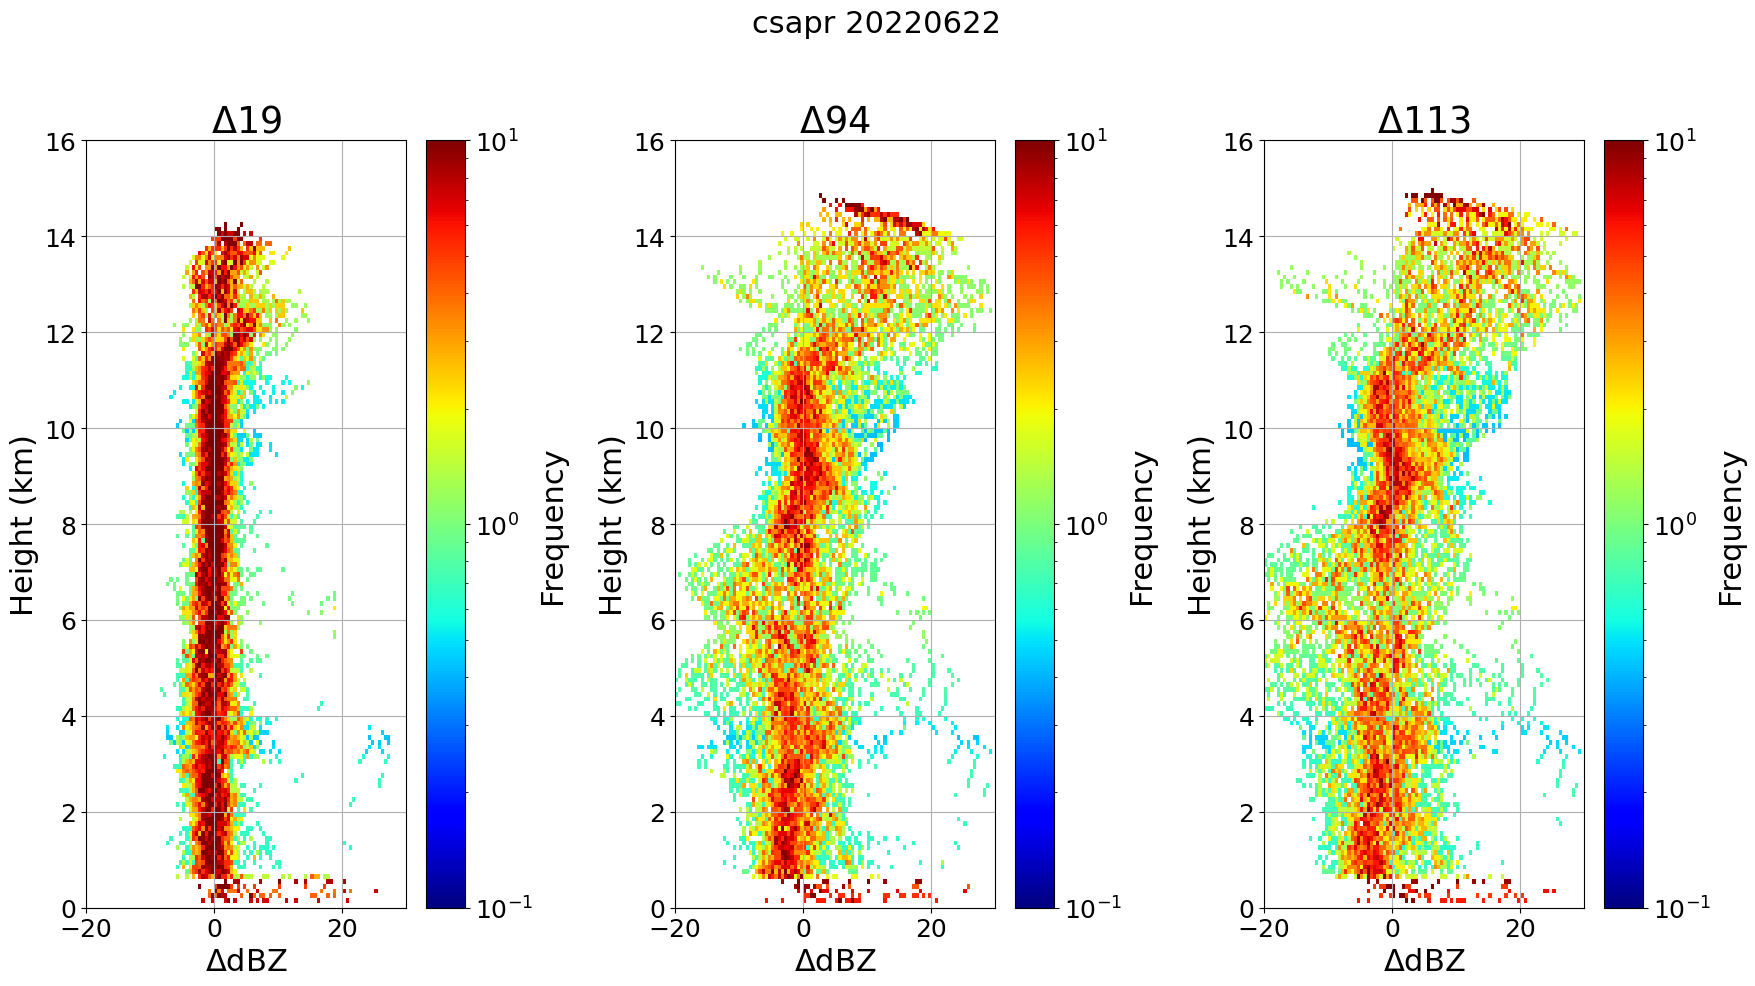

In [36]:
fig, ax = plt.subplots(1,3,figsize=(18,10))
axf=ax.flatten()
norm = colors.LogNorm(vmin=1e-1, vmax=10)
cfad1_ma = np.ma.masked_where(cfad1==0, cfad1)
cfad2_ma = np.ma.masked_where(cfad2==0, cfad2)
cfad3_ma = np.ma.masked_where(cfad3==0, cfad3)
#pc = ax.pcolormesh(bins, self.data[self.z_name][bot_index:top_index], cfad_ma, vmin=0, vmax=maxval, norm=norm, **kwargs)
pc = axf[0].pcolormesh(edg[:-1],rhi0_1_diff1['rhi1hgt'] , cfad1_ma,norm=norm,cmap='jet' )
t0=rhi0_1_diff1['delT']
axf[0].set_title(f'$\Delta${t0}')
pc = axf[1].pcolormesh(edg[:-1],rhi0_2_diff1['rhi1hgt'] , cfad2_ma,norm=norm,cmap='jet' )
t1=rhi0_2_diff1['delT']
axf[1].set_title(f'$\Delta${t1}')
pc = axf[2].pcolormesh(edg[:-1],rhi0_3_diff1['rhi1hgt'] , cfad3_ma,norm=norm,cmap='jet' )
t2=rhi0_3_diff1['delT']
axf[2].set_title(f'$\Delta${t2}')

for a in axf:
    a.set_ylim(0,16)
    a.set_xlim(-20,30)
    a.grid()
    a.set_xlabel('$\Delta$dBZ')
    a.set_ylabel('Height (km)')
    cb = plt.colorbar(pc,ax=a)
    cb.set_label("Frequency")


plt.suptitle(f'{radar} {date}',y=1.0,fontsize=22)
plt.tight_layout()

plt.savefig(f'{figdir}{radar}_{date}_delZ_CFAD.png',bbox_inches='tight',dpi=500,facecolor='white')

#.colorbar(pc)
#plt.xlim(-20,20)

147
148


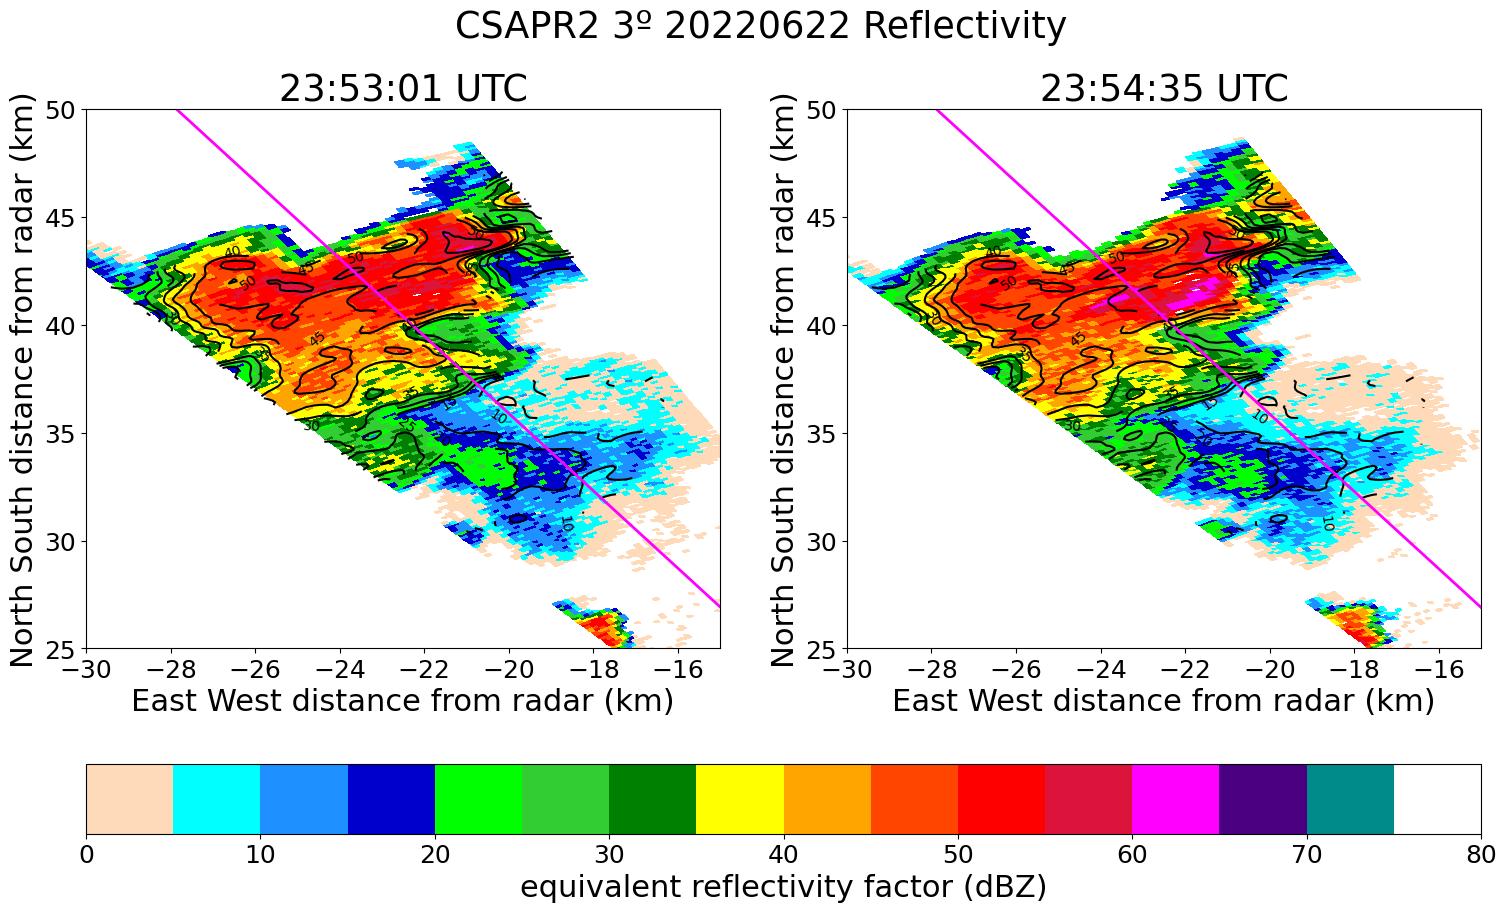

In [83]:
print(f1['ss'])
print(f3['ss'])
pyrad = pyart.io.read(scansets[f1['ss']]['sector'])
pyrad2 = pyart.io.read(scansets[f3['ss']]['sector'])
#fig = plt.figure(figsize=[18, 8])
fig, ax = plt.subplots(1,2,figsize=[18,10])
axf = ax.flatten()
ax = axf[0]#fig.add_subplot(121)
display = pyart.graph.RadarDisplay(pyrad)
display.plot_ppi('reflectivity',2,vmin=0,vmax=80,ax=ax,cmap=configdat.temp_cmap,colorbar_flag=False)
ctm = pyart.util.datetime_from_radar(pyrad)
ctm1 = datetime.strptime(str(ctm),'%Y-%m-%d %H:%M:%S')

ax.set_title(f"{ctm1:%H:%M:%S} UTC")
#display.set_limits([-30,-10],[30,50])
rhiaz2 = crhi0slant1['az']
r = np.arange(0,100,1)
cx2 = np.sin(np.deg2rad(rhiaz2))*r
cy2 = np.cos(np.deg2rad(rhiaz2))*r
ax.plot(cx2,cy2,lw=2,color='fuchsia')
# line commented out to show reflectivity
#display.plot('reflectivity', sweep=sweep, vmin=-0, vmax=45.0, fig=fig,ax=ax)

# get data
sweep =2
import scipy.ndimage as spyi
start = pyrad.get_start(sweep)
end = pyrad.get_end(sweep) + 1
data = pyrad.get_field(sweep, "reflectivity")
x, y, z = pyrad.get_gate_x_y_z(sweep, edges=False)

x /= 1000.0
y /= 1000.0
z /= 1000.0

# smooth out the lines
data = spyi.gaussian_filter(data, sigma=1.2)

# calculate (R)ange
R = np.sqrt(x**2 + y**2) * np.sign(y)
R = -R
#display.set_limits(xlim=[25, 0], ylim=[0, 5])

# add contours
# creates steps 35 to 100 by 5
levels = np.arange(0, 61, 5)
# adds coutours to plot
contours = axf[0].contour(
    x, y, data, levels, linewidths=1.5, colors="k", linestyles="solid", antialiased=True,label=True,
)
ax.clabel(contours, contours.levels, inline=True,fontsize=10)

ax.set_xlim(-30,-15)
ax.set_ylim(25,50)


ax1 =axf[1]#fig.add_subplot(122)
display = pyart.graph.RadarDisplay(pyrad2)
display.plot_ppi('reflectivity',2,vmin=0,vmax=80,cmap=configdat.temp_cmap,ax=axf[1],colorbar_flag=False)
#display.set_limits([-30,-10],[30,50])
rhiaz2 = crhi1slant1['az']
cx2 = np.sin(np.deg2rad(rhiaz2))*r
cy2 = np.cos(np.deg2rad(rhiaz2))*r
ax1.plot(cx2,cy2,lw=2,color='fuchsia')
ctm2 = pyart.util.datetime_from_radar(pyrad2)
ctm3 = datetime.strptime(str(ctm2),'%Y-%m-%d %H:%M:%S')

ax1.set_title(f"{ctm3:%H:%M:%S} UTC")
# line commented out to show reflectivity
#display.plot('reflectivity', sweep=sweep, vmin=-0, vmax=45.0, fig=fig,ax=ax)

# adds coutours to plot
contours = ax1.contour(
    x, y, data, levels, linewidths=1.5, colors="k", linestyles="solid", antialiased=True
)
ax1.clabel(contours, contours.levels, inline=True,fontsize=10)

ax1.set_xlim(-30,-15)
ax1.set_ylim(25,50)


display.plot_colorbar(field='reflectivity',ax=axf[:],orient='horizontal')#,shrink=0.8)#,scale=0.8)
plt.suptitle(f"CSAPR2 3º {ctm3:%Y%m%d} Reflectivity")

plt.savefig(f'{figdir}{radar}_{date}_{smatss}_{k}_PPI1_PPI2.png',bbox_inches='tight',dpi=500,facecolor='white')
#plt

# display = pyart.graph.RadarDisplay(pyrad)
# display.plot_ppi('reflectivity',2,vmin=0,vmax=80,cmap=configdat.temp_cmap)
# display.set_limits([-30,-10],[30,50])

{'time': datetime.datetime(2022, 6, 22, 23, 53, 28), 'az': 330.88074, 'ss': '147', 'rhi': 'rhi1'}
4 for 362


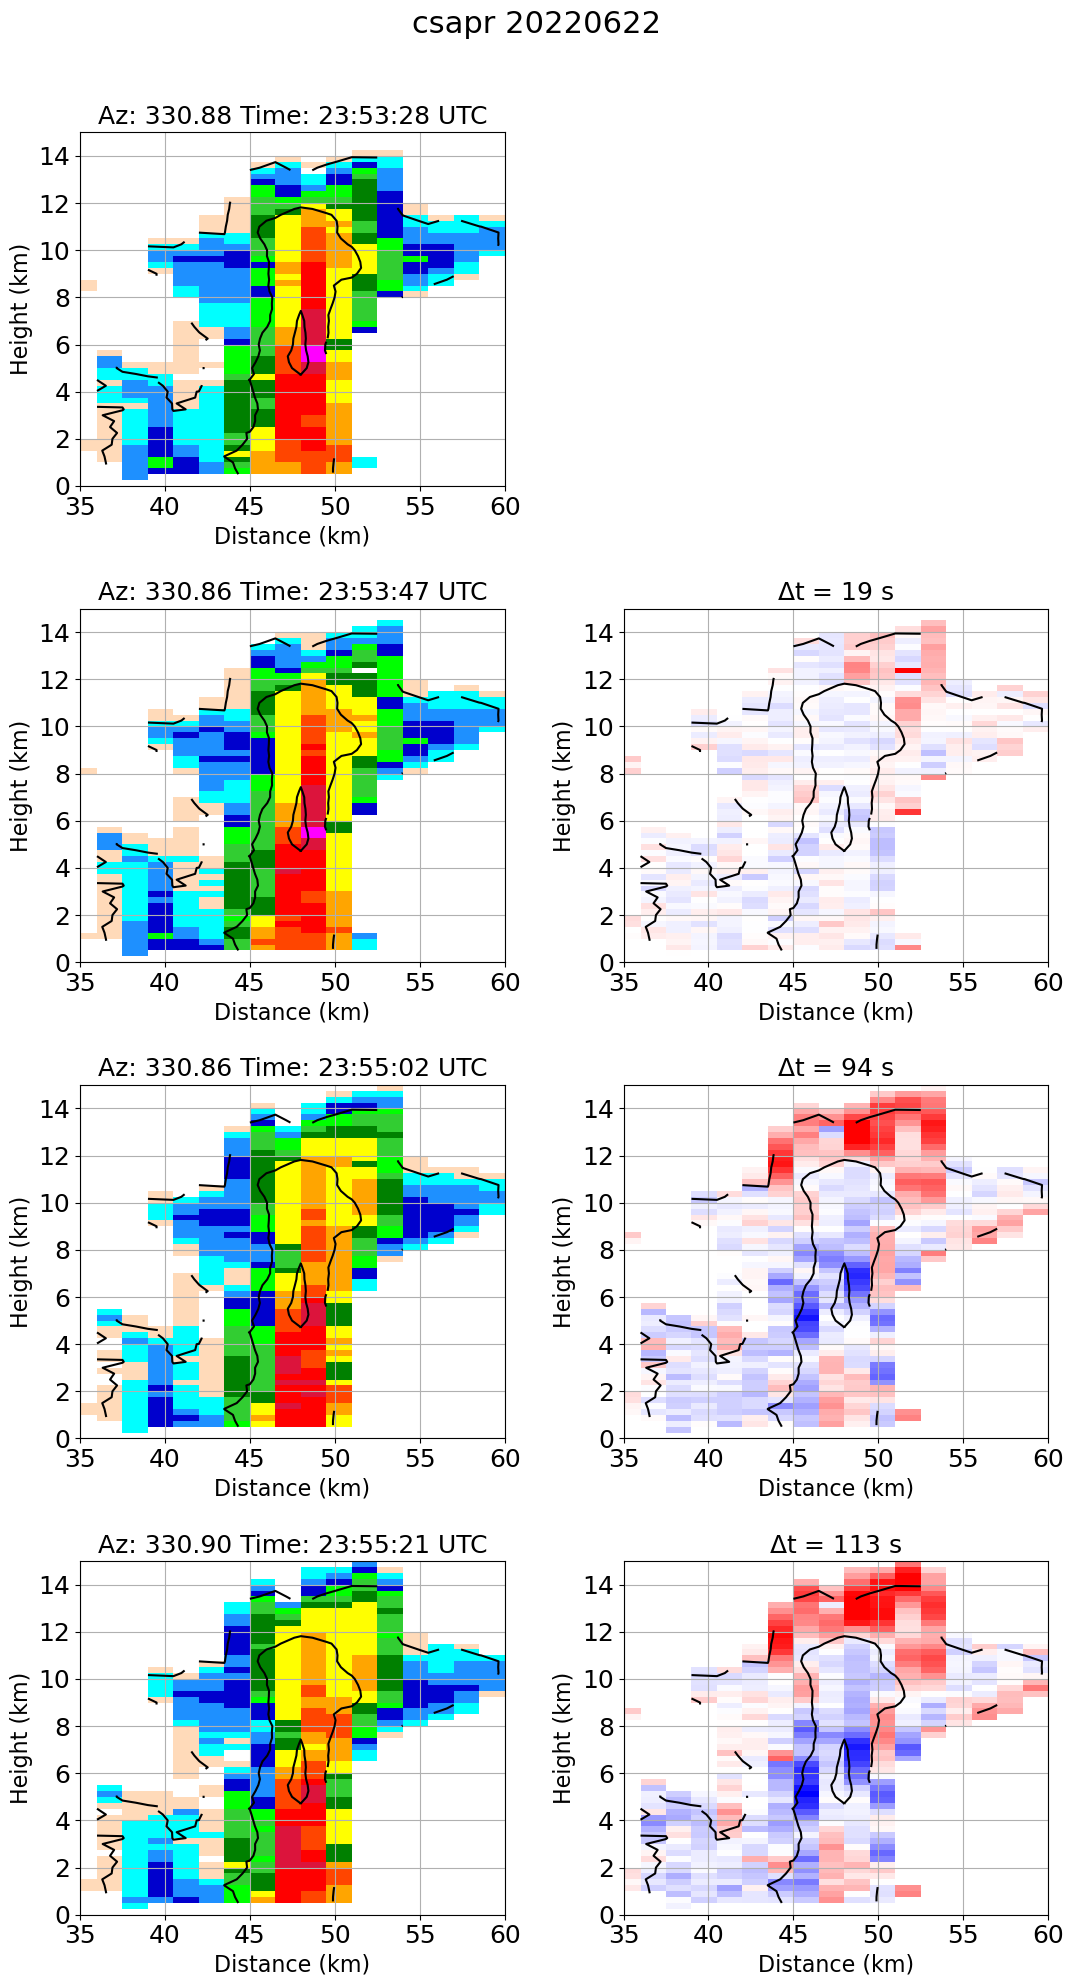

In [84]:
import matplotlib.ticker as ticker
for k in mkeys:
    nfiles = matchsets[k]['nfiles']
    f1 = matchsets[k]['file0']
    print(f1)
    gn1 = f1['rhi']
    smatss = f1['ss']
    gfile1 = scansets[f1['ss']][f'{gn1}_gfile2']
    gaz1 = scansets[f1['ss']][f'{gn1}_az']
    gtm1 = scansets[f1['ss']][f'{gn1}_time']

    #chivo_0 = get_data(scansets,chivo_scanset,chivo_0_rhi)
    chivorhi0grid = xr.open_dataset(gfile1)
    crhi0slant1=get_sdat(chivorhi0grid,az = gaz1 ,radar=radar)
    crhi0slant1=IH.get_echo_data(crhi0slant1)

    f2 = matchsets[k]['file1']
    gn2 = f2['rhi']
    gfile2 = scansets[f2['ss']][f'{gn2}_gfile2']
    gaz2 = scansets[f2['ss']][f'{gn2}_az']
    gtm2 = scansets[f2['ss']][f'{gn2}_time']
    chivorhi1grid = xr.open_dataset(gfile2)
    crhi1slant1=get_sdat(chivorhi1grid,az = gaz2 ,radar=radar )
    crhi1slant1=IH.get_echo_data(crhi1slant1)
    rhi0_1_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi1slant1)

    if nfiles >=3:
        f3 = matchsets[k]['file2']
        gn3 = f3['rhi']
        gfile3 = scansets[f3['ss']][f'{gn3}_gfile2']
        gaz3 = scansets[f3['ss']][f'{gn3}_az']
        gtm3 = scansets[f3['ss']][f'{gn3}_time']
        chivorhi2grid = xr.open_dataset(gfile3)
        crhi2slant1=get_sdat(chivorhi2grid,az = gaz3 ,radar=radar )
        crhi2slant1=IH.get_echo_data(crhi2slant1)
        rhi0_2_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi2slant1)

    if nfiles >=4:
        f4 = matchsets[k]['file3']
        gn4 = f4['rhi']
        gfile4 = scansets[f4['ss']][f'{gn4}_gfile2']
        gaz4 = scansets[f4['ss']][f'{gn4}_az']
        gtm4 = scansets[f4['ss']][f'{gn4}_time']
        chivorhi3grid = xr.open_dataset(gfile4)
        crhi3slant1=get_sdat(chivorhi3grid,az = gaz4 ,radar=radar )
        crhi3slant1=IH.get_echo_data(crhi3slant1)
        rhi0_3_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi3slant1)


    if nfiles >=5:
        f5 = matchsets[k]['file4']
        gn5 = f5['rhi']
        gfile5 = scansets[f5['ss']][f'{gn5}_gfile2']
        gaz5 = scansets[f5['ss']][f'{gn5}_az']
        gtm5 = scansets[f5['ss']][f'{gn5}_time']
        chivorhi4grid = xr.open_dataset(gfile5)
        crhi4slant1=get_sdat(chivorhi4grid,az = gaz5 ,radar=radar )
        crhi4slant1=IH.get_echo_data(crhi4slant1)
        rhi0_4_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi4slant1)

    if nfiles >=6:
        f6 = matchsets[k]['file5']
        gn6 = f6['rhi']
        gfile6 = scansets[f6['ss']][f'{gn6}_gfile2']
        gaz6 = scansets[f6['ss']][f'{gn6}_az']
        gtm6 = scansets[f6['ss']][f'{gn6}_time']
        chivorhi5grid = xr.open_dataset(gfile6)
        crhi5slant1=get_sdat(chivorhi5grid,az = gaz5 ,radar=radar )
        crhi5slant1=IH.get_echo_data(crhi4slant1)
        rhi0_5_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi5slant1)


    if nfiles >=7:
        f7 = matchsets[k]['file6']
        gn7 = f7['rhi']
        gfile7 = scansets[f7['ss']][f'{gn7}_gfile2']
        gaz7 = scansets[f7['ss']][f'{gn7}_az']
        gtm7 = scansets[f7['ss']][f'{gn7}_time']
        chivorhi6grid = xr.open_dataset(gfile5)
        crhi6slant1=get_sdat(chivorhi6grid,az = gaz7 ,radar=radar )
        crhi6slant1=IH.get_echo_data(crhi6slant1)
        rhi0_6_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi6slant1)






    aspectx = nfiles*2.8
    aspecty = nfiles*5
    axes_used = []
    fig, ax = plt.subplots(nfiles,2, figsize=(aspectx,aspecty))
    axf = ax.flatten()
   
    ylim = [0,15]
    f = 0
    axes_used.append(f)
    plot_dz(crhi0slant1,axf[f])
    
    f=f+1
    axf[f].axis('off')


    f= f+1
    axes_used.append(f)
    plot_dz(crhi1slant1,axf[f])
    f = f+2
    if nfiles >=3:
        plot_dz(crhi2slant1,axf[f])
        axes_used.append(f)
        f = f+2
    if nfiles >=4:
        plot_dz(crhi3slant1,axf[f])
        axes_used.append(f)
        f = f+2
        
    if nfiles >=5:
        plot_dz(crhi4slant1,axf[f])
        axes_used.append(f)
        f = f+2

    if nfiles >=6:
        plot_dz(crhi5slant1,axf[f])
        axes_used.append(f)
        f = f+2
    if nfiles >=7:
        plot_dz(crhi6slant1,axf[f])
        axes_used.append(f)
        f = f+2

    #plot_diff(rhi0_3_diff1,axf[0])

    
    #f=f+1
    f=3
    plot_diff(rhi0_1_diff1,axf[f])
    axes_used.append(f)
    f=f+2
    if nfiles >=3:
        plot_diff(rhi0_2_diff1,axf[f])
        axes_used.append(f)
        f=f+2
    if nfiles >=4:
        plot_diff(rhi0_3_diff1,axf[f])
        axes_used.append(f)
        f=f+2
    if nfiles >=5:
        plot_diff(rhi0_4_diff1,axf[f])
        axes_used.append(f)
        f=f+2
    if nfiles >=6:
        plot_diff(rhi0_5_diff1,axf[f])
        axes_used.append(f)
        f=f+2

    if nfiles >=7:
        plot_diff(rhi0_6_diff1,axf[f])
        axes_used.append(f)
        f=f+2


    print(f'{nfiles} for {k}')

    for a in axes_used:
        axf[a].set_xlim(xlim)
        axf[a].set_ylim(ylim)
        axf[a].xaxis.set_major_locator(ticker.MultipleLocator(5))
        axf[a].set_ylabel('Height (km)',fontsize=16)
        axf[a].yaxis.set_major_locator(ticker.MultipleLocator(2))
        axf[a].set_xlabel('Distance (km)',fontsize=16)
        axf[a].grid()
        axf[a].contour(crhi0slant1['y'],crhi0slant1['z'],crhi0slant1['dz'],levels=[-20,-10,5,35,55],colors=['k'],linestyles=['-'])
    plt.suptitle(f'{radar} {date}',y=1.0,fontsize=22)
    plt.tight_layout()

    plt.savefig(f'{figdir}{radar}_{date}_{smatss}_{k}_{nfiles}_res2.png',bbox_inches='tight',dpi=500,facecolor='white')
#plt.clf()
    


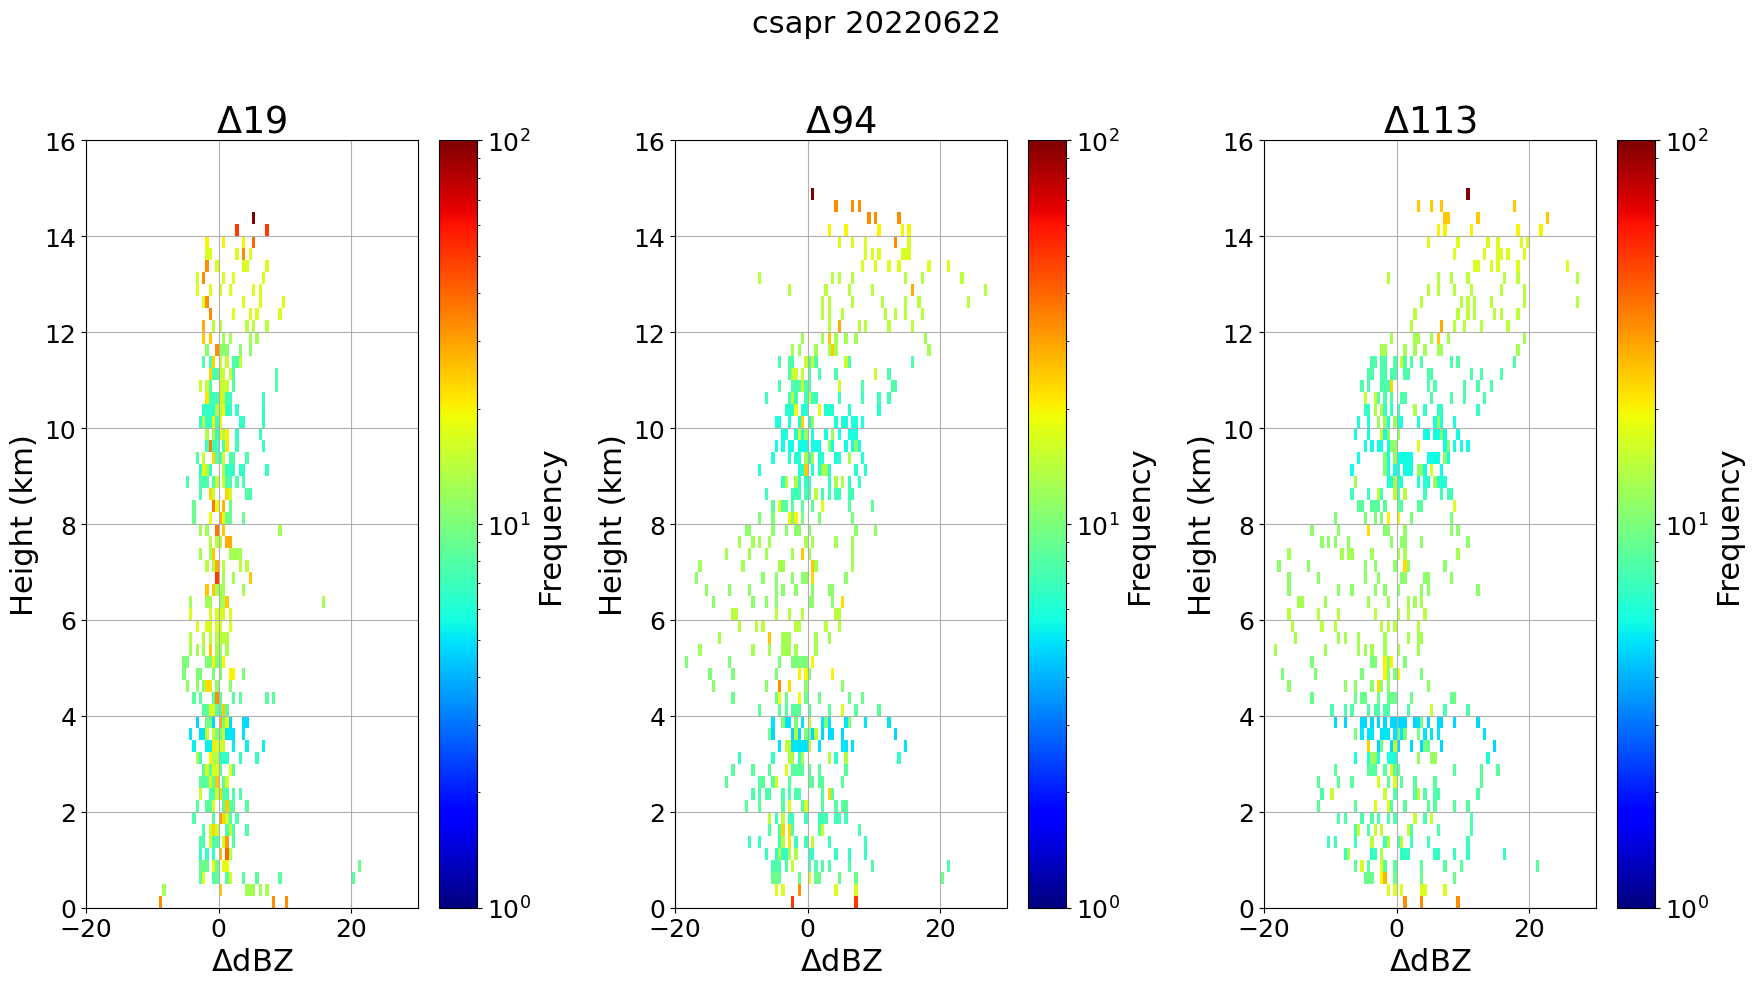

In [85]:
cfad1, edg = make_cfad(rhi0_1_diff1['dzdiff'],rhi0_1_diff1['rhi1hgt'])
cfad2, edg = make_cfad(rhi0_2_diff1['dzdiff'],rhi0_2_diff1['rhi1hgt'])
cfad3, edg = make_cfad(rhi0_3_diff1['dzdiff'],rhi0_3_diff1['rhi1hgt'])



fig, ax = plt.subplots(1,3,figsize=(18,10))
axf=ax.flatten()
norm = colors.LogNorm(vmin=1, vmax=100)
cfad1_ma = np.ma.masked_where(cfad1==0, cfad1)
cfad2_ma = np.ma.masked_where(cfad2==0, cfad2)
cfad3_ma = np.ma.masked_where(cfad3==0, cfad3)
#pc = ax.pcolormesh(bins, self.data[self.z_name][bot_index:top_index], cfad_ma, vmin=0, vmax=maxval, norm=norm, **kwargs)
pc = axf[0].pcolormesh(edg[:-1],rhi0_1_diff1['rhi1hgt'] , cfad1_ma,norm=norm,cmap='jet' )
t0=rhi0_1_diff1['delT']
axf[0].set_title(f'$\Delta${t0}')
pc = axf[1].pcolormesh(edg[:-1],rhi0_2_diff1['rhi1hgt'] , cfad2_ma,norm=norm,cmap='jet' )
t1=rhi0_2_diff1['delT']
axf[1].set_title(f'$\Delta${t1}')
pc = axf[2].pcolormesh(edg[:-1],rhi0_3_diff1['rhi1hgt'] , cfad3_ma,norm=norm,cmap='jet' )
t2=rhi0_3_diff1['delT']
axf[2].set_title(f'$\Delta${t2}')

for a in axf:
    a.set_ylim(0,16)
    a.set_xlim(-20,30)
    a.grid()
    a.set_xlabel('$\Delta$dBZ')
    a.set_ylabel('Height (km)')
    cb = plt.colorbar(pc,ax=a)
    cb.set_label("Frequency")


plt.suptitle(f'{radar} {date}',y=1.0,fontsize=22)
plt.tight_layout()

plt.savefig(f'{figdir}{radar}_{date}_delZ_CFAD_1.5km.png',bbox_inches='tight',dpi=500,facecolor='white')

#.colorbar(pc)
#plt.xlim(-20,20)

{'time': datetime.datetime(2022, 6, 22, 23, 53, 28), 'az': 330.88074, 'ss': '147', 'rhi': 'rhi1'}
4 for 362


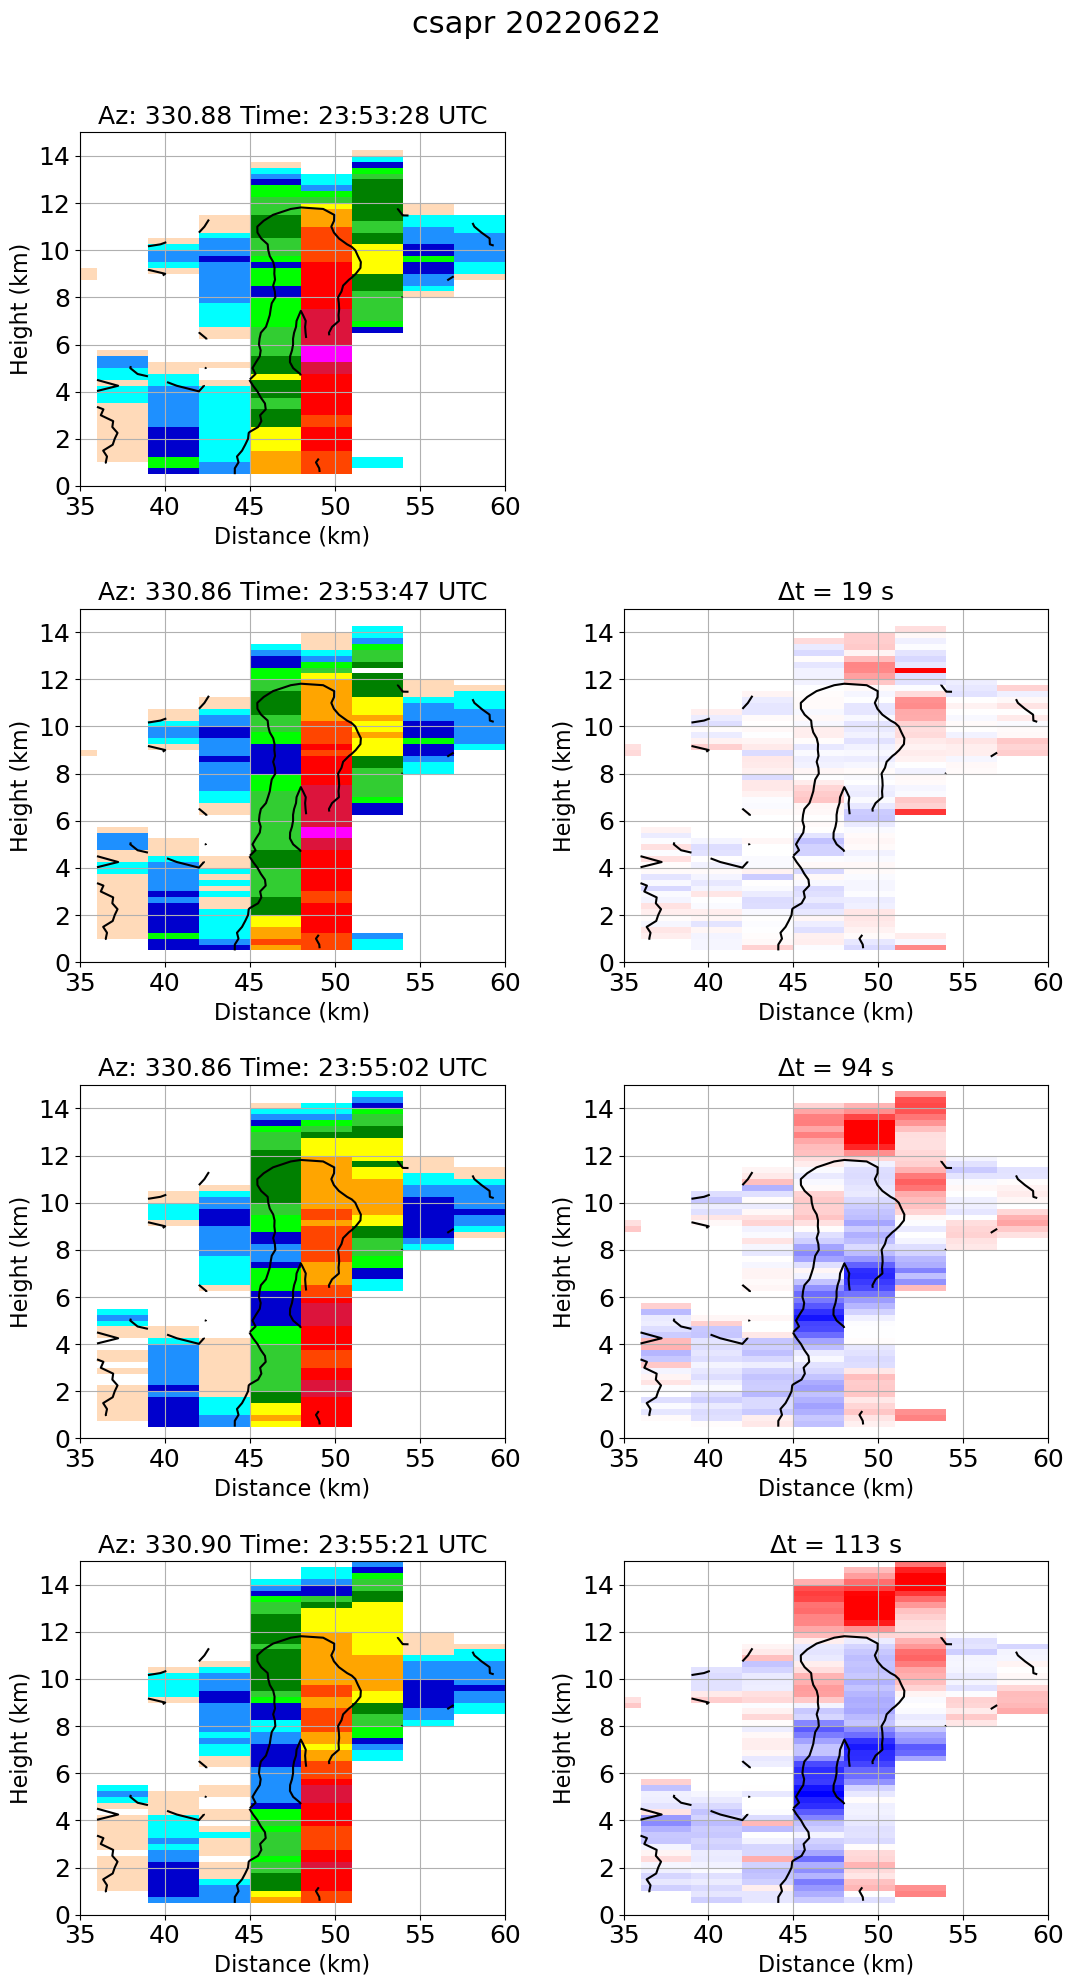

In [86]:
import matplotlib.ticker as ticker
for k in mkeys:
    nfiles = matchsets[k]['nfiles']
    f1 = matchsets[k]['file0']
    print(f1)
    gn1 = f1['rhi']
    smatss = f1['ss']
    gfile1 = scansets[f1['ss']][f'{gn1}_gfile3']
    gaz1 = scansets[f1['ss']][f'{gn1}_az']
    gtm1 = scansets[f1['ss']][f'{gn1}_time']

    #chivo_0 = get_data(scansets,chivo_scanset,chivo_0_rhi)
    chivorhi0grid = xr.open_dataset(gfile1)
    crhi0slant1=get_sdat(chivorhi0grid,az = gaz1 ,radar=radar)
    crhi0slant1=IH.get_echo_data(crhi0slant1)

    f2 = matchsets[k]['file1']
    gn2 = f2['rhi']
    gfile2 = scansets[f2['ss']][f'{gn2}_gfile3']
    gaz2 = scansets[f2['ss']][f'{gn2}_az']
    gtm2 = scansets[f2['ss']][f'{gn2}_time']
    chivorhi1grid = xr.open_dataset(gfile2)
    crhi1slant1=get_sdat(chivorhi1grid,az = gaz2 ,radar=radar )
    crhi1slant1=IH.get_echo_data(crhi1slant1)
    rhi0_1_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi1slant1)

    if nfiles >=3:
        f3 = matchsets[k]['file2']
        gn3 = f3['rhi']
        gfile3 = scansets[f3['ss']][f'{gn3}_gfile3']
        gaz3 = scansets[f3['ss']][f'{gn3}_az']
        gtm3 = scansets[f3['ss']][f'{gn3}_time']
        chivorhi2grid = xr.open_dataset(gfile3)
        crhi2slant1=get_sdat(chivorhi2grid,az = gaz3 ,radar=radar )
        crhi2slant1=IH.get_echo_data(crhi2slant1)
        rhi0_2_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi2slant1)

    if nfiles >=4:
        f4 = matchsets[k]['file3']
        gn4 = f4['rhi']
        gfile4 = scansets[f4['ss']][f'{gn4}_gfile3']
        gaz4 = scansets[f4['ss']][f'{gn4}_az']
        gtm4 = scansets[f4['ss']][f'{gn4}_time']
        chivorhi3grid = xr.open_dataset(gfile4)
        crhi3slant1=get_sdat(chivorhi3grid,az = gaz4 ,radar=radar )
        crhi3slant1=IH.get_echo_data(crhi3slant1)
        rhi0_3_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi3slant1)


    if nfiles >=5:
        f5 = matchsets[k]['file4']
        gn5 = f5['rhi']
        gfile5 = scansets[f5['ss']][f'{gn5}_gfile3']
        gaz5 = scansets[f5['ss']][f'{gn5}_az']
        gtm5 = scansets[f5['ss']][f'{gn5}_time']
        chivorhi4grid = xr.open_dataset(gfile5)
        crhi4slant1=get_sdat(chivorhi4grid,az = gaz5 ,radar=radar )
        crhi4slant1=IH.get_echo_data(crhi4slant1)
        rhi0_4_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi4slant1)

    if nfiles >=6:
        f6 = matchsets[k]['file5']
        gn6 = f6['rhi']
        gfile6 = scansets[f6['ss']][f'{gn6}_gfile3']
        gaz6 = scansets[f6['ss']][f'{gn6}_az']
        gtm6 = scansets[f6['ss']][f'{gn6}_time']
        chivorhi5grid = xr.open_dataset(gfile6)
        crhi5slant1=get_sdat(chivorhi5grid,az = gaz5 ,radar=radar )
        crhi5slant1=IH.get_echo_data(crhi4slant1)
        rhi0_5_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi5slant1)


    if nfiles >=7:
        f7 = matchsets[k]['file6']
        gn7 = f7['rhi']
        gfile7 = scansets[f7['ss']][f'{gn7}_gfile3']
        gaz7 = scansets[f7['ss']][f'{gn7}_az']
        gtm7 = scansets[f7['ss']][f'{gn7}_time']
        chivorhi6grid = xr.open_dataset(gfile5)
        crhi6slant1=get_sdat(chivorhi6grid,az = gaz7 ,radar=radar )
        crhi6slant1=IH.get_echo_data(crhi6slant1)
        rhi0_6_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi6slant1)






    aspectx = nfiles*2.8
    aspecty = nfiles*5
    axes_used = []
    fig, ax = plt.subplots(nfiles,2, figsize=(aspectx,aspecty))
    axf = ax.flatten()
   
    ylim = [0,15]
    f = 0
    axes_used.append(f)
    plot_dz(crhi0slant1,axf[f])
    
    f=f+1
    axf[f].axis('off')


    f= f+1
    axes_used.append(f)
    plot_dz(crhi1slant1,axf[f])
    f = f+2
    if nfiles >=3:
        plot_dz(crhi2slant1,axf[f])
        axes_used.append(f)
        f = f+2
    if nfiles >=4:
        plot_dz(crhi3slant1,axf[f])
        axes_used.append(f)
        f = f+2
        
    if nfiles >=5:
        plot_dz(crhi4slant1,axf[f])
        axes_used.append(f)
        f = f+2

    if nfiles >=6:
        plot_dz(crhi5slant1,axf[f])
        axes_used.append(f)
        f = f+2
    if nfiles >=7:
        plot_dz(crhi6slant1,axf[f])
        axes_used.append(f)
        f = f+2

    #plot_diff(rhi0_3_diff1,axf[0])

    
    #f=f+1
    f=3
    plot_diff(rhi0_1_diff1,axf[f])
    axes_used.append(f)
    f=f+2
    if nfiles >=3:
        plot_diff(rhi0_2_diff1,axf[f])
        axes_used.append(f)
        f=f+2
    if nfiles >=4:
        plot_diff(rhi0_3_diff1,axf[f])
        axes_used.append(f)
        f=f+2
    if nfiles >=5:
        plot_diff(rhi0_4_diff1,axf[f])
        axes_used.append(f)
        f=f+2
    if nfiles >=6:
        plot_diff(rhi0_5_diff1,axf[f])
        axes_used.append(f)
        f=f+2

    if nfiles >=7:
        plot_diff(rhi0_6_diff1,axf[f])
        axes_used.append(f)
        f=f+2


    print(f'{nfiles} for {k}')

    for a in axes_used:
        axf[a].set_xlim(xlim)
        axf[a].set_ylim(ylim)
        axf[a].xaxis.set_major_locator(ticker.MultipleLocator(5))
        axf[a].set_ylabel('Height (km)',fontsize=16)
        axf[a].yaxis.set_major_locator(ticker.MultipleLocator(2))
        axf[a].set_xlabel('Distance (km)',fontsize=16)
        axf[a].grid()
        axf[a].contour(crhi0slant1['y'],crhi0slant1['z'],crhi0slant1['dz'],levels=[-20,-10,5,35,55],colors=['k'],linestyles=['-'])
    plt.suptitle(f'{radar} {date}',y=1.0,fontsize=22)
    plt.tight_layout()

    plt.savefig(f'{figdir}{radar}_{date}_{smatss}_{k}_{nfiles}_res3.png',bbox_inches='tight',dpi=500,facecolor='white')
#plt.clf()
    


In [87]:
%matplotlib inline

In [88]:
matchtime = datetime(2022,6,22,23,12,7)

#matchtime = datetime(2022,6,22,23,53,28)

for i,t in enumerate(matchsets.keys()):
    #print(t)

    test =    matchsets[t]['file0']['time']
    if test == matchtime:
        print('gotcha',i,t)
        print( matchsets[t]['nfiles'])

        diffmatch = t




gotcha 288 289
4


In [89]:
print(matchsets[diffmatch])
print(scansets[f1['ss']])
print(gn1)

{'file0': {'time': datetime.datetime(2022, 6, 22, 23, 12, 7), 'az': 333.13843, 'ss': '120', 'rhi': 'rhi1'}, 'file1': {'time': datetime.datetime(2022, 6, 22, 23, 12, 29), 'az': 333.11646, 'ss': '120', 'rhi': 'rhi2'}, 'nfiles': 4, 'file2': {'time': datetime.datetime(2022, 6, 22, 23, 13, 41), 'az': 333.13843, 'ss': '121', 'rhi': 'rhi1'}, 'file3': {'time': datetime.datetime(2022, 6, 22, 23, 13, 58), 'az': 333.11646, 'ss': '121', 'rhi': 'rhi2'}}
{'sector': '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220622/csapr/20220622/cfrad.20220622_235301_147_csapr_sector.nc', 'rhi1_time': datetime.datetime(2022, 6, 22, 23, 53, 28), 'rhi1_az': 330.88074, 'nrhi': 4, 'rhi1': '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220622/csapr/20220622/cfrad.20220622_235328_147_csapr_rhi1.nc', 'rhi2_time': datetime.datetime(2022, 6, 22, 23, 53, 47), 'rhi2_az': 330.85876, 'rhi2': '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220622/csapr/20220622/cfrad.20220622_235347_147_csapr_rhi2.nc', 'rhi3_time': datet

{'time': datetime.datetime(2022, 6, 22, 23, 12, 7), 'az': 333.13843, 'ss': '120', 'rhi': 'rhi1'}
{'time': datetime.datetime(2022, 6, 22, 23, 13, 41), 'az': 333.13843, 'ss': '121', 'rhi': 'rhi1'}


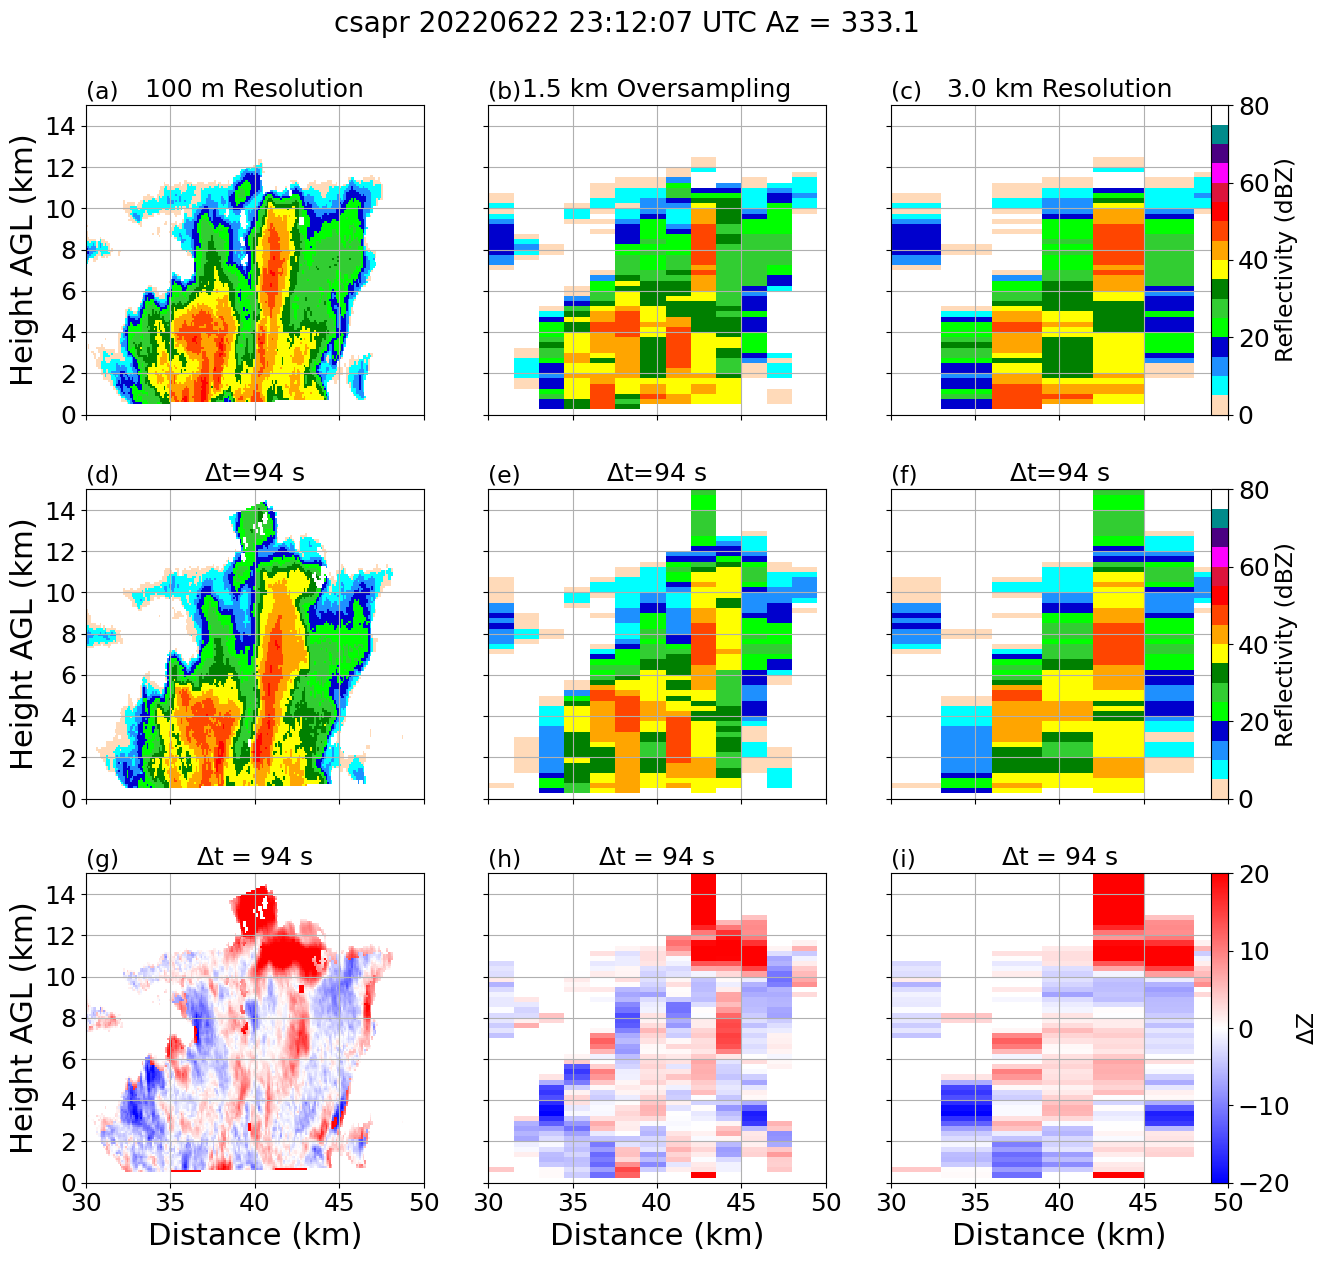

In [113]:
f1 = matchsets[diffmatch]['file0']
print(f1)
gn1 = f1['rhi']
smatss = f1['ss']
gfile12 = scansets[f1['ss']][f'{gn1}_gfile2']
gaz1 = scansets[f1['ss']][f'{gn1}_az']
gtm1 = scansets[f1['ss']][f'{gn1}_time']

#chivo_0 = get_data(scansets,chivo_scanset,chivo_0_rhi)
chivorhi0grid2 = xr.open_dataset(gfile12)
crhi0slant2=get_sdat(chivorhi0grid2,az = gaz1 ,radar=radar)
crhi0slant2=IH.get_echo_data(crhi0slant2)

gfile11 = scansets[f1['ss']][f'{gn1}_gfile1']
chivorhi0grid1 = xr.open_dataset(gfile11)
crhi0slant1=get_sdat(chivorhi0grid1,az = gaz1 ,radar=radar)
crhi0slant1=IH.get_echo_data(crhi0slant1)

gfile13 = scansets[f1['ss']][f'{gn1}_gfile3']
chivorhi0grid3 = xr.open_dataset(gfile13)
crhi0slant3=get_sdat(chivorhi0grid3,az = gaz1 ,radar=radar)
crhi0slant3=IH.get_echo_data(crhi0slant3)



f2 = matchsets[diffmatch]['file2']
print(f2)
gn2 = f2['rhi']
smatss2 = f2['ss']
gfile22 = scansets[f2['ss']][f'{gn2}_gfile2']
gaz2 = scansets[f2['ss']][f'{gn2}_az']
gtm2 = scansets[f2['ss']][f'{gn2}_time']

#chivo_0 = get_data(scansets,chivo_scanset,chivo_0_rhi)
chivorhi1grid2 = xr.open_dataset(gfile22)
crhi1slant2=get_sdat(chivorhi1grid2,az = gaz2 ,radar=radar)
crhi1slant2=IH.get_echo_data(crhi1slant2)

gfile21 = scansets[f2['ss']][f'{gn2}_gfile1']
chivorhi1grid1 = xr.open_dataset(gfile21)
crhi1slant1=get_sdat(chivorhi1grid1,az = gaz2 ,radar=radar)
crhi1slant1=IH.get_echo_data(crhi1slant1)

gfile23 = scansets[f2['ss']][f'{gn2}_gfile3']
chivorhi1grid3 = xr.open_dataset(gfile23)
crhi1slant3=get_sdat(chivorhi1grid3,az = gaz2 ,radar=radar)
crhi1slant3=IH.get_echo_data(crhi1slant3)


rhi1_2_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi1slant1)
rhi1_2_diff2 = IH.get_hgt_diffs(crhi0slant2,crhi1slant2)
rhi1_2_diff3 = IH.get_hgt_diffs(crhi0slant3,crhi1slant3)

delt = rhi1_2_diff1['delT']


fig, ax = plt.subplots(3,3,figsize=(13,13))
axf = ax.flatten()
cdz = plot_dz(crhi0slant1,axf[0])
axf[0].set_title('100 m Resolution',fontsize=18)
cdz = plot_dz(crhi0slant2,axf[1])
axf[1].set_title('1.5 km Oversampling',fontsize=18)
cdz = plot_dz(crhi0slant3,axf[2])
axf[2].set_title('3.0 km Resolution',fontsize=18)
cdz = plot_dz(crhi1slant1,axf[3])
axf[3].set_title(f'$\Delta$t={delt} s',fontsize=18)

cdz = plot_dz(crhi1slant2,axf[4])
axf[4].set_title(f'$\Delta$t={delt} s',fontsize=18)
cdz = plot_dz(crhi1slant3,axf[5])
axf[5].set_title(f'$\Delta$t={delt} s',fontsize=18)

cdiff = plot_diff(rhi1_2_diff1,axf[6])
cdiff = plot_diff(rhi1_2_diff2,axf[7])
cdiff = plot_diff(rhi1_2_diff3,axf[8])


for f, a in enumerate(axf):
    a.set_xlim(30,50)
    a.set_xticks(np.arange(30,51,5))
    a.set_ylim(0,15)
    a.set_yticks(np.arange(0,16,2))
    a.grid()
    a.xaxis.set_tick_params(labelbottom=False)
    a.yaxis.set_tick_params(labelleft=False)
    if f in [0,3,6]:
        a.set_ylabel('Height AGL (km)')
        a.yaxis.set_tick_params(labelleft=True)
    if f in [6,7,8]:
        a.set_xlabel('Distance (km)')
        a.xaxis.set_tick_params(labelbottom=True)
    
from mpl_toolkits.axes_grid1 import make_axes_locatable
#divider = make_axes_locatable(axf[-2])
#cax = divider.new_vertical(size='5%', pad=0.7, pack_start = True)
#fig.add_axes(cax)
#cbz = fig.colorbar(cbdz,ax=ax[0,2])#, location='right')#, shrink=0.6)#, orientation = 'horizontal')
#cbz.set_label('Reflectivity (dBZ)',fontsize=17)
#cbz = fig.colorbar(cbdz,ax=ax[1,2])#, location='right')#, shrink=0.6)#, orientation = 'horizontal')

#cbv = fig.colorbar(cdiff,ax=ax[2,2])#, orientation = 'horizontal')




axins = inset_axes(axf[2],
                width="5%",  # width = 5% of parent_bbox width
                height="100%",  # height : 50%
                #bbox_to_anchor=(1.0, 0, 1, 1),
                bbox_transform=axf[2].transAxes,
                borderpad=0,
                loc='lower right',
                )
cbz = plt.colorbar(cbdz,cax=axins)
cbz.set_label('Reflectivity (dBZ)',fontsize=17)

axins2 = inset_axes(axf[5],
                width="5%",  # width = 5% of parent_bbox width
                height="100%",  # height : 50%
                #bbox_to_anchor=(1.0, 0, 1, 1),
                bbox_transform=axf[5].transAxes,
                borderpad=0,
                loc='lower right',
                )
cbz = plt.colorbar(cbdz,cax=axins2)
cbz.set_label('Reflectivity (dBZ)',fontsize=17)

axins3 = inset_axes(axf[8],
                width="5%",  # width = 5% of parent_bbox width
                height="100%",  # height : 50%
                #bbox_to_anchor=(1.0, 0, 1, 1),
                bbox_transform=axf[8].transAxes,
                borderpad=0,
                loc='lower right',
                )
cbd = plt.colorbar(cdiff,cax=axins3)
cbd.set_label('Reflectivity (dBZ)',fontsize=17)
cbd.set_label('$\Delta$Z',fontsize=17)



plt.suptitle(f"{radar} {date} {gtm1:%H:%M:%S} UTC Az = {gaz1:.1f}",fontsize=20)#,y=1.0)
plt.tight_layout()
label_subplots(fig, nlabels=len(axf),yoff=0.005)
plt.savefig(f'{figdir}{radar}_{date}_{smatss}_{diffmatch}_compare.png',bbox_inches='tight',dpi=500,facecolor='white')


{'time': datetime.datetime(2022, 6, 22, 23, 12, 7), 'az': 333.13843, 'ss': '120', 'rhi': 'rhi1'}
{'time': datetime.datetime(2022, 6, 22, 23, 12, 29), 'az': 333.11646, 'ss': '120', 'rhi': 'rhi2'}
{'time': datetime.datetime(2022, 6, 22, 23, 13, 41), 'az': 333.13843, 'ss': '121', 'rhi': 'rhi1'}


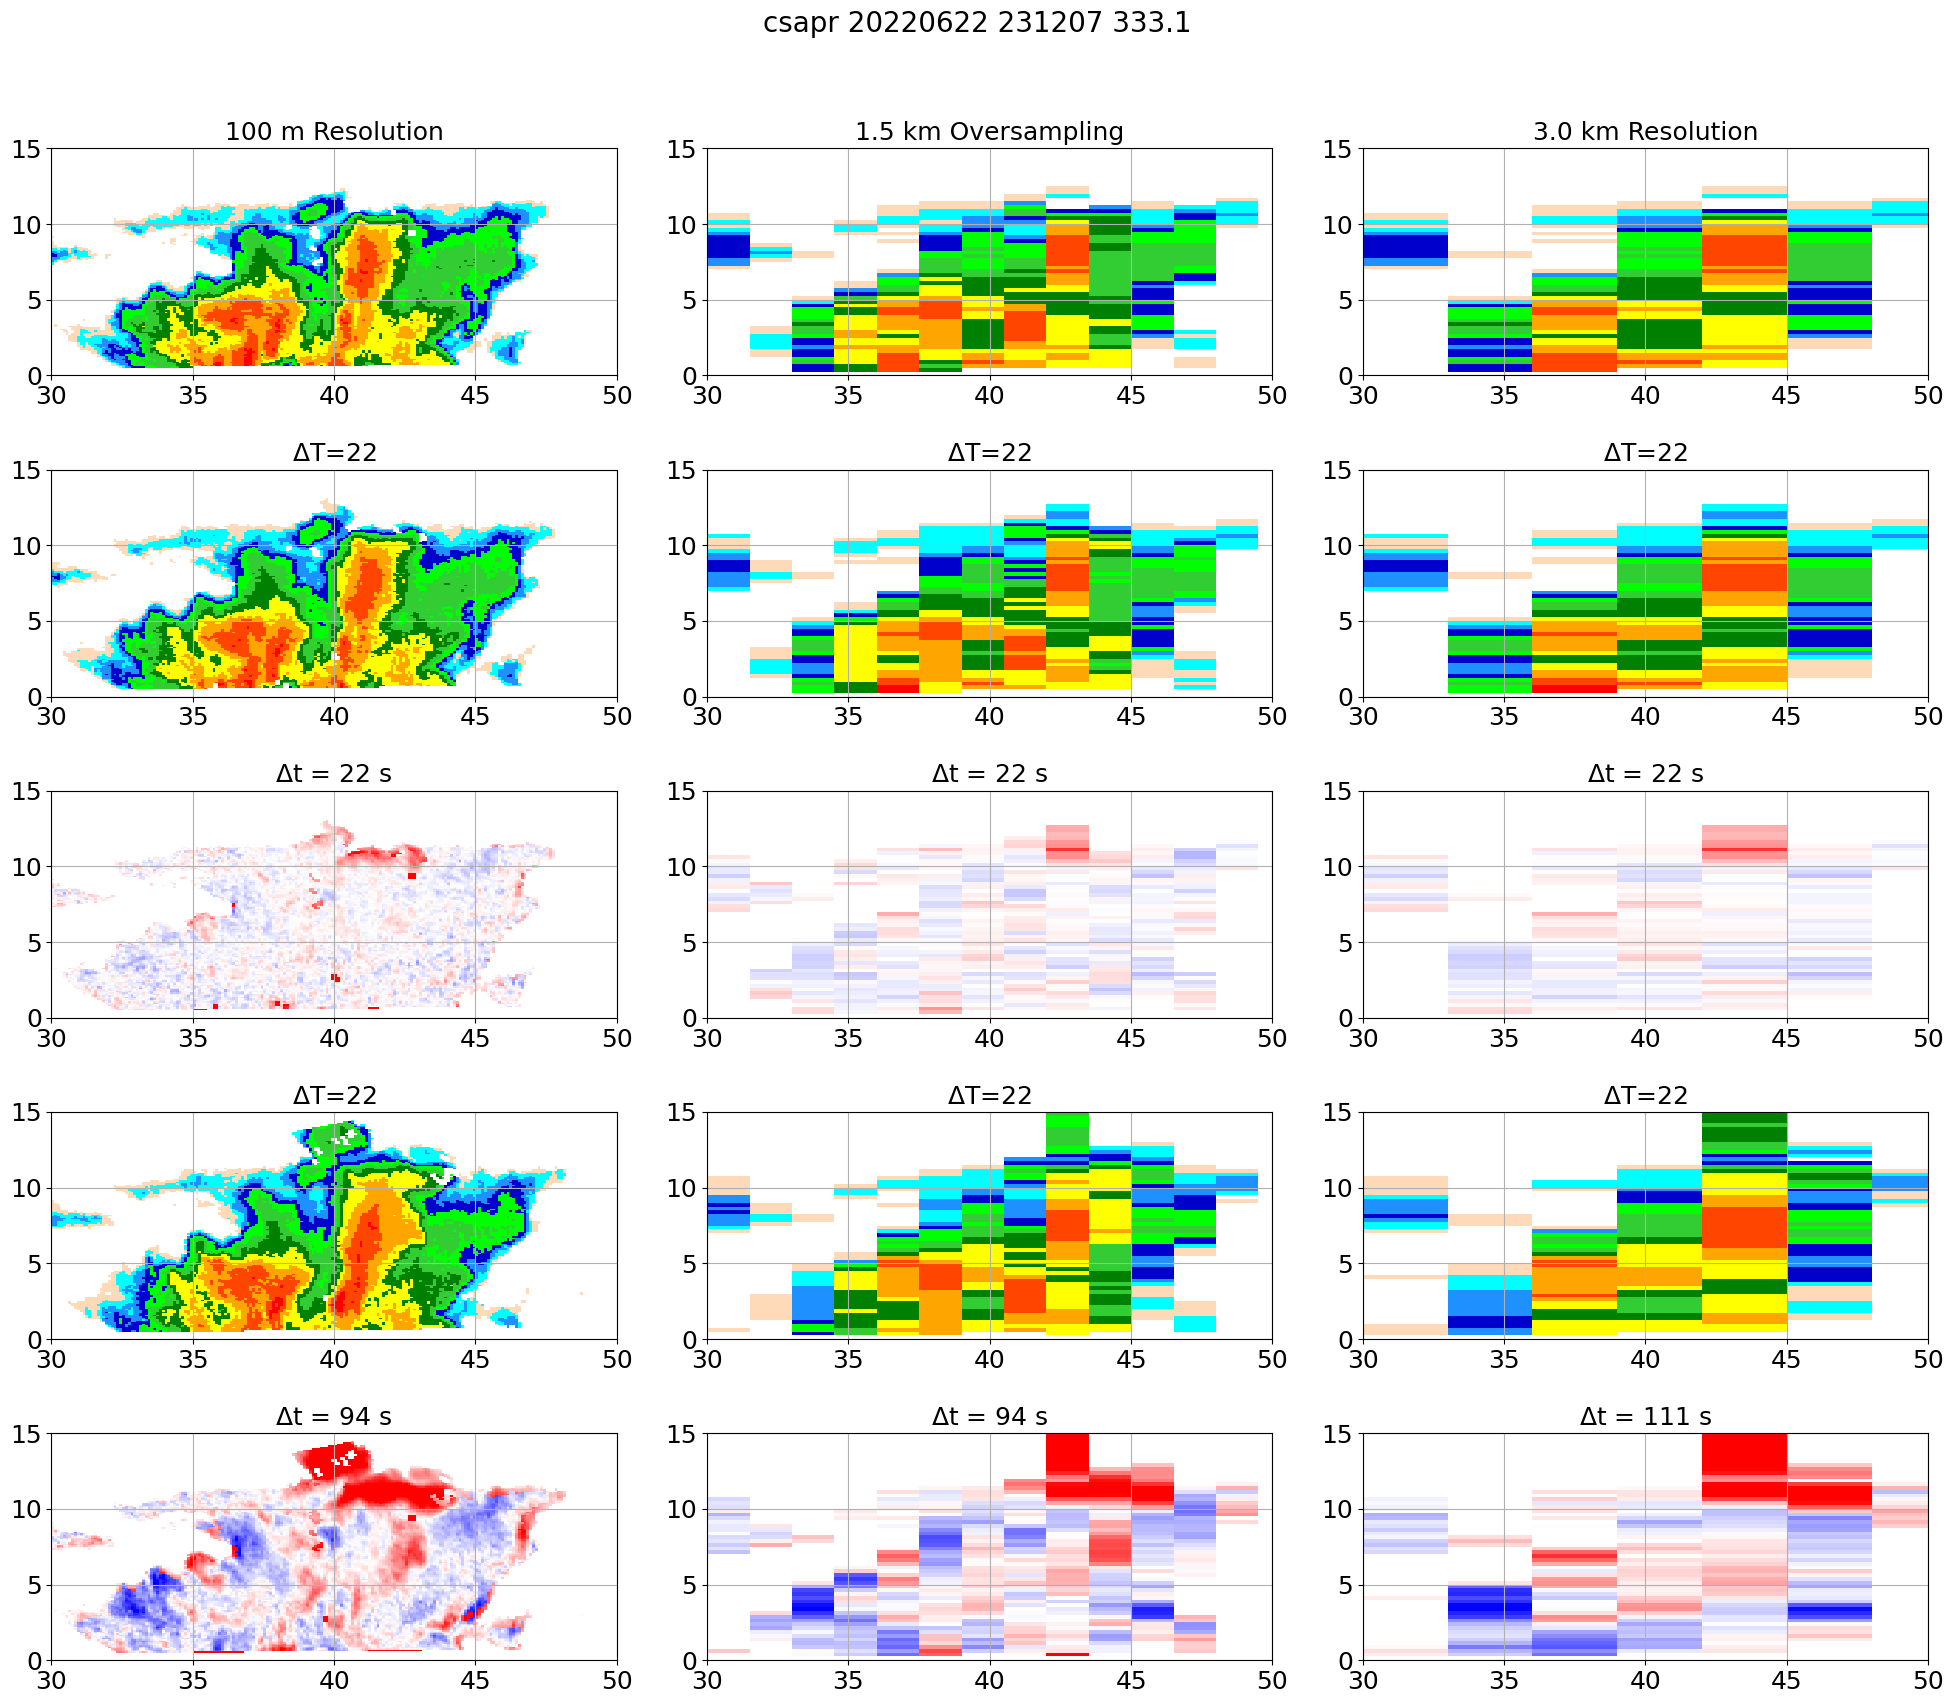

In [91]:
f1 = matchsets[diffmatch]['file0']
print(f1)
gn1 = f1['rhi']
smatss = f1['ss']
gfile12 = scansets[f1['ss']][f'{gn1}_gfile2']
gaz1 = scansets[f1['ss']][f'{gn1}_az']
gtm1 = scansets[f1['ss']][f'{gn1}_time']

#chivo_0 = get_data(scansets,chivo_scanset,chivo_0_rhi)
chivorhi0grid2 = xr.open_dataset(gfile12)
crhi0slant2=get_sdat(chivorhi0grid2,az = gaz1 ,radar=radar)
crhi0slant2=IH.get_echo_data(crhi0slant2)

gfile11 = scansets[f1['ss']][f'{gn1}_gfile1']
chivorhi0grid1 = xr.open_dataset(gfile11)
crhi0slant1=get_sdat(chivorhi0grid1,az = gaz1 ,radar=radar)
crhi0slant1=IH.get_echo_data(crhi0slant1)

gfile13 = scansets[f1['ss']][f'{gn1}_gfile3']
chivorhi0grid3 = xr.open_dataset(gfile13)
crhi0slant3=get_sdat(chivorhi0grid3,az = gaz1 ,radar=radar)
crhi0slant3=IH.get_echo_data(crhi0slant3)



f2 = matchsets[diffmatch]['file1']
print(f2)
gn2 = f2['rhi']
smatss2 = f2['ss']
gfile22 = scansets[f2['ss']][f'{gn2}_gfile2']
gaz2 = scansets[f2['ss']][f'{gn2}_az']
gtm2 = scansets[f2['ss']][f'{gn2}_time']

#chivo_0 = get_data(scansets,chivo_scanset,chivo_0_rhi)
chivorhi1grid2 = xr.open_dataset(gfile22)
crhi1slant2=get_sdat(chivorhi1grid2,az = gaz2 ,radar=radar)
crhi1slant2=IH.get_echo_data(crhi1slant2)

gfile21 = scansets[f2['ss']][f'{gn2}_gfile1']
chivorhi1grid1 = xr.open_dataset(gfile21)
crhi1slant1=get_sdat(chivorhi1grid1,az = gaz2 ,radar=radar)
crhi1slant1=IH.get_echo_data(crhi1slant1)

gfile23 = scansets[f2['ss']][f'{gn2}_gfile3']
chivorhi1grid3 = xr.open_dataset(gfile23)
crhi1slant3=get_sdat(chivorhi1grid3,az = gaz2 ,radar=radar)
crhi1slant3=IH.get_echo_data(crhi1slant3)


rhi1_2_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi1slant1)
rhi1_2_diff2 = IH.get_hgt_diffs(crhi0slant2,crhi1slant2)
rhi1_2_diff3 = IH.get_hgt_diffs(crhi0slant3,crhi1slant3)


f3 = matchsets[diffmatch]['file2']
print(f3)
gn3 = f3['rhi']
smatss3 = f3['ss']
gfile32 = scansets[f3['ss']][f'{gn3}_gfile2']
gaz3 = scansets[f3['ss']][f'{gn3}_az']
gtm3 = scansets[f3['ss']][f'{gn3}_time']

#chivo_0 = get_data(scansets,chivo_scanset,chivo_0_rhi)
chivorhi3grid2 = xr.open_dataset(gfile32)
crhi3slant2=get_sdat(chivorhi3grid2,az = gaz3 ,radar=radar)
crhi3slant2=IH.get_echo_data(crhi3slant2)

gfile31 = scansets[f3['ss']][f'{gn3}_gfile1']
chivorhi3grid1 = xr.open_dataset(gfile31)
crhi3slant1=get_sdat(chivorhi3grid1,az = gaz3 ,radar=radar)
crhi3slant1=IH.get_echo_data(crhi3slant1)

gfile33 = scansets[f3['ss']][f'{gn2}_gfile3']
chivorhi3grid3 = xr.open_dataset(gfile33)
crhi3slant3=get_sdat(chivorhi3grid3,az = gaz3 ,radar=radar)
crhi3slant3=IH.get_echo_data(crhi3slant3)


rhi1_3_diff1 = IH.get_hgt_diffs(crhi0slant1,crhi3slant1)
rhi1_3_diff2 = IH.get_hgt_diffs(crhi0slant2,crhi3slant2)
rhi1_3_diff3 = IH.get_hgt_diffs(crhi0slant3,crhi3slant3)

delt = rhi1_2_diff1['delT']


fig, ax = plt.subplots(5,3,figsize=(20,17))
axf = ax.flatten()
plot_dz(crhi0slant1,axf[0])
axf[0].set_title('100 m Resolution',fontsize=18)
plot_dz(crhi0slant2,axf[1])
axf[1].set_title('1.5 km Oversampling',fontsize=18)
plot_dz(crhi0slant3,axf[2])
axf[2].set_title('3.0 km Resolution',fontsize=18)
plot_dz(crhi1slant1,axf[3])
axf[3].set_title(f'$\Delta$T={delt}',fontsize=18)

plot_dz(crhi1slant2,axf[4])
axf[4].set_title(f'$\Delta$T={delt}',fontsize=18)
plot_dz(crhi1slant3,axf[5])
axf[5].set_title(f'$\Delta$T={delt}',fontsize=18)

plot_diff(rhi1_2_diff1,axf[6])
plot_diff(rhi1_2_diff2,axf[7])
plot_diff(rhi1_2_diff3,axf[8])


plot_dz(crhi3slant1,axf[9])
axf[9].set_title(f'$\Delta$T={delt}',fontsize=18)
plot_dz(crhi3slant2,axf[10])
axf[10].set_title(f'$\Delta$T={delt}',fontsize=18)

plot_dz(crhi3slant3,axf[11])
axf[11].set_title(f'$\Delta$T={delt}',fontsize=18)


plot_diff(rhi1_3_diff1,axf[12])
plot_diff(rhi1_3_diff2,axf[13])
plot_diff(rhi1_3_diff3,axf[14])




for a in axf:
    a.set_xlim(30,50)
    a.set_ylim(0,15)
    a.grid()
plt.suptitle(f"{radar} {date} {gtm1:%H%M%S} {gaz1:.1f}",fontsize=20,y=1.01)
plt.tight_layout()
plt.savefig(f'{figdir}{radar}_{date}_{smatss}_{diffmatch}_compare2times.png',bbox_inches='tight',dpi=500,facecolor='white')


In [92]:
date = '20220622'

Now for CSAPR

In [93]:
csaprdir = f'/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/{date}/csapr/{date}/'#/RAW/'
csapr_files= sorted(glob.glob(f'{csaprdir}/*csapr_rhi*.nc'))
csapr_sect = sorted(glob.glob(f'{csaprdir}/*csapr_sector*.nc'))
print(csapr_files[0])
print(csapr_sect[0])


/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220622/csapr/20220622/cfrad.20220622_200018_000_csapr_rhi.nc
/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220622/csapr/20220622/cfrad.20220622_200136_001_csapr_sector.nc


In [94]:
csapr_files

['/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220622/csapr/20220622/cfrad.20220622_200018_000_csapr_rhi.nc',
 '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220622/csapr/20220622/cfrad.20220622_200037_000_csapr_rhi.nc',
 '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220622/csapr/20220622/cfrad.20220622_200058_000_csapr_rhi.nc',
 '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220622/csapr/20220622/cfrad.20220622_200118_000_csapr_rhi.nc',
 '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220622/csapr/20220622/cfrad.20220622_200217_001_csapr_rhi1.nc',
 '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220622/csapr/20220622/cfrad.20220622_200238_001_csapr_rhi2.nc',
 '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220622/csapr/20220622/cfrad.20220622_200258_001_csapr_rhi3.nc',
 '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220622/csapr/20220622/cfrad.20220622_200317_001_csapr_rhi4.nc',
 '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220622/csapr/20220622/cfrad.20220622_20041

In [95]:
ptimes = []
pscan = []
prhi = []

pstimes = []
psscan = []
for i in csapr_sect:
    bf = os.path.basename(i)
    strtm1 = bf.split('.')[1].split('_')[0]
    strtm2 = bf.split('.')[1].split('_')[1]
    strtm = strtm1+strtm2
    pstime = datetime.strptime(strtm,'%Y%m%d%H%M%S')
    pstimes.append(pstime)
    scn = bf.split('.')[1].split('_')[2]
    psscan.append(scn)
    


for i in csapr_files:
    bf = os.path.basename(i)
    strtm1 = bf.split('.')[1].split('_')[0]
    strtm2 = bf.split('.')[1].split('_')[1]
    strtm = strtm1+strtm2
    ptime = datetime.strptime(strtm,'%Y%m%d%H%M%S')
    ptimes.append(ptime)
    scn = bf.split('.')[1].split('_')[2]
    pscan.append(scn)
    prh = bf.split('.')[1].split('_')[4]
    prhi.append(prh)

Now match up the times

In [96]:
def nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))

def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='ZC'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -9999.
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar
def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation 
    datetime_t : datetime
        desired date time
    """
    
    #First create the query string for the bucket knowing
    #how NOAA and AWS store the data
    
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site
    
    #Connect to the bucket
    
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')
    
    #Get a list of files 
    
    bucket_list = list(bucket.list(prefix = my_pref))
    #print(bucket_list)
    #we are going to create a list of keys and datetimes to allow easy searching
    
    keys = []
    datetimes = []
    
    #populate the list

    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-3]
            fmt = '%Y%m%d_%H%M%S_V06' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
            #print(dt)
        if this_str[-3::] == 'V06': #'LSX20160707_000150_' does not match format '%Y%m%d_%H%M%S_V06'
            #print(this_str)
            #print(this_str[-19::])
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
    
    #function to allow easy searching 
    
    def func(x):
        delta =  x - datetime_t if x > datetime_t else timedelta.max
        return delta
    
    #find the closest available radar to your datetime 
    
    closest_datetime = nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)
    #print(closest_datetime)
    #create a temp file, download radar data to file from S3
    #read into a radar object and return
    
    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar



In [97]:
from copy import deepcopy
def extract_unmasked_data(radar, field, bad=-9999.):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)


def process_nexrad(my_radar):
    good_vel_sweeps = np.arange(0,my_radar.nsweeps,1)
    good_phase_sweeps = np.arange(0,my_radar.nsweeps,1)
    #print(good_sweeps)
    good_vel_sweeps = np.delete(good_vel_sweeps,(0,2,4,9))
    #print(good_sweeps)\
    good_phase_sweeps = np.delete(good_phase_sweeps,(1,3,5,10))
    
    subve = my_radar.extract_sweeps(good_vel_sweeps)
    print(np.shape(subve.fields['velocity']['data']),subve.nsweeps,np.shape(good_vel_sweeps))
    subradar = my_radar.extract_sweeps(good_phase_sweeps)
    print(np.shape(subradar.fields['reflectivity']['data']),subradar.nsweeps,np.shape(good_phase_sweeps))
 #   velow = subradar.fields['velocity']['data'][:]
    ve = subve.fields['velocity']['data'][:]
 #   swlow = subradar.fields['spectrum_width']['data'][:]
    sw = subve.fields['spectrum_width']['data'][:]
    dum = np.shape(ve)[0]
#    velow[:dum,:]=ve
#    swlow[:dum,:]=sw

    subradar.fields['spectrum_width']['data'][:] = sw
    subradar.fields['velocity']['data'][:] =ve
    dzN = extract_unmasked_data(subradar, 'reflectivity')
    drN = extract_unmasked_data(subradar,'differential_reflectivity')
    dpN = extract_unmasked_data(subradar, 'differential_phase')
    rho = extract_unmasked_data(subradar,'cross_correlation_ratio')
    # Range needs to be supplied as a variable, and it needs to be the same shape as dzN, etc.


    rng2d, az2d = np.meshgrid(subradar.range['data'], subradar.azimuth['data'])

    kdN, fdN, sdN = csu_kdp.calc_kdp_bringi(
        dp=dpN, dz=dzN, rng=rng2d/1000.0, thsd=25, gs=150.0, window=15)
    
    bad = -9999.0

    insect_mask = csu_misc.insect_filter(dzN, drN)

    #sdp_mask = csu_misc.differential_phase_filter(sdN, thresh_sdp=13)

    sdp_mask = np.where(rho <=0.95)
    
    dz_insect = deepcopy(dzN)
    dz_insect[insect_mask] = bad
    dz_sdp = deepcopy(dzN)
    dz_sdp[sdp_mask] = bad


    # Here we're now combining the masks together
    #new_mask = np.logical_or(insect_mask, sdp_mask)
    new_mask = insect_mask
    dz_qc = deepcopy(dzN)
    #dz_qc[new_mask] = bad
    # Also doing some despeckling for further QC
    mask_ds = csu_misc.despeckle(dz_qc, ngates=6)

    dz_qc[sdp_mask] = bad

    total_mask = np.logical_or(mask_ds, new_mask)

    # fdN[fdN<-180.0] += 360.0
    # fdN[fdN>180.0] -= 360.0
    # fdN[total_mask] = bad

    subradar = add_field_to_radar_object(kdN, subradar, field_name='KDP', units='deg/km', 
                                    long_name='Specific Differential Phase',
                                    standard_name='Specific Differential Phase', 
                                    dz_field='reflectivity')
    subradar = add_field_to_radar_object(fdN, subradar, field_name='FDP', units='deg', 
                                    long_name='Filtered Differential Phase',
                                    standard_name='Filtered Differential Phase', 
                                    dz_field='reflectivity')
    subradar = add_field_to_radar_object(sdN, subradar, field_name='SDP', units='deg', 
                                    long_name='Standard Deviation of Differential Phase',
                                    standard_name='Standard Deviation of Differential Phase', 
                                    dz_field='reflectivity')

    subradar = add_field_to_radar_object(dz_qc, subradar, field_name='qc_reflectivity', units='dBZ',
                                            long_name='Reflectivity (Combo Filtered)',
                                            standard_name='Reflectivity (Combo Filtered)',
                                            dz_field='reflectivity')

 
    corrected_velocity = pyart.correct.dealias_region_based(subradar,vel_field='velocity')
    whbad = np.where(corrected_velocity['data'][:]<-60)
    corrected_velocity['data'][whbad]=-9999.

    subradar = add_field_to_radar_object(corrected_velocity['data'], subradar, field_name='CV', units='m/s',
                                long_name='Unfolded radial velocity',
                                standard_name='Corrected velocity',
                                dz_field='reflectivity')

    #print(np.shape(total_mask))
    #print(np.shape(subradar.fields['CV']['data']))
    #print(np.shape(subradar.fields['differential_reflectivity']['data']))

    filter_fields = [ 'differential_reflectivity','differential_phase', 'KDP','cross_correlation_ratio']

    #final_names = ['reflectivity':'reflectivity','differential_reflectivity':'differential_reflectivity','KDP':'specific_differential_phase']

    # for ff in filter_fields:
    #     print(ff)
    #     #print(np.shape(subradar.fields[ff]['data'].mask))
    #     dzN = extract_unmasked_data(subradar, 'reflectivity')
    # drN = extract_unmasked_data(subradar,'differential_reflectivity')
    # dpN = extract_unmasked_data(subradar, 'differential_phase')
    # rho = extract_unmasked_data(subradar,'cross_correlation_ratio')    #print(my_radar.fields.keys())
    
    return subradar

In [98]:

nexrad_dir = f'/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/{date}/kghx/'
dd_dir = f'/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/{date}/ddtest'
radsite='KHGX'


download_nexrad = False
nwstimes = []

if download_nexrad == True:
    print('need to download Nexrad for this date')
else:
    nwsfiles=sorted(glob.glob(f'{nexrad_dir}cfrad*KHGX*'))
    for n in nwsfiles:
        bname = os.path.basename(n)
        ntm = bname.split('.')[2]
        timen = datetime.strptime(ntm,'%Y%m%d_%H%M%S_qc')
        print(timen)
        nwstimes.append(timen)

In [99]:
type(cscan)

NameError: name 'cscan' is not defined

In [ ]:

read_data = 1

if read_data == 1:

    matches = {}
    pmatchvals = []
    #nwsfiles = []
    for i, t in enumerate(np.unique(uniq_scans)):
        whchiv = np.where(np.array(cscan) == t)
        cmfiles = np.array(chivo_files)[whchiv]
        cmtm = np.array(ctimes)[whchiv]

        ct = np.array(ctimes)[whchiv[0]][0]
        #print(whchiv,t, ct)


        cactual = ct + timedelta(days=0,seconds=45)
        diff_t = np.abs(np.array(ptimes) -cactual)
    
        whm = np.where(diff_t == np.min(diff_t))[0][0]
        
        #print(whm)
        #print(diff_t[whm].total_seconds())
        #cma = np.where(np.array(ctimes) == t)
        #cmatchfiles = np.array(chivo_files)[cma]
        #print(cmatchfiles)

        mpsec = np.array(pscan)[whm]
        
        if mpsec in pmatchvals:
            pass
        else:
            pmatchvals.append(mpsec)
            print(t,mpsec,diff_t[whm].total_seconds())
            try:
                mpsecma = np.where(np.array(pscan) == mpsec)
            except ValueError as ve:
                pass
            pmatchfiles = np.array(csapr_files)[mpsecma]
        #    print(pmatchfiles)

            diff_sect = np.abs(np.array(pstimes)-cactual)
            whs = np.where(diff_sect == np.min(diff_sect))
            psmatchfile = np.array(csapr_sect)[whs]

            if download_nexrad == True:

                nwsradar = get_radar_from_aws(radsite, cactual)
                radar_start_date = netCDF4.num2date(nwsradar.time['data'][0],
                                            nwsradar.time['units'])
                
                dumtime = datetime.strptime(str(radar_start_date),'%Y-%m-%d %H:%M:%S.%f')
                nswnam = f'{nexrad_dir}/cfrad.{radsite}.{dumtime:%Y%m%d_%H%M%S}_qc.nc'    
                if nswnam in nwsfiles:
                    print('already have file')
                else:
                    nwsfiles.append(nswnam)
                    pyart.io.write_cfradial(nswnam,nwsradar,format = 'NETCDF4_CLASSIC')
            else:
                diff_sect = np.abs(np.array(nwstimes)-cactual)
                whs = np.where(diff_sect == np.min(diff_sect))[0]
                #print(whs)
                nwsnam = np.array(nwsfiles)[whs]
            #scn = f"{i:02d}"
            scn = mpsec
            #matches['set'] 
            sub = {}
            sub['chivo_files'] = cmfiles
            sub['csapr_sec_files'] = psmatchfile
            sub['scapr_sec_time']=np.array(pstimes)[whs]
            sub['csapr_files'] = pmatchfiles
            sub['chivo_time_corr'] = cactual
            sub['chivo_time_uncorr'] = t
            sub['csapr_time'] = np.array(ptimes)[whm]
            sub['nws_file']=nswnam
            sub['nws_time']=np.array(nwstimes)[whs]

            matches[t]=sub
            
    pickle.dump(matches,open(f'{dd_dir}/file_matches_pickle.p','wb'))

else:
    matches = pickle.load(open(f'/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/{date}/ddtest/file_matches_pickle_all.p','rb'))
        #matches['chivo_time']=t
        #matches['chivo_actual']=cactual
        #matches['csapr_']
        #print(t, cactual,np.array(ptimes)[whm],np.array(pstimes)[whs])

In [ ]:
matches.keys()

In [ ]:
print(matches['622'])

In [ ]:
qc_nexrad = sorted(glob.glob(f'/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220916/kghx/cfrad.{date}*SUR.nc'))

In [ ]:
ufiles = []
utime = []
mkeys = []
for v in matches.keys():
    ufiles.append(matches[v]['nws_file'])
    utime.append(matches[v]['nws_time'])
    mkeys.append(v)

qc_times = []
for f in qc_nexrad:
    qdate = os.path.basename(f).split('.')[1]
    qdatetime = datetime.strptime(qdate,'%Y%m%d_%H%M%S')
    qc_times.append(qdatetime)
    print(qdatetime)

    #qc_nexrad

In [ ]:
for i,v in enumerate(np.array(utime)):
    dum = abs(np.array(qc_times)-v)
    whmin = np.where(dum == np.min(dum))[0]
    #print(np.array(qc_times)[whmin])
    print(np.array(qc_nexrad)[whmin][0])
    matches[mkeys[i]]['nexrad_qc'] = np.array(qc_nexrad)[whmin][0]

    

In [ ]:
matches.keys()

In [ ]:
matches['648']

In [ ]:
scn = '648'

In [ ]:
nchivo = len(matches[scn]['chivo_files'])
ncsapr = len(matches[scn]['csapr_files'])

for i in range(nchivo):
    if i == 0:
        chivoradar0 = pyart.io.read(matches[scn]['chivo_files'][i])
    if i == 1:
        chivoradar1 = pyart.io.read(matches[scn]['chivo_files'][i])
    if i == 2:
        chivoradar2 = pyart.io.read(matches[scn]['chivo_files'][i])
    if i == 3:
        chivoradar3 = pyart.io.read(matches[scn]['chivo_files'][i])   


for i in range(ncsapr):
    print(i)
    if i == 0:
        csaprradar0 = pyart.io.read(matches[scn]['csapr_files'][i])
    if i == 1:
        csaprradar1 = pyart.io.read(matches[scn]['csapr_files'][i])
    if i == 2:
        csaprradar2 = pyart.io.read(matches[scn]['csapr_files'][i])
    if i == 3:
        csaprradar3 = pyart.io.read(matches[scn]['csapr_files'][i])   
    if i == 4:
        csaprradar4 = pyart.io.read(matches[scn]['csapr_files'][i])  
    if i == 5:
        csaprradar5 = pyart.io.read(matches[scn]['csapr_files'][i])


#nexradar = pyart.io.read(matches[scn]['nws_file'])
csaprsecradar = pyart.io.read(matches[scn]['csapr_sec_files'][0])



#csapr1 = matches['00']['csapr_files'][0]


In [ ]:

outpath = f'{dd_dir}/{scn}'
print(outpath)
isExist = os.path.exists(outpath)
print(isExist)



if isExist == False:
    print('trying to make dir')
    os.mkdir(outpath, dir_fd = None)
    s = '777'
    os.chmod(outpath,  int(s, base=8))

In [ ]:

# ntm1 = matches[scn]['nws_time']#[0]

# nexrad1 = pyart.io.read(matches[scn]['nws_file'])
# nexout = f'{outpath}/cfrad.khgx.{ntm1:%Y%m%d_%H%M%S}_{scn}_raw.nc'
# #csaprradar0.sweep_mode = 'rhi'
# pyart.io.write_cfradial(nexout,nexrad1,format = 'NETCDF4_CLASSIC')

In [ ]:
nexrad1 = pyart.io.read(matches[scn]['nexrad_qc'])
nexradar = process_nexrad(nexrad1)

In [ ]:
#nexrad2 = pyart.io.read('/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220817/ddtest/cfrad.20220817_205540.726_to_20220817_210247.567_KHGX_SUR.nc')

In [ ]:
#nexradar2 = process_nexrad2(nexrad2)

In [ ]:
#nexradar2.fields.keys()

In [ ]:
display = pyart.graph.RadarDisplay(nexradar)
display.plot('qc_reflectivity',4,vmin=0,vmax=80,cmap=configdat.temp_cmap)


In [ ]:
display = pyart.graph.RadarDisplay(nexradar)
display.plot('velocity',3,vmin=-20,vmax=20,cmap='bwr')

In [ ]:
csaprradar1.fields.keys()

chivodznam = 'filtered_refectivity'
chivovenam = 'CV'
chivoswnam = 'spectrum_width'

csaprdznam = 'filtered_refectivity'
csaprvenam = 'CV'
csaprswnam = 'Wh'

nexdznam = 'qc_reflectivity'
nexvenam = 'CV'
nexswnam = 'spectrum_width'

outdznam = 'corrected_reflectivity'
outvenam = 'corrected_velocity'
outswnam = 'spectrum_width'

In [ ]:
nexradar.fields.keys()
csaprradar0.fields.keys()

In [ ]:
display = pyart.graph.RadarDisplay(csaprradar0)
display.plot('Wh')

In [ ]:
csapr_xlim = [50,80]
rhi_ylim = [0,12]

chivo_xlim = [40,60]
csapr_sec_xlim = [-80,80]
csapr_sec_ylim = [-80,80]

nex_xlim = [-60,60]
nex_ylim = [-60,60]

In [ ]:
chivoradar0.fields.keys()

In [ ]:
fig = plt.figure(figsize=[20, 13])


#chivo1 = '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220817/chivo/20220817/RAW/cfrad.20220817_204322_027_chivo_rhi1.nc'
#cradar = pyart.io.read(chivo1)
chivo_lat = chivoradar0.latitude['data'][0]
chivo_lon = chivoradar0.longitude['data'][0]

#csaprP = '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220817/csapr/20220817/cfrad.20220817_204258_25_csapr_sector.nc'
#radarP = pyart.io.read(csaprP)
csapr_lat = csaprsecradar.latitude['data'][0]
csapr_lon = csaprsecradar.longitude['data'][0]

khgx_lat = nexradar.latitude['data'][0]
khgx_lon = nexradar.longitude['data'][0]

dist_khgx_chivo, bear_khgx_chivo = haversine(khgx_lon, khgx_lat, chivo_lon, chivo_lat)
dist_khgx_csapr, bear_khgx_csapr = haversine(khgx_lon, khgx_lat, csapr_lon, csapr_lat)

dist_csapr_chivo, bear_csapr_chivo = haversine(csapr_lon, csapr_lat, chivo_lon, chivo_lat)
dist_csapr_khgx, bear_csapr_khgx = haversine(csapr_lon, csapr_lat, khgx_lon, khgx_lat)

khgx_csapr_x = np.sin(np.deg2rad(bear_khgx_csapr))*dist_khgx_csapr
khgx_csapr_y = np.cos(np.deg2rad(bear_khgx_csapr))*dist_khgx_csapr

khgx_chivo_x = np.sin(np.deg2rad(bear_khgx_chivo))*dist_khgx_chivo
khgx_chivo_y = np.cos(np.deg2rad(bear_khgx_chivo))*dist_khgx_chivo


csapr_chivo_x = np.sin(np.deg2rad(bear_csapr_chivo))*dist_csapr_chivo
csapr_chivo_y = np.cos(np.deg2rad(bear_csapr_chivo))*dist_csapr_chivo

r=np.arange(0,100,1)


rhi1_panel = [0,0,0.3,0.15]
rhi2_panel = [0,0.25,0.3,0.15]
rhi3_panel = [0,0.5,0.3,0.15]
rhi4_panel = [0,0.75,0.3,0.15]

rhi5_panel = [0.68,0,0.3,0.15]
rhi6_panel = [0.68,0.25,0.3,0.15]
rhi7_panel = [0.68,0.5,0.3,0.15]
rhi8_panel = [0.68,0.75,0.3,0.15]

nex_panel = [0.35,0,0.3,0.45]
csapr_panel = [0.35,0.52,0.3,0.45]
r=np.arange(0,100,1)


display=pyart.graph.RadarDisplay(nexradar)
ax0 = fig.add_axes(nex_panel)#, projection=projection)
display.plot_ppi(nexdznam, 0, vmin=0, vmax=80, ax=ax0,cmap=configdat.temp_cmap)
display.set_limits(nex_xlim,nex_ylim)
ax0.plot()

display=pyart.graph.RadarDisplay(csaprsecradar)
ax10 = fig.add_axes(csapr_panel)#, projection=projection)
display.plot_ppi(csaprdznam, 2, vmin=0, vmax=80, ax=ax10,cmap=configdat.temp_cmap)
display.set_limits(csapr_sec_xlim,csapr_sec_ylim)

display=pyart.graph.RadarDisplay(chivoradar0)
ax1 = fig.add_axes(rhi1_panel)#, projection=projection)
display.plot_rhi(chivodznam, 0, vmin=0, vmax=80, ax=ax1,cmap=configdat.temp_cmap)
display.set_limits(chivo_xlim,rhi_ylim)
rhiaz1 = chivoradar0.azimuth['data'][0]
cx1 = np.sin(np.deg2rad(rhiaz1))*r+khgx_chivo_x
cy1 = np.cos(np.deg2rad(rhiaz1))*r+khgx_chivo_y
ax0.plot(cx1,cy1,lw=2,color='fuchsia')

cx1c = np.sin(np.deg2rad(rhiaz1))*r+csapr_chivo_x
cy1c = np.cos(np.deg2rad(rhiaz1))*r+csapr_chivo_y
ax10.plot(cx1c,cy1c,lw=2,color='fuchsia')


if nchivo>=2:

    display=pyart.graph.RadarDisplay(chivoradar1)
    ax2 = fig.add_axes(rhi2_panel)#, projection=projection)
    display.plot_rhi(chivodznam, 0, vmin=0, vmax=80, ax=ax2,cmap=configdat.temp_cmap)
    display.set_limits(chivo_xlim,rhi_ylim)
    rhiaz2 = chivoradar1.azimuth['data'][0]
    cx2 = np.sin(np.deg2rad(rhiaz2))*r+khgx_chivo_x
    cy2 = np.cos(np.deg2rad(rhiaz2))*r+khgx_chivo_y
    ax0.plot(cx2,cy2,lw=2,color='fuchsia')

    cx2c = np.sin(np.deg2rad(rhiaz2))*r+csapr_chivo_x
    cy2c = np.cos(np.deg2rad(rhiaz2))*r+csapr_chivo_y
    ax10.plot(cx2c,cy2c,lw=2,color='fuchsia')


if nchivo>=3:
    display=pyart.graph.RadarDisplay(chivoradar2)
    ax3 = fig.add_axes(rhi3_panel)#, projection=projection)
    display.plot_rhi(chivodznam, 0, vmin=0, vmax=80, ax=ax3,cmap=configdat.temp_cmap)
    display.set_limits(chivo_xlim,rhi_ylim)
    rhiaz3 = chivoradar2.azimuth['data'][0]
    cx3 = np.sin(np.deg2rad(rhiaz3))*r+khgx_chivo_x
    cy3 = np.cos(np.deg2rad(rhiaz3))*r+khgx_chivo_y
    ax0.plot(cx3,cy3,lw=2,color='fuchsia')
    cx3c = np.sin(np.deg2rad(rhiaz3))*r+csapr_chivo_x
    cy3c = np.cos(np.deg2rad(rhiaz3))*r+csapr_chivo_y
    ax10.plot(cx3c,cy3c,lw=2,color='fuchsia')

if nchivo>=4:
    display=pyart.graph.RadarDisplay(chivoradar3)
    ax4 = fig.add_axes(rhi4_panel)#, projection=projection)
    display.plot_rhi(chivodznam, 0, vmin=0, vmax=80, ax=ax4,cmap=configdat.temp_cmap)
    display.set_limits(chivo_xlim,rhi_ylim)
    rhiaz4 = chivoradar3.azimuth['data'][0]
    cx4 = np.sin(np.deg2rad(rhiaz4))*r+khgx_chivo_x
    cy4 = np.cos(np.deg2rad(rhiaz4))*r+khgx_chivo_y
    ax0.plot(cx4,cy4,lw=2,color='fuchsia')

    cx4c = np.sin(np.deg2rad(rhiaz4))*r+csapr_chivo_x
    cy4c = np.cos(np.deg2rad(rhiaz4))*r+csapr_chivo_y
    ax10.plot(cx4c,cy4c,lw=2,color='fuchsia')



###CSAPR
display=pyart.graph.RadarDisplay(csaprradar0)
ax5 = fig.add_axes(rhi5_panel)#, projection=projection)
display.plot_rhi(csaprdznam, 0, vmin=0, vmax=80, ax=ax5,cmap=configdat.temp_cmap)
display.set_limits(csapr_xlim,rhi_ylim)
prhiaz1 = csaprradar0.azimuth['data'][0]
px1 = np.sin(np.deg2rad(prhiaz1))*r+khgx_csapr_x
py1 = np.cos(np.deg2rad(prhiaz1))*r+khgx_csapr_y
ax0.plot(px1,py1,lw=2,color='orange')


rcx1c = np.sin(np.deg2rad(prhiaz1))*r#+csapr_chivo_x
rcy1c = np.cos(np.deg2rad(prhiaz1))*r#+csapr_chivo_y
ax10.plot(rcx1c,rcy1c,lw=2,color='orange')



display=pyart.graph.RadarDisplay(csaprradar1)
ax6 = fig.add_axes(rhi6_panel)#, projection=projection)
display.plot_rhi(csaprdznam, 0, vmin=0, vmax=80, ax=ax6,cmap=configdat.temp_cmap)
display.set_limits(csapr_xlim,rhi_ylim)
prhiaz2 = csaprradar1.azimuth['data'][0]
px2 = np.sin(np.deg2rad(prhiaz2))*r+khgx_csapr_x
py2 = np.cos(np.deg2rad(prhiaz2))*r+khgx_csapr_y
ax0.plot(px2,py2,lw=2,color='orange')

rcx2c = np.sin(np.deg2rad(prhiaz2))*r#+csapr_chivo_x
rcy2c = np.cos(np.deg2rad(prhiaz2))*r#+csapr_chivo_y
ax10.plot(rcx2c,rcy2c,lw=2,color='orange')

if ncsapr>=3:
    display=pyart.graph.RadarDisplay(csaprradar2)
    ax7 = fig.add_axes(rhi7_panel)#, projection=projection)
    display.plot_rhi(csaprdznam, 0, vmin=0, vmax=80, ax=ax7,cmap=configdat.temp_cmap)
    display.set_limits(csapr_xlim,rhi_ylim)
    prhiaz3 = csaprradar2.azimuth['data'][0]
    px3 = np.sin(np.deg2rad(prhiaz3))*r+khgx_csapr_x
    py3 = np.cos(np.deg2rad(prhiaz3))*r+khgx_csapr_y
    ax0.plot(px3,py3,lw=2,color='orange')


    rcx3c = np.sin(np.deg2rad(prhiaz3))*r#+csapr_chivo_x
    rcy3c = np.cos(np.deg2rad(prhiaz3))*r#+csapr_chivo_y
    ax10.plot(rcx3c,rcy3c,lw=2,color='orange')

if ncsapr>=4:
    display=pyart.graph.RadarDisplay(csaprradar3)
    ax8 = fig.add_axes(rhi8_panel)#, projection=projection)
    display.plot_rhi(csaprdznam, 0, vmin=0, vmax=80, ax=ax8,cmap=configdat.temp_cmap)
    display.set_limits(csapr_xlim,rhi_ylim)
    prhiaz4 = csaprradar3.azimuth['data'][0]
    px4 = np.sin(np.deg2rad(prhiaz4))*r+khgx_csapr_x
    py4 = np.cos(np.deg2rad(prhiaz4))*r+khgx_csapr_y
    ax0.plot(px4,py4,lw=2,color='orange')


    rcx4c = np.sin(np.deg2rad(prhiaz4))*r#+csapr_chivo_x
    rcy4c = np.cos(np.deg2rad(prhiaz4))*r#+csapr_chivo_y
    ax10.plot(rcx4c,rcy4c,lw=2,color='orange')

cdt = matches[scn]['chivo_time_corr']
plt.tight_layout()
plt.savefig(f'{dd_dir}/ddtest_multipanel_DZ_{cdt:%Y%m%d_%H%M%S}_{scn}.png',bbox_inches='tight',facecolor='white')

In [ ]:
# print(khgx_lat)
# print(khgx_lon)

In [ ]:
fig = plt.figure(figsize=[20, 13])


#chivo1 = '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220817/chivo/20220817/RAW/cfrad.20220817_204322_027_chivo_rhi1.nc'
#cradar = pyart.io.read(chivo1)
chivo_lat = chivoradar0.latitude['data'][0]
chivo_lon = chivoradar0.longitude['data'][0]

#csaprP = '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220817/csapr/20220817/cfrad.20220817_204258_25_csapr_sector.nc'
#radarP = pyart.io.read(csaprP)
csapr_lat = csaprsecradar.latitude['data'][0]
csapr_lon = csaprsecradar.longitude['data'][0]

khgx_lat = nexradar.latitude['data'][0]
khgx_lon = nexradar.longitude['data'][0]

dist_khgx_chivo, bear_khgx_chivo = haversine(khgx_lon, khgx_lat, chivo_lon, chivo_lat)
dist_khgx_csapr, bear_khgx_csapr = haversine(khgx_lon, khgx_lat, csapr_lon, csapr_lat)

dist_csapr_chivo, bear_csapr_chivo = haversine(csapr_lon, csapr_lat, chivo_lon, chivo_lat)
dist_csapr_khgx, bear_csapr_khgx = haversine(csapr_lon, csapr_lat, khgx_lon, khgx_lat)

khgx_csapr_x = np.sin(np.deg2rad(bear_khgx_csapr))*dist_khgx_csapr
khgx_csapr_y = np.cos(np.deg2rad(bear_khgx_csapr))*dist_khgx_csapr

khgx_chivo_x = np.sin(np.deg2rad(bear_khgx_chivo))*dist_khgx_chivo
khgx_chivo_y = np.cos(np.deg2rad(bear_khgx_chivo))*dist_khgx_chivo


csapr_chivo_x = np.sin(np.deg2rad(bear_csapr_chivo))*dist_csapr_chivo
csapr_chivo_y = np.cos(np.deg2rad(bear_csapr_chivo))*dist_csapr_chivo

r=np.arange(0,100,1)


rhi1_panel = [0,0,0.3,0.15]
rhi2_panel = [0,0.25,0.3,0.15]
rhi3_panel = [0,0.5,0.3,0.15]
rhi4_panel = [0,0.75,0.3,0.15]

rhi5_panel = [0.68,0,0.3,0.15]
rhi6_panel = [0.68,0.25,0.3,0.15]
rhi7_panel = [0.68,0.5,0.3,0.15]
rhi8_panel = [0.68,0.75,0.3,0.15]

nex_panel = [0.35,0,0.3,0.45]
csapr_panel = [0.35,0.52,0.3,0.45]
r=np.arange(0,100,1)


display=pyart.graph.RadarDisplay(nexradar)
ax0 = fig.add_axes(nex_panel)#, projection=projection)
display.plot_ppi(nexvenam, 0, vmin=-20, vmax=20, ax=ax0,cmap='pyart_NWSVel')
display.set_limits(nex_xlim,nex_ylim)
ax0.plot()

display=pyart.graph.RadarDisplay(csaprsecradar)
ax10 = fig.add_axes(csapr_panel)#, projection=projection)
display.plot_ppi(csaprvenam, 2, vmin=-20, vmax=20, ax=ax10,cmap='pyart_NWSVel')
display.set_limits(csapr_sec_xlim,csapr_sec_ylim)

display=pyart.graph.RadarDisplay(chivoradar0)
ax1 = fig.add_axes(rhi1_panel)#, projection=projection)
display.plot_rhi(chivovenam, 0, vmin=-20, vmax=20, ax=ax1,cmap='pyart_NWSVel')
display.set_limits(chivo_xlim,rhi_ylim)
rhiaz1 = chivoradar0.azimuth['data'][0]
cx1 = np.sin(np.deg2rad(rhiaz1))*r+khgx_chivo_x
cy1 = np.cos(np.deg2rad(rhiaz1))*r+khgx_chivo_y
ax0.plot(cx1,cy1,lw=2,color='fuchsia')

cx1c = np.sin(np.deg2rad(rhiaz1))*r+csapr_chivo_x
cy1c = np.cos(np.deg2rad(rhiaz1))*r+csapr_chivo_y
ax10.plot(cx1c,cy1c,lw=2,color='fuchsia')


if nchivo>=2:

    display=pyart.graph.RadarDisplay(chivoradar1)
    ax2 = fig.add_axes(rhi2_panel)#, projection=projection)
    display.plot_rhi(chivovenam, 0, vmin=-20, vmax=20, ax=ax2,cmap='pyart_NWSVel')
    display.set_limits(chivo_xlim,rhi_ylim)
    rhiaz2 = chivoradar1.azimuth['data'][0]
    cx2 = np.sin(np.deg2rad(rhiaz2))*r+khgx_chivo_x
    cy2 = np.cos(np.deg2rad(rhiaz2))*r+khgx_chivo_y
    ax0.plot(cx2,cy2,lw=2,color='fuchsia')

    cx2c = np.sin(np.deg2rad(rhiaz2))*r+csapr_chivo_x
    cy2c = np.cos(np.deg2rad(rhiaz2))*r+csapr_chivo_y
    ax10.plot(cx2c,cy2c,lw=2,color='fuchsia')

if nchivo>=3:
    display=pyart.graph.RadarDisplay(chivoradar2)
    ax3 = fig.add_axes(rhi3_panel)#, projection=projection)
    display.plot_rhi(chivovenam, 0, vmin=-20, vmax=20, ax=ax3,cmap='pyart_NWSVel')
    display.set_limits(chivo_xlim,rhi_ylim)
    rhiaz3 = chivoradar2.azimuth['data'][0]
    cx3 = np.sin(np.deg2rad(rhiaz3))*r+khgx_chivo_x
    cy3 = np.cos(np.deg2rad(rhiaz3))*r+khgx_chivo_y
    ax0.plot(cx3,cy3,lw=2,color='fuchsia')
    cx3c = np.sin(np.deg2rad(rhiaz3))*r+csapr_chivo_x
    cy3c = np.cos(np.deg2rad(rhiaz3))*r+csapr_chivo_y
    ax10.plot(cx3c,cy3c,lw=2,color='fuchsia')

if nchivo>=4:
    display=pyart.graph.RadarDisplay(chivoradar3)
    ax4 = fig.add_axes(rhi4_panel)#, projection=projection)
    display.plot_rhi(chivovenam, 0, vmin=-20, vmax=20, ax=ax4,cmap='pyart_NWSVel')
    display.set_limits(chivo_xlim,rhi_ylim)
    rhiaz4 = chivoradar3.azimuth['data'][0]
    cx4 = np.sin(np.deg2rad(rhiaz4))*r+khgx_chivo_x
    cy4 = np.cos(np.deg2rad(rhiaz4))*r+khgx_chivo_y
    ax0.plot(cx4,cy4,lw=2,color='fuchsia')

    cx4c = np.sin(np.deg2rad(rhiaz4))*r+csapr_chivo_x
    cy4c = np.cos(np.deg2rad(rhiaz4))*r+csapr_chivo_y
    ax10.plot(cx4c,cy4c,lw=2,color='fuchsia')


###CSAPR
display=pyart.graph.RadarDisplay(csaprradar0)
ax5 = fig.add_axes(rhi5_panel)#, projection=projection)
display.plot_rhi(csaprvenam, 0, vmin=-20, vmax=20, ax=ax5,cmap='pyart_NWSVel')
display.set_limits(csapr_xlim,rhi_ylim)
prhiaz1 = csaprradar0.azimuth['data'][0]
px1 = np.sin(np.deg2rad(prhiaz1))*r+khgx_csapr_x
py1 = np.cos(np.deg2rad(prhiaz1))*r+khgx_csapr_y
ax0.plot(px1,py1,lw=2,color='orange')


rcx1c = np.sin(np.deg2rad(prhiaz1))*r#+csapr_chivo_x
rcy1c = np.cos(np.deg2rad(prhiaz1))*r#+csapr_chivo_y
ax10.plot(rcx1c,rcy1c,lw=2,color='orange')



display=pyart.graph.RadarDisplay(csaprradar1)
ax6 = fig.add_axes(rhi6_panel)#, projection=projection)
display.plot_rhi(csaprvenam, 0, vmin=-20, vmax=20, ax=ax6,cmap='pyart_NWSVel')
display.set_limits(csapr_xlim,rhi_ylim)
prhiaz2 = csaprradar1.azimuth['data'][0]
px2 = np.sin(np.deg2rad(prhiaz2))*r+khgx_csapr_x
py2 = np.cos(np.deg2rad(prhiaz2))*r+khgx_csapr_y
ax0.plot(px2,py2,lw=2,color='orange')

rcx2c = np.sin(np.deg2rad(prhiaz2))*r#+csapr_chivo_x
rcy2c = np.cos(np.deg2rad(prhiaz2))*r#+csapr_chivo_y
ax10.plot(rcx2c,rcy2c,lw=2,color='orange')

if ncsapr>=3:
    display=pyart.graph.RadarDisplay(csaprradar2)
    ax7 = fig.add_axes(rhi7_panel)#, projection=projection)
    display.plot_rhi(csaprvenam, 0, vmin=-20, vmax=20, ax=ax7,cmap='pyart_NWSVel')
    display.set_limits(csapr_xlim,rhi_ylim)
    prhiaz3 = csaprradar2.azimuth['data'][0]
    px3 = np.sin(np.deg2rad(prhiaz3))*r+khgx_csapr_x
    py3 = np.cos(np.deg2rad(prhiaz3))*r+khgx_csapr_y
    ax0.plot(px3,py3,lw=2,color='orange')


    rcx3c = np.sin(np.deg2rad(prhiaz3))*r#+csapr_chivo_x
    rcy3c = np.cos(np.deg2rad(prhiaz3))*r#+csapr_chivo_y
    ax10.plot(rcx3c,rcy3c,lw=2,color='orange')

if ncsapr>=4:
    display=pyart.graph.RadarDisplay(csaprradar3)
    ax8 = fig.add_axes(rhi8_panel)#, projection=projection)
    display.plot_rhi(csaprvenam, 0, vmin=-20, vmax=20, ax=ax8,cmap='pyart_NWSVel')
    display.set_limits(csapr_xlim,rhi_ylim)
    prhiaz4 = csaprradar3.azimuth['data'][0]
    px4 = np.sin(np.deg2rad(prhiaz4))*r+khgx_csapr_x
    py4 = np.cos(np.deg2rad(prhiaz4))*r+khgx_csapr_y
    ax0.plot(px4,py4,lw=2,color='orange')


    rcx4c = np.sin(np.deg2rad(prhiaz4))*r+csapr_chivo_x
    rcy4c = np.cos(np.deg2rad(prhiaz4))*r+csapr_chivo_y
    ax10.plot(rcx4c,rcy4c,lw=2,color='orange')

cdt = matches[scn]['chivo_time_corr']
plt.tight_layout()
plt.savefig(f'{dd_dir}/ddtest_multipanel_VE_{cdt:%Y%m%d_%H%M%S}_{scn}.png',bbox_inches='tight',facecolor='white')

In [ ]:
def change_dict_key(d, old_key, new_key, default_value=None):
    d[new_key] = d.pop(old_key, default_value)
    return d


In [ ]:

outpath = f'{dd_dir}/{scn}'
print(outpath)
isExist = os.path.exists(outpath)
print(isExist)



if isExist == False:
    print('trying to make dir')
    os.mkdir(outpath, dir_fd = None)
    s = '777'
    os.chmod(outpath,  int(s, base=8))

In [ ]:
#chivoradar0.fields['corrected_reflectivity']['_FillValue']

In [ ]:


chivoradar0.fields = change_dict_key(chivoradar0.fields, chivodznam,outdznam)
chivoradar0.fields = change_dict_key(chivoradar0.fields, chivovenam,outvenam)
chivoradar0.fields = change_dict_key(chivoradar0.fields, chivoswnam,outswnam)
#chivoradar0.sweep_mode['data'][0] = 'rhi'
chivoout1 = f'{outpath}/cfrad.chivo.{cdt:%Y%m%d_%H%M%S}_{scn}_rhi0_qc.nc'
pyart.io.write_cfradial(chivoout1,chivoradar0,format = 'NETCDF4_CLASSIC')

if nchivo>=2:
    chivoradar1.fields = change_dict_key(chivoradar1.fields, chivodznam,outdznam)
    chivoradar1.fields = change_dict_key(chivoradar1.fields, chivovenam,outvenam)
    chivoradar1.fields = change_dict_key(chivoradar1.fields, chivoswnam,outswnam)
    chivoout2 = f'{outpath}/cfrad.chivo.{cdt:%Y%m%d_%H%M%S}_{scn}_rhi1_qc.nc'
    pyart.io.write_cfradial(chivoout2,chivoradar1,format = 'NETCDF4_CLASSIC')


if nchivo>=3:

    chivoradar2.fields = change_dict_key(chivoradar2.fields, chivodznam,outdznam)
    chivoradar2.fields = change_dict_key(chivoradar2.fields, chivovenam,outvenam)
    chivoradar2.fields = change_dict_key(chivoradar2.fields, chivoswnam,outswnam)
    chivoout3 = f'{outpath}/cfrad.chivo.{cdt:%Y%m%d_%H%M%S}_{scn}_rhi2_qc.nc'
    pyart.io.write_cfradial(chivoout3,chivoradar2,format = 'NETCDF4_CLASSIC')


if nchivo>=4:

    chivoradar3.fields = change_dict_key(chivoradar3.fields, chivodznam,outdznam)
    chivoradar3.fields = change_dict_key(chivoradar3.fields, chivovenam,outvenam)
    chivoradar3.fields = change_dict_key(chivoradar3.fields, chivoswnam,outswnam)
    chivoout4 = f'{outpath}/cfrad.chivo.{cdt:%Y%m%d_%H%M%S}_{scn}_rhi3_qc.nc'
    #pyart.io.write_cfradial(chivoradar3,chivoout4)

    pyart.io.write_cfradial(chivoout4,chivoradar3,format = 'NETCDF4_CLASSIC')



In [ ]:

# print(csaprradar0.fields.keys())
# print(csaprradar0.fields['Wh']['data'])
# csaprradar0.fields = change_dict_key(csaprradar0.fields, csaprdznam,outdznam)
# csaprradar0.fields = change_dict_key(csaprradar0.fields, csaprvenam,outvenam)
# csaprradar0.fields = change_dict_key(csaprradar0.fields, csaprswnam,outswnam)
# print(csaprradar0.fields.keys())


In [ ]:
csaprradar0.fields.keys()

In [ ]:
csaprradar0.fields['Zh']['_FillValue']

In [ ]:
# cdt1 = matches[scn]['csapr_time']#[0]
# csaprout1 = f'{outpath}/cfrad.csapr.{cdt1:%Y%m%d_%H%M%S}_{scn}_rhi0_qc.nc'
# #csaprradar0.sweep_mode = 'rhi'
# pyart.io.write_cfradial(csaprout1,csaprradar0,format = 'NETCDF4_CLASSIC')

In [ ]:
def fix_missing_vals(radar, dictkeys):
    
    for d in dictkeys:
        #
        #v = str(d)
        print(radar.fields[d]['_FillValue'])
        radar.fields[d]['_FillValue'] = -9999.
        print(radar.fields[d]['_FillValue'])
    return radar

In [ ]:
csaprradar0.fields = change_dict_key(csaprradar0.fields, csaprdznam,outdznam)
csaprradar0.fields = change_dict_key(csaprradar0.fields, csaprvenam,outvenam)
csaprradar0.fields = change_dict_key(csaprradar0.fields, csaprswnam,outswnam)



csaprradar0 = fix_missing_vals(csaprradar0,[outdznam,outvenam,outswnam])


In [ ]:


cdt1 = matches[scn]['csapr_time']#[0]
csaprout1 = f'{outpath}/cfrad.csapr.{cdt1:%Y%m%d_%H%M%S}_{scn}_rhi0_qc.nc'
#csaprradar0.sweep_mode = 'rhi'
pyart.io.write_cfradial(csaprout1,csaprradar0,format = 'NETCDF4_CLASSIC')

if ncsapr>=2:
    csaprradar1.fields = change_dict_key(csaprradar1.fields, csaprdznam,outdznam)
    csaprradar1.fields = change_dict_key(csaprradar1.fields, csaprvenam,outvenam)
    csaprradar1.fields = change_dict_key(csaprradar1.fields, csaprswnam,outswnam)
    csaprradar1 = fix_missing_vals(csaprradar1,[outdznam,outvenam,outswnam])

    #cdt2 = matches[scn]['csapr_time'][0]
    csaprout2 = f'{outpath}/cfrad.csapr.{cdt1:%Y%m%d_%H%M%S}_{scn}_rhi1_qc.nc'
    pyart.io.write_cfradial(csaprout2,csaprradar1,format = 'NETCDF4_CLASSIC')


if ncsapr>=3:
    csaprradar2.fields = change_dict_key(csaprradar2.fields, csaprdznam,outdznam)
    csaprradar2.fields = change_dict_key(csaprradar2.fields, csaprvenam,outvenam)
    csaprradar2.fields = change_dict_key(csaprradar2.fields, csaprswnam,outswnam)
    csaprradar2 = fix_missing_vals(csaprradar2,[outdznam,outvenam,outswnam])

    #cdt3 = matches[scn]['csapr_time'][0]
    csaprout3 = f'{outpath}/cfrad.csapr.{cdt1:%Y%m%d_%H%M%S}_{scn}_rhi2_qc.nc'
    pyart.io.write_cfradial(csaprout3,csaprradar2,format = 'NETCDF4_CLASSIC')

if ncsapr>=4:
    csaprradar3.fields = change_dict_key(csaprradar3.fields, csaprdznam,outdznam)
    csaprradar3.fields = change_dict_key(csaprradar3.fields, csaprvenam,outvenam)
    csaprradar3.fields = change_dict_key(csaprradar3.fields, csaprswnam,outswnam)
    csaprradar3 = fix_missing_vals(csaprradar3,[outdznam,outvenam,outswnam])

    #cdt4 = matches[scn]['csapr_time'][0]
    csaprout4 = f'{outpath}/cfrad.csapr.{cdt1:%Y%m%d_%H%M%S}_{scn}_rhi3_qc.nc'
    pyart.io.write_cfradial(csaprout4,csaprradar3,format = 'NETCDF4_CLASSIC')

if ncsapr>=5:
    csaprradar4.fields = change_dict_key(csaprradar4.fields, csaprdznam,outdznam)
    csaprradar4.fields = change_dict_key(csaprradar4.fields, csaprvenam,outvenam)
    csaprradar4.fields = change_dict_key(csaprradar4.fields, csaprswnam,outswnam)
    csaprradar4 = fix_missing_vals(csaprradar4,[outdznam,outvenam,outswnam])

    #cdt5 = matches[scn]['csapr_time'][0]
    csaprout5 = f'{outpath}/cfrad.csapr.{cdt1:%Y%m%d_%H%M%S}_{scn}_rhi4_qc.nc'
    pyart.io.write_cfradial(csaprout5,csaprradar4,format = 'NETCDF4_CLASSIC')

if ncsapr>=6:
    csaprradar5.fields = change_dict_key(csaprradar5.fields, csaprdznam,outdznam)
    csaprradar5.fields = change_dict_key(csaprradar5.fields, csaprvenam,outvenam)
    csaprradar5.fields = change_dict_key(csaprradar5.fields, csaprswnam,outswnam)
    csaprradar5 = fix_missing_vals(csaprradar5,[outdznam,outvenam,outswnam])

    #cdt6 = matches[scn]['csapr_time'][0]
    csaprout6 = f'{outpath}/cfrad.csapr.{cdt1:%Y%m%d_%H%M%S}_{scn}_rhi5_qc.nc'
    pyart.io.write_cfradial(csaprout6,csaprradar5,format = 'NETCDF4_CLASSIC')



In [ ]:

csaprsecradar.fields = change_dict_key(csaprsecradar.fields, csaprdznam,outdznam)
csaprsecradar.fields = change_dict_key(csaprsecradar.fields, csaprvenam,outvenam)
csaprsecradar.fields = change_dict_key(csaprsecradar.fields, csaprswnam,outswnam)
csaprsecradar = fix_missing_vals(csaprsecradar,[outdznam,outvenam,outswnam])

cdts1 = matches[scn]['scapr_sec_time'][0]#[0]
print(cdts1)
csaprsec1 = f'{outpath}/cfrad.csapr.{cdts1:%Y%m%d_%H%M%S}_{scn}_sec_qc.nc'
#csaprradar0.sweep_mode = 'rhi'|
pyart.io.write_cfradial(csaprsec1,csaprsecradar,format = 'NETCDF4_CLASSIC')

In [ ]:

nexradar.fields = change_dict_key(nexradar.fields, nexdznam,outdznam)
nexradar.fields = change_dict_key(nexradar.fields, nexvenam,outvenam)
nexradar.fields = change_dict_key(nexradar.fields, nexswnam,outswnam)
nexradar = fix_missing_vals(nexradar,[outdznam,outvenam,outswnam])

ntm1 = matches[scn]['nws_time']#[0]
print(cdts1)
nexout = f'{outpath}/cfrad.khgx.{ntm1:%Y%m%d_%H%M%S}_{scn}_qc.nc'
#csaprradar0.sweep_mode = 'rhi'
pyart.io.write_cfradial(nexout,nexradar,format = 'NETCDF4_CLASSIC')


In [ ]:
#nexfixed = pyart.io.read('/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220817/ddtest/cfrad.20220817_205540.726_to_20220817_210247.567_KHGX_SUR.nc')

## Stop here for now

In [ ]:
matches[scn].keys()

In [ ]:
def plot_tracer_multi(rhi1,rhi2,rhi3,rhi4,sec,nex,rhi11,rhi22,rhi33,rhi44):

    fig = plt.figure(figsize=[15, 7])

    rhi1_panel = [0,0,0.3,0.15]
    rhi2_panel = [0,0.25,0.3,0.15]
    rhi3_panel = [0,0.5,0.3,0.15]
    rhi4_panel = [0,0.75,0.3,0.15]

    map_panel_axes = [0.05, 0.05, .45, .80]
    rhi4_cut_panel_axes = [0.52, 0.0, .4, .15]
    rhi3_cut_panel_axes = [0.52, 0.25, .4, .15]
    rhi2_cut_panel_axes = [0.52, 0.5, .4, .15]
    rhi1_cut_panel_axes = [0.52, 0.75, .4, .15]




    r=np.arange(0,100,1)
    x1 = np.sin(np.deg2rad(rhiaz1))*r
    y1 = np.cos(np.deg2rad(rhiaz1))*r

    x2 = np.sin(np.deg2rad(rhiaz2))*r
    y2 = np.cos(np.deg2rad(rhiaz2))*r

    x3 = np.sin(np.deg2rad(rhiaz3))*r
    y3 = np.cos(np.deg2rad(rhiaz3))*r

    x4 = np.sin(np.deg2rad(rhiaz4))*r
    y4 = np.cos(np.deg2rad(rhiaz4))*r
    
    radarP = pyart.io.read(scansets[i]['ppi'])
    rtimedum = pyart.util.datetime_from_radar(radarP)
    rtime = datetime.datetime.strptime(str(rtimedum),'%Y-%m-%d %H:%M:%S')
    if rtime > tstart and rtime < tend:
        if radarP.nsweeps > 1:
            radarR1 =pyart.io.read(scansets[i]['rhi1'])
            radarR2 =pyart.io.read(scansets[i]['rhi2'])
            radarR3 =pyart.io.read(scansets[i]['rhi3'])
            radarR4 =pyart.io.read(scansets[i]['rhi4'])

            # Setting projection, figure size, and panel sizes.
            #projection = ccrs.PlateCarree()

            fig = plt.figure(figsize=[15, 7])

            map_panel_axes = [0.05, 0.05, .45, .80]
            rhi4_cut_panel_axes = [0.52, 0.0, .4, .15]
            rhi3_cut_panel_axes = [0.52, 0.25, .4, .15]
            rhi2_cut_panel_axes = [0.52, 0.5, .4, .15]
            rhi1_cut_panel_axes = [0.52, 0.75, .4, .15]

            display=pyart.graph.RadarMapDisplay(radarP)
            ax1 = fig.add_axes(map_panel_axes)#, projection=projection)
            display.plot_ppi('attenuation_corrected_reflectivity_h', 1, vmin=0, vmax=80,
                              ax=ax1,
                              cmap=configdat.temp_cmap)
            display.set_limits([-60,0],[0,60])
            plt.plot(x1,y1,color='r',label='RHI1')
            plt.plot(x2,y2,color='fuchsia',label='RHI2')
            plt.plot(x3,y3,color='indigo',label='RHI3')
            plt.plot(x4,y4,color='orchid',label='RHI4')
            plt.legend()

            display=pyart.graph.RadarMapDisplay(radarR1)
            ax2 = fig.add_axes(rhi1_cut_panel_axes)#, projection=projection)
            display.plot_rhi('attenuation_corrected_reflectivity_h', 0, vmin=0, vmax=80,
                              ax=ax2,
                              cmap=configdat.temp_cmap,axislabels_flag=False,colorbar_label='dBZ')
            display.set_limits([0,60],[0,15])

            display=pyart.graph.RadarMapDisplay(radarR2)
            ax3 = fig.add_axes(rhi2_cut_panel_axes)#, projection=projection)
            display.plot_rhi('attenuation_corrected_reflectivity_h', 0, vmin=0, vmax=80,
                              ax=ax3,
                              cmap=configdat.temp_cmap,axislabels_flag=False,colorbar_label='dBZ')
            display.set_limits([0,60],[0,15])



            display=pyart.graph.RadarMapDisplay(radarR3)
            ax4 = fig.add_axes(rhi3_cut_panel_axes)#, projection=projection)
            display.plot_rhi('attenuation_corrected_reflectivity_h', 0, vmin=0, vmax=80,
                              ax=ax4,
                              cmap=configdat.temp_cmap,axislabels_flag=False,colorbar_label='dBZ')
            display.set_limits([0,60],[0,15])


            display=pyart.graph.RadarMapDisplay(radarR4)
            ax5 = fig.add_axes(rhi4_cut_panel_axes)#, projection=projection)
            display.plot_rhi('attenuation_corrected_reflectivity_h', 0, vmin=0, vmax=80,
                              ax=ax5,
                              cmap=configdat.temp_cmap,axislabels_flag=False,colorbar_label='dBZ')
            display.set_limits([0,60],[0,15])




In [ ]:
csaprradar1.fields.keys()

In [ ]:
display = pyart.graph.RadarDisplay(csaprradar1)
display.plot('corrected_reflectivity')

In [ ]:
radnam = 'chivo'
chivo_scansets = pickle.load(open(f'/rasmussen-scratch2/bdolan/INCUS/SCANSETS/{radnam}_{date}_scansets_grid.p','rb'))

In [ ]:
chivo_time = (chivo_scansets['078']['rhi0_time'])
match_time = chivo_time + timedelta(days=0,seconds=45)
print(chivo_time,match_time)


In [ ]:
nexrad_dir = f'/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/{date}/kghx/'
dd_dir = f'/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/{date}/ddtest'

In [ ]:
import glob
chivofiles = sorted(glob.glob(f'{dd_dir}/*chivo*.nc'))
chivo1= pyart.io.read(chivofiles[0])

csaprfilesrhi = sorted(glob.glob(f'{dd_dir}/*csapr*rhi*.nc'))
csapr1= pyart.io.read(csaprfilesrhi[0])

csaprppi = sorted(glob.glob(f'{dd_dir}/*csapr_sector.*nc'))
csaprppi= pyart.io.read(csaprppi[0])

In [ ]:
csaprppi.fields.keys()

In [ ]:
# nexradfiles = sorted(glob.glob(f'{dd_dir}/*KHGX*.nc'))
# nexradppi = pyart.io.read(nexradfiles[0])

In [ ]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(221)

display = pyart.graph.RadarMapDisplay(csaprppi)
display.plot_ppi('Z',2,vmin=0,vmax=80,cmap=configdat.temp_cmap)
display.set_limits([0,15],[-25,-15]) 

ax2 = fig.add_subplot(222)
display.plot_ppi('Vh',2,vmin=-20,vmax=20,cmap='pyart_NWSVel')
display.set_limits([0,15],[-25,-15]) 


# display = pyart.graph.RadarMapDisplay(nexradppi)
# ax3 = fig.add_subplot(223)
# display.plot_ppi('qc_reflectivity',2,vmin=0,vmax=80,cmap=configdat.temp_cmap)
# display.set_limits([-15,0],[-20,-5])

# # ax4 = fig.add_subplot(224)
# # display.plot_ppi('CV',1,vmin=-20,vmax=20,cmap='pyart_NWSVel')
# # display.set_limits([-15,0],[-20,-5]) 


In [ ]:
dzcheck = csaprppi.fields['Z']['data']
print(np.nanmax(dzcheck))

In [ ]:
radsite='KHGX'
#     base_date =
#     fmt = '%Y%m%d_%H%M%S' 
timecheck = match_time
b_d = timecheck


my_radar = get_radar_from_aws(radsite,b_d )
radar_start_date = netCDF4.num2date(my_radar.time['data'][0],
                                    my_radar.time['units'])

#pyart.io.write_cfradial(csapr_ppi,f'{nexrad_dir}/cfrad.{radsite}.{dumtime:%Y%m%d_%H%M%S}.nc')

In [ ]:
my_radar.fields.keys()

In [ ]:
mysub = my_radar.extract_sweeps([0])
print(mysub.fields['reflectivity']['data'])

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,5))
plt.plot(my_radar.fields['velocity']['data'][0:100,10])
print(my_radar.fields['differential_phase']['data'][0:100,10])

In [ ]:

dumtime = datetime.strptime(str(radar_start_date),'%Y-%m-%d %H:%M:%S.%f')
#my_radar.sweep_mode = 
# 'sur'
pyart.io.write_cfradial(f'{dd_dir}/cfrad.{radsite}.{dumtime:%Y%m%d_%H%M%S}_qc.nc',my_radar,format = 'NETCDF4_CLASSIC')

In [ ]:
from copy import deepcopy
def extract_unmasked_data(radar, field, bad=-9999.):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

def process_nexrad(my_radar):
    good_vel_sweeps = np.arange(0,my_radar.nsweeps,1)
    good_phase_sweeps = np.arange(0,my_radar.nsweeps,1)
    #print(good_sweeps)
    good_vel_sweeps = np.delete(good_vel_sweeps,(0,2,4,9))
    #print(good_sweeps)\
    good_phase_sweeps = np.delete(good_phase_sweeps,(1,3,5,10))
    subve = my_radar.extract_sweeps(good_vel_sweeps)
    print(np.shape(subve.fields['velocity']['data']),subve.nsweeps,np.shape(good_vel_sweeps))
    subradar = my_radar.extract_sweeps(good_phase_sweeps)
    print(np.shape(subradar.fields['reflectivity']['data']),subradar.nsweeps,np.shape(good_phase_sweeps))
    velow = subradar.fields['velocity']['data'][:]
    ve = subve.fields['velocity']['data'][:]
    swlow = subradar.fields['spectrum_width']['data'][:]
    sw = subve.fields['spectrum_width']['data'][:]
    dum = np.shape(ve)[0]
    velow[:dum,:]=ve
    swlow[:dum,:]=sw

    subradar.fields['spectrum_width']['data'][:] = velow
    subradar.fields['velocity']['data'][:] =swlow
    dzN = extract_unmasked_data(subradar, 'reflectivity')
    drN = extract_unmasked_data(subradar,'differential_reflectivity')
    dpN = extract_unmasked_data(subradar, 'differential_phase')
    # Range needs to be supplied as a variable, and it needs to be the same shape as dzN, etc.


    rng2d, az2d = np.meshgrid(subradar.range['data'], subradar.azimuth['data'])

    kdN, fdN, sdN = csu_kdp.calc_kdp_bringi(
        dp=dpN, dz=dzN, rng=rng2d/1000.0, thsd=25, gs=150.0, window=15)
    
    bad = -9999.

    insect_mask = csu_misc.insect_filter(dzN, drN)

    sdp_mask = csu_misc.differential_phase_filter(sdN, thresh_sdp=13)

    
    dz_insect = deepcopy(dzN)
    dz_insect[insect_mask] = bad
    dz_sdp = deepcopy(dzN)
    dz_sdp[sdp_mask] = bad


    # Here we're now combining the masks together
    #new_mask = np.logical_or(insect_mask, sdp_mask)
    new_mask = insect_mask
    dz_qc = deepcopy(dzN)
    #dz_qc[new_mask] = bad
    # Also doing some despeckling for further QC
    mask_ds = csu_misc.despeckle(dz_qc, ngates=4)

    dz_qc[sdp_mask] = bad

    total_mask = np.logical_or(mask_ds, new_mask)

    # fdN[fdN<-180.0] += 360.0
    # fdN[fdN>180.0] -= 360.0
    # fdN[total_mask] = bad

    subradar = add_field_to_radar_object(kdN, subradar, field_name='KDP', units='deg/km', 
                                    long_name='Specific Differential Phase',
                                    standard_name='Specific Differential Phase', 
                                    dz_field='reflectivity')
    subradar = add_field_to_radar_object(fdN, subradar, field_name='FDP', units='deg', 
                                    long_name='Filtered Differential Phase',
                                    standard_name='Filtered Differential Phase', 
                                    dz_field='reflectivity')
    subradar = add_field_to_radar_object(sdN, subradar, field_name='SDP', units='deg', 
                                    long_name='Standard Deviation of Differential Phase',
                                    standard_name='Standard Deviation of Differential Phase', 
                                    dz_field='reflectivity')

    subradar = add_field_to_radar_object(dz_qc, subradar, field_name='qc_reflectivity', units='dBZ',
                                            long_name='Reflectivity (Combo Filtered)',
                                            standard_name='Reflectivity (Combo Filtered)',
                                            dz_field='reflectivity')

 
    corrected_velocity = pyart.correct.dealias_region_based(subradar,vel_field='velocity')
    whbad = np.where(corrected_velocity['data'][:]<-60)
    corrected_velocity['data'][whbad]=-9999.

    subradar = add_field_to_radar_object(corrected_velocity['data'], subradar, field_name='CV', units='m/s',
                                long_name='Unfolded radial velocity',
                                standard_name='Corrected velocity',
                                dz_field='reflectivity')

    #print(np.shape(total_mask))
    #print(np.shape(subradar.fields['CV']['data']))
    #print(np.shape(subradar.fields['differential_reflectivity']['data']))

    filter_fields = [ 'qc_reflectivity','differential_reflectivity','differential_phase', 'KDP','cross_correlation_ratio','CV']

    #final_names = ['reflectivity':'reflectivity','differential_reflectivity':'differential_reflectivity','KDP':'specific_differential_phase']

    # for ff in filter_fields:
    #     print(ff)
    #     #print(np.shape(subradar.fields[ff]['data'].mask))
    #     old_var_mask = deepcopy(subradar.fields[ff]['data'].mask)
    #     new_var_mask = np.logical_or(old_var_mask, total_mask)
    #     subradar.fields[ff]['data'].mask = new_var_mask
    # #print(my_radar.fields.keys())
    
    return subradar

In [ ]:
my_radar = process_nexrad(my_radar)

In [ ]:
#print(my_radar.fields.keys())
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(221)

display=pyart.graph.RadarMapDisplay(my_radar)
display.plot('reflectivity',sweep=4,vmin=0,vmax=80,cmap=configdat.temp_cmap)
display.set_limits([-20,0],[-20,0])

ax2 = fig.add_subplot(222)
display=pyart.graph.RadarMapDisplay(my_radar)
display.plot('qc_reflectivity',sweep=4,vmin=0,vmax=80,cmap=configdat.temp_cmap)
display.set_limits([-20,0],[-20,0])

ax3 = fig.add_subplot(223)
display=pyart.graph.RadarMapDisplay(my_radar)
display.plot('velocity',sweep=4,vmin=0,vmax=20)#,vmin=-20,vmax=20,cmap='bwr')
display.set_limits([-20,0],[-20,0])

ax2 = fig.add_subplot(224)
display=pyart.graph.RadarMapDisplay(my_radar)
display.plot('CV',sweep=4,vmin=-20,vmax=20,cmap='bwr')
display.set_limits([-20,0],[-20,0])

In [ ]:

dumtime = datetime.strptime(str(radar_start_date),'%Y-%m-%d %H:%M:%S.%f')
#my_radar.sweep_mode = 
# 'sur'
pyart.io.write_cfradial(f'{dd_dir}/cfrad.{radsite}.{dumtime:%Y%m%d_%H%M%S}_qc.nc',my_radar,format = 'NETCDF4_CLASSIC')

In [ ]:
distkcp = 20.93458292280862
bearkcp = 108.45397937718553
distkhgx = 20.93458292280862
bearkhgx = 288.55499730765575
distkcv = 22.126294782352936
bearkcv = 5.061687784576122

#chivo1 = '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220817/chivo/20220817/RAW/cfrad.20220817_204322_027_chivo_rhi1.nc'
#cradar = pyart.io.read(chivo1)
chivo_lat = chivo1.latitude['data'][0]
chivo_lon = chivo1.longitude['data'][0]
chivo_ang = chivo1.azimuth['data'][0]
print(chivo_ang)

#csaprP = '/rasmussen-scratch2/bdolan/INCUS/TRACER_CASES/20220817/csapr/20220817/cfrad.20220817_204258_25_csapr_sector.nc'
#radarP = pyart.io.read(csaprP)
csapr_lat = csaprppi.latitude['data'][0]
csapr_lon = csaprppi.longitude['data'][0]


# csap_x = np.sin(np.deg2rad(bearkhgx))*distkhgx
# csap_y = np.cos(np.deg2rad(bearkhgx))*distkhgx

khgx_x = np.sin(np.deg2rad(bearkcp))*distkcp
khgx_y = np.cos(np.deg2rad(bearkcp))*distkcp

khgx_lat = my_radar.latitude['data'][0]
khgx_lon = my_radar.longitude['data'][0]

dist, bear = haversine(khgx_lon, khgx_lat, chivo_lon, chivo_lat)

chivo_x = np.sin(np.deg2rad(bear))*dist
chivo_y = np.cos(np.deg2rad(bear))*dist

distca, bearca = haversine(khgx_lon, khgx_lat, csapr_lon, csapr_lat)

csapr_x = np.sin(np.deg2rad(bearca))*distca
csapr_y = np.cos(np.deg2rad(bearca))*distca

#rhiaz3 = scansets[i]['az'][2]
#rhiaz4 = scansets[i]['az'][3]

r=np.arange(0,100,1)
cx1 = np.sin(np.deg2rad(chivo_ang))*r+chivo_x
cy1 = np.cos(np.deg2rad(chivo_ang))*r+chivo_y

khgx_lat = my_radar.latitude['data'][0]
khgx_lon = my_radar.longitude['data'][0]

fig = plt.figure(figsize=[15, 12])

# map_panel_axes = [0.05, 0.05, .45, .80]
# rhi4_cut_panel_axes = [0.52, 0.0, .4, .25]
# rhi3_cut_panel_axes = [0.52, 0.35, .4, .25]
# rhi2_cut_panel_axes = [0.52, 0.7, .4, .25]



display=pyart.graph.RadarMapDisplay(my_radar)
display.plot('reflectivity',vmin=0,vmax=80,cmap=configdat.temp_cmap)
plt.plot(chivo_x,chivo_y,marker='D',color='k')
plt.plot(csapr_x,csapr_y,marker='D',color='k')
plt.plot(cx1,cy1,color='blue',label='CHIVO1')
display.set_limits([-40,40],[-40,40])
#ax1 = fig.add_axes(map_panel_axes)#, projection=projection)
#print(my_radar.fields.keys())

In [ ]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(221)

display = pyart.graph.RadarMapDisplay(csaprppi)
display.plot_ppi('Zh',2,vmin=0,vmax=80,cmap=configdat.temp_cmap)
display.set_limits([0,15],[-25,-15]) 

ax2 = fig.add_subplot(222)
display.plot_ppi('CV',2,vmin=-20,vmax=20,cmap='pyart_NWSVel')
display.set_limits([0,15],[-25,-15]) 


ax2 = fig.add_subplot(223)
display = pyart.graph.RadarMapDisplay(my_radar)
display.plot_ppi('reflectivity',8,vmin=0,vmax=80,cmap=configdat.temp_cmap)
display.set_limits([-20,-5],[-20,-10])

ax2 = fig.add_subplot(224)
display = pyart.graph.RadarMapDisplay(my_radar)
display.plot_ppi('velocity',1,vmin=-20,vmax=20,cmap='pyart_NWSVel')
display.set_limits([-20,-5],[-20,-10])


plt.tight_layout()
plt.savefig('NEXRAD_CSAPR_20220817_2119.png')

In [ ]:
# making sure the phase is between -180 and +180, will be plotting now

#corrected_velocity = pyart.correct.dealias_unwrap_phase(my_radar, vel_field='velocity', corr_vel_field='CV')


In [ ]:
my_radar = add_field_to_radar_object(corrected_velocity['data'], my_radar, field_name='CV', units='m/s',
        			       long_name='Unfolded radial velocity',
        			       standard_name='Corrected velocity',
        			       dz_field='reflectivity')

In [ ]:
display=pyart.graph.RadarMapDisplay(my_radar)
display.plot('velocity',sweep=6,vmin=-20,vmax=20,cmap='bwr')
display.set_limits([-20,0],[-20,0])

In [ ]:

# my_radar = add_field_to_radar_object(dz_qc, my_radar, field_name='qc_reflectivity', units='dBZ',
#                                         long_name='Reflectivity (Combo Filtered)',
#                                         standard_name='Reflectivity (Combo Filtered)',
#                                         dz_field='reflectivity')

In [ ]:
dcheck = my_radar.fields['qc_reflectivity']['data']
np.nanmax(dcheck)

In [ ]:
print(my_radar.fields.keys())
display=pyart.graph.RadarMapDisplay(my_radar)
display.plot('CV',sweep=1,vmin=-20,vmax=20,cmap='bwr')
display.set_limits([-20,0],[-20,0])

In [ ]:
print(my_radar.fields.keys())
display=pyart.graph.RadarMapDisplay(my_radar)
display.plot('qc_reflectivity',sweep=4,vmin=0,vmax=80,cmap=configdat.temp_cmap)
display.set_limits([-20,0],[-20,0])

In [ ]:
print(my_radar.fields.keys())
display=pyart.graph.RadarMapDisplay(my_radar)
display.plot('CV',sweep=1,vmin=-20,vmax=20,cmap='pyart_NWSVel')
display.set_limits([-20,0],[-20,0])

In [ ]:
# corrected_velocity2 = pyart.correct.dealias_region_based(my_radar,vel_field='velocity')#,nyquist_vel=nyq)
# corrected_velocity = pyart.correct.dealias_unwrap_phase(my_radar, vel_field='velocity', corr_vel_field='CV')

In [ ]:
# my_radar = add_field_to_radar_object(corrected_velocity2['data'], my_radar, field_name='CV2', units='m/s',
#         			       long_name='Unfolded radial velocity',
#         			       standard_name='Corrected velocity',
#         			       dz_field='reflectivity')

In [ ]:
# my_radar = add_field_to_radar_object(corrected_velocity['data'], my_radar, field_name='CV', units='m/s',
#         			       long_name='Unfolded radial velocity',
#         			       standard_name='Corrected velocity',
#         			       dz_field='reflectivity')

In [ ]:
# print(my_radar.fields.keys())
# display=pyart.graph.RadarMapDisplay(my_radar)
# display.plot('CV2',sweep=1,vmin=-40,vmax=40,cmap='pyart_NWSVel')
# display.set_limits([-20,0],[-20,0])

In [ ]:
print(my_radar.fields.keys())
display=pyart.graph.RadarMapDisplay(my_radar)
display.plot('CV',sweep=0,vmin=-40,vmax=40,cmap='pyart_NWSVel')
display.set_limits([-20,0],[-20,0])

In [ ]:
print(np.min(corrected_velocity2['data']))

In [ ]:
dumtime = datetime.strptime(str(radar_start_date),'%Y-%m-%d %H:%M:%S.%f')
#my_radar.sweep_mode = 
# 'sur'
pyart.io.write_cfradial(f'{dd_dir}/cfrad.{radsite}.{dumtime:%Y%m%d_%H%M%S}_qc.nc',my_radar,format = 'NETCDF4_CLASSIC')

In [ ]:
# gatefilter = pyart.correct.GateFilter(my_radar)
# gatefilter.exclude_below('cross_correlation_ratio',0.82)
# gatefilter.exclude_above('SDP',13)
# gatefilter

In [ ]:
print(my_radar.fields.keys())
display=pyart.graph.RadarMapDisplay(my_radar)
display.plot('qc_reflectivity',sweep=0)#,gatefilter=gatefilter)#,vmin=0,vmax=1,cmap='Reds')
display.set_limits([-20,0],[-20,0])

In [ ]:
# print(my_radar.fields.keys())
# display=pyart.graph.RadarMapDisplay(my_radar)
# display.plot('qc_reflectivity',sweep=0,)#gatefilter=gatefilter)#,vmin=0,vmax=1,cmap='Reds')
# display.set_limits([-20,20],[-20,20])

In [ ]:
# dumtime = datetime.strptime(str(radar_start_date),'%Y-%m-%d %H:%M:%S.%f')
# #my_radar.sweep_mode = 'sur'
# pyart.io.write_cfradial(f'{nexrad_dir}/cfrad.{radsite}.{dumtime:%Y%m%d_%H%M%S}.nc',my_radar)

In [ ]:
print(csapr_lat)
print(csapr_lon)
print(khgx_lat)
print(khgx_lon)
print(csapr_y)

In [ ]:
print(f'We are looking for {match_time}')

In [ ]:
radnam2 = 'csapr'

csapr_scansets = pickle.load(open(f'/rasmussen-scratch2/bdolan/INCUS/SCANSETS/{radnam2}_{date}_scansets.p','rb'))

In [ ]:
csapr_ppi = pyart.io.read(csapr_scansets[24]['sector'])
display = pyart.graph.RadarDisplay(csapr_ppi)
display.plot_ppi('Z',sweep=2,vmin=0,vmax=80,cmap=configdat.temp_cmap)

In [ ]:
radar2_start_date = netCDF4.num2date(csapr_ppi.time['data'][0],
                                    csapr_ppi.time['units'])

In [ ]:

def extract_unmasked_data(radar, field, bad=-9999.):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)
dzN = extract_unmasked_data(csapr_ppi, 'Zh')
drN = extract_unmasked_data(csapr_ppi,'ZDR')
dpN = extract_unmasked_data(csapr_ppi, 'PHIDP')
# Range needs to be supplied as a variable, and it needs to be the same shape as dzN, etc.


rng2d, az2d = np.meshgrid(csapr_ppi.range['data'], csapr_ppi.azimuth['data'])

kdN, fdN, sdN = csu_kdp.calc_kdp_bringi(
    dp=dpN, dz=dzN, rng=rng2d/1000.0, thsd=15, gs=150.0, window=15)



insect_mask = csu_misc.insect_filter(dzN, drN)

sdp_mask = csu_misc.differential_phase_filter(sdN, thresh_sdp=15)


bad = -9999.
dz_insect = deepcopy(dzN)
dz_insect[insect_mask] = bad
dz_sdp = deepcopy(dzN)
dz_sdp[sdp_mask] = bad


# Here we're now combining the masks together
new_mask = np.logical_or(insect_mask, sdp_mask)
dz_qc = deepcopy(dzN)
dz_qc[new_mask] = bad
# Also doing some despeckling for further QC
mask_ds = csu_misc.despeckle(dz_qc, ngates=4)
dz_qc[mask_ds] = bad

total_mask = np.logical_or(mask_ds, new_mask)

# making sure the phase is between -180 and +180, will be plotting now
fdN[fdN<-180.0] += 360.0
fdN[fdN>180.0] -= 360.0
fdN[total_mask] = bad
nyq =csapr_ppi.instrument_parameters['nyquist_velocity']['data'][0]

corrected_velocity =  pyart.correct.dealias_region_based(csapr_ppi,vel_field='Vh',nyquist_vel=nyq)

csapr_ppi = add_field_to_radar_object(kdN, csapr_ppi, field_name='KDP', units='deg/km', 
                                   long_name='Specific Differential Phase',
                                   standard_name='Specific Differential Phase', 
                                   dz_field='Zh')
csapr_ppi = add_field_to_radar_object(fdN, csapr_ppi, field_name='FDP', units='deg', 
                                   long_name='Filtered Differential Phase',
                                   standard_name='Filtered Differential Phase', 
                                   dz_field='Zh')
csapr_ppi = add_field_to_radar_object(sdN, csapr_ppi, field_name='SDP', units='deg', 
                                   long_name='Standard Deviation of Differential Phase',
                                   standard_name='Standard Deviation of Differential Phase', 
                                   dz_field='Zh')

csapr_ppi = add_field_to_radar_object(dz_qc, csapr_ppi, field_name='qc_reflectivity', units='dBZ',
                                        long_name='Reflectivity (Combo Filtered)',
                                        standard_name='Reflectivity (Combo Filtered)',
                                        dz_field='Zh')

csapr_ppi = add_field_to_radar_object(corrected_velocity['data'], csapr_ppi, field_name='CV', units='m/s',
        			       long_name='Unfolded radial velocity',
        			       standard_name='Corrected velocity',
        			       dz_field='qc_reflectivity')



filter_fields = ['Z', 'ZDR','PHIDP', 'KDP', 'qc_reflectivity','RHOHV','CV']

#final_names = ['reflectivity':'reflectivity','differential_reflectivity':'differential_reflectivity','KDP':'specific_differential_phase']

for ff in filter_fields:
    old_var_mask = deepcopy(csapr_ppi.fields[ff]['data'].mask)
    new_var_mask = np.logical_or(old_var_mask, total_mask)
    csapr_ppi.fields[ff]['data'].mask = new_var_mask




In [ ]:
csapr_ppi.fields.keys()

In [ ]:
#csapr_ppi = pyart.io.read(csapr_scansets[24]['sector'])
display = pyart.graph.RadarDisplay(csapr_ppi)
display.plot_ppi('qc_reflectivity',sweep=2,vmin=0,vmax=80,cmap=configdat.temp_cmap)
display.set_limits([0,30],[-40,0])

In [ ]:
#csapr_ppi = pyart.io.read(csapr_scansets[24]['sector'])
display = pyart.graph.RadarDisplay(csapr_ppi)
display.plot_ppi('CV',sweep=2,vmin=-20,vmax=20,cmap='pyart_NWSVel')
display.set_limits([0,30],[-40,0])

In [ ]:
dumtime2 = datetime.strptime(str(radar2_start_date),'%Y-%m-%d %H:%M:%S.%f')
#my_radar.sweep_mode = 
# 'sur'
pyart.io.write_cfradial(f'{dd_dir}/cfrad.{radnam2}.{dumtime2:%Y%m%d_%H%M%S}_qc.nc',csapr_ppi)